In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import pickle
import glob 
import itertools
import json
from scipy.stats import ttest_rel
from collections import Counter
import statsmodels.api as sm
from patsy import dmatrices
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import sklearn
import json
import pickle
import arviz as az
import pingouin

import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch

import statsmodels.formula.api as smf
import pandas as pd

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline
import re

plt.rcParams['font.family'] = "Arial"
# --- Set the desired confidence interval probability ---
az.rcParams["stats.ci_prob"] = 0.95

figpath = os.path.join("fig")
fitspath = os.path.join("modelfits")
data_savepath = os.path.join("data")
# label_path = os.path.join("..","experiment","img_Ntrain1050_largenoise", "stimuli.csv")

# Visualization and Efron term computational setup
experiment_name_temps = ["exps","exps","exps","exps"]
experiment_group_temps = ["exp1","exp2","exp3","exp4"]

In [2]:
def powerlaw_logit_model_null(y, V, invN, dD_raw, dTrain_z, subj_idx, S):
    """
    logit P(y=1) = Î¸0_s + Î¸train_s * dTrain_z  - Îº_s * (V^Î±) * [sign(Î”D)*|Î”D|^Î²] * (invN^Î³)

    - Signed power ensures well-defined Î”D^Î² when Î”D<0 and Î²âˆˆâ„.
    - Î±, Î², Î³: population exponents (shared).
    - Î¸0_s, Î¸train_s, Îº_s: subject-level via non-centered parameterization; Îº_s unconstrained.
    """

    # ---- Hyperpriors for subject-level effects ----
    # Intercepts
    mu0    = numpyro.sample("mu0",    dist.Normal(0.0, 10))
    sigma0 = numpyro.sample("sigma0", dist.HalfCauchy(2.5))

    # Slopes on Î”trainMSE
    mu_t    = numpyro.sample("mu_t",    dist.Normal(1.0, 10))
    sigma_t = numpyro.sample("sigma_t", dist.HalfCauchy(2.5))

    with numpyro.plate("subjects", S):
        z0 = numpyro.sample("z0", dist.Normal(0.0, 1.0))
        zt = numpyro.sample("zt", dist.Normal(0.0, 1.0))

        theta0_s     = numpyro.deterministic("theta0_s",     mu0  + sigma0  * z0)
        thetatrain_s = numpyro.deterministic("thetatrain_s", mu_t + sigma_t * zt)
 
    # Gather subject-level params per trial
    theta0_per     = theta0_s[subj_idx]      # [N]
    thetatrain_per = thetatrain_s[subj_idx]  # [N]

    # Linear predictor (minus sign encodes normative direction)
    eta = theta0_per + thetatrain_per * dTrain_z
    with numpyro.plate("data", y.shape[0]):
        numpyro.sample("y_obs", dist.Bernoulli(logits=eta), obs=y)
        
def powerlaw_logit_model_coarse(y, V, invN, dD_raw, dTrain_z, subj_idx, S):
    """
    logit P(y=1) = Î¸0_s + Î¸train_s * dTrain_z  - Îº_s * (V^Î±) * [sign(Î”D)*|Î”D|^Î²] * (invN^Î³)

    - Signed power ensures well-defined Î”D^Î² when Î”D<0 and Î²âˆˆâ„.
    - Î±, Î², Î³: population exponents (shared).
    - Î¸0_s, Î¸train_s, Îº_s: subject-level via non-centered parameterization; Îº_s unconstrained.
    """

    # ---- Hyperpriors for subject-level effects ----
    # Intercepts
    mu0    = numpyro.sample("mu0",    dist.Normal(0.0, 10))
    sigma0 = numpyro.sample("sigma0", dist.HalfCauchy(2.5))
    # Slopes on Î”trainMSE
    mu_t    = numpyro.sample("mu_t",    dist.Normal(1.0, 10))
    sigma_t = numpyro.sample("sigma_t", dist.HalfCauchy(2.5))
    # Îº hierarchy (unconstrained, as in your Pyro code)
    mu_k   = numpyro.sample("mu_k",  dist.Normal(1, 10))
    sig_k  = numpyro.sample("sig_k", dist.HalfCauchy(2.5))

    with numpyro.plate("subjects", S):
        z0 = numpyro.sample("z0", dist.Normal(0.0, 1.0))
        zt = numpyro.sample("zt", dist.Normal(0.0, 1.0))
        zk = numpyro.sample("zk", dist.Normal(0.0, 1.0))

        theta0_s     = numpyro.deterministic("theta0_s",     mu0  + sigma0  * z0)
        thetatrain_s = numpyro.deterministic("thetatrain_s", mu_t + sigma_t * zt)
        kappa_s      = numpyro.deterministic("kappa_s",      mu_k + sig_k   * zk)  # could be Â±

    # Power-law correction term
    corr = (V * dD_raw * invN)  # [N]

    # Gather subject-level params per trial
    theta0_per     = theta0_s[subj_idx]      # [N]
    thetatrain_per = thetatrain_s[subj_idx]  # [N]
    kappa_per      = kappa_s[subj_idx]       # [N]

    # Linear predictor (minus sign encodes normative direction)
    eta = theta0_per + thetatrain_per * dTrain_z + 2*kappa_per * corr

    with numpyro.plate("data", y.shape[0]):
        numpyro.sample("y_obs", dist.Bernoulli(logits=eta), obs=y)

def powerlaw_logit_model_fine(y, V, invN, dD_raw, dTrain_z, subj_idx, S):
    """
    logit P(y=1) = Î¸0_s + Î¸train_s * dTrain_z  - Îº_s * (V^Î±) * [sign(Î”D)*|Î”D|^Î²] * (invN^Î³)

    - Signed power ensures well-defined Î”D^Î² when Î”D<0 and Î²âˆˆâ„.
    - Î±, Î², Î³: population exponents (shared).
    - Î¸0_s, Î¸train_s, Îº_s: subject-level via non-centered parameterization; Îº_s unconstrained.
    """

    # ---- Population exponents (normative target = 1) ----
    alpha = numpyro.sample("alpha", dist.Normal(1.0, 1))
    beta  = numpyro.sample("beta",  dist.Normal(1.0, 1))
    gamma = numpyro.sample("gamma", dist.Normal(1.0, 1))

    # ---- Hyperpriors for subject-level effects ----
    # Intercepts
    mu0    = numpyro.sample("mu0",    dist.Normal(0.0, 10))
    sigma0 = numpyro.sample("sigma0", dist.HalfCauchy(2.5))
    # Slopes on Î”trainMSE
    mu_t    = numpyro.sample("mu_t",    dist.Normal(1.0, 10))
    sigma_t = numpyro.sample("sigma_t", dist.HalfCauchy(2.5))
    # Îº hierarchy (unconstrained, as in your Pyro code)
    mu_k   = numpyro.sample("mu_k",  dist.Normal(1, 10))
    sig_k  = numpyro.sample("sig_k", dist.HalfCauchy(2.5))

    with numpyro.plate("subjects", S):
        z0 = numpyro.sample("z0", dist.Normal(0.0, 1.0))
        zt = numpyro.sample("zt", dist.Normal(0.0, 1.0))
        zk = numpyro.sample("zk", dist.Normal(0.0, 1.0))

        theta0_s     = numpyro.deterministic("theta0_s",     mu0  + sigma0  * z0)
        thetatrain_s = numpyro.deterministic("thetatrain_s", mu_t + sigma_t * zt)
        kappa_s      = numpyro.deterministic("kappa_s",      mu_k + sig_k   * zk)  # could be Â±

    ## Signed power for Î”D
    # sign_dD = jnp.sign(dD_raw)
    # abs_dD  = jnp.clip(jnp.abs(dD_raw), a_min=1e-12)

    ## Power-law correction term
    # corr = (V ** alpha) * (sign_dD * (abs_dD ** beta)) * (invN ** gamma)  # [N]
    corr = (V ** alpha) * (dD_raw ** beta) * (invN ** gamma)  # [N]

    # Gather subject-level params per trial
    theta0_per     = theta0_s[subj_idx]      # [N]
    thetatrain_per = thetatrain_s[subj_idx]  # [N]
    kappa_per      = kappa_s[subj_idx]       # [N]

    # Linear predictor (minus sign encodes normative direction)
    eta = theta0_per + thetatrain_per * dTrain_z + 2*kappa_per * corr

    with numpyro.plate("data", y.shape[0]):
        numpyro.sample("y_obs", dist.Bernoulli(logits=eta), obs=y)


In [3]:
# Efron term comparison?
# -----------------------
def posterior_predictive_probs_null(mcmc, data, thin=None):
    """
    Returns:
      probs_mean: [N] posterior predictive mean P(y=1) per trial
      probs_all:  [draws, N] raw per-draw probabilities (for CIs)
    """
    s = mcmc.get_samples(group_by_chain=False)

    # Optional thinning
    if thin is not None and thin > 1:
        idx = jnp.arange(0, s["alpha"].shape[0], step=thin, dtype=jnp.int32)
        s = {k: v[idx] for k, v in s.items()}

    # Reconstruct subject-level params
    theta0 = s["mu0"][:, None]  + s["sigma0"][:, None]  * s["z0"]   # [draws, S]
    thetat = s["mu_t"][:, None] + s["sigma_t"][:, None] * s["zt"]   # [draws, S]

    V     = data["V"][None, :]        # [1, N]
    invN  = data["invN"][None, :]     # [1, N]
    dD    = data["dD_raw"][None, :]   # [1, N]
    dTr   = data["dTrain_z"][None, :] # [1, N]
    subj  = data["subj_idx"]          # [N]

    corr = (V * dD * invN)  # [draws, N]

    # Gather subject-level params per trial (index 2nd axis by subj)
    theta0_per = jnp.take(theta0, subj, axis=1)  # [draws, N]
    thetat_per = jnp.take(thetat, subj, axis=1)  # [draws, N]

    eta = theta0_per + thetat_per * dTr
    probs_all = jax.nn.sigmoid(eta)              # [draws, N]
    probs_mean = jnp.mean(probs_all, axis=0)     # [N]
    return np.array(probs_mean), np.array(probs_all), theta0_per/thetat_per, 2*corr



def posterior_predictive_probs_coarse(mcmc, data, thin=None):
    """
    Returns:
      probs_mean: [N] posterior predictive mean P(y=1) per trial
      probs_all:  [draws, N] raw per-draw probabilities (for CIs)
    """
    s = mcmc.get_samples(group_by_chain=False)

    # Optional thinning
    if thin is not None and thin > 1:
        idx = jnp.arange(0, s["alpha"].shape[0], step=thin, dtype=jnp.int32)
        s = {k: v[idx] for k, v in s.items()}

    # Reconstruct subject-level params
    theta0 = s["mu0"][:, None]  + s["sigma0"][:, None]  * s["z0"]   # [draws, S]
    thetat = s["mu_t"][:, None] + s["sigma_t"][:, None] * s["zt"]   # [draws, S]
    kappa  = s["mu_k"][:, None] + s["sig_k"][:, None]   * s["zk"]   # [draws, S]

    V     = data["V"][None, :]        # [1, N]
    invN  = data["invN"][None, :]     # [1, N]
    dD    = data["dD_raw"][None, :]   # [1, N]
    dTr   = data["dTrain_z"][None, :] # [1, N]
    subj  = data["subj_idx"]          # [N]

    corr = (V * dD * invN)  # [draws, N]

    # Gather subject-level params per trial (index 2nd axis by subj)
    theta0_per = jnp.take(theta0, subj, axis=1)  # [draws, N]
    thetat_per = jnp.take(thetat, subj, axis=1)  # [draws, N]
    kappa_per  = jnp.take(kappa,  subj, axis=1)  # [draws, N]

    eta = theta0_per + thetat_per * dTr + 2*kappa_per * corr
    probs_all = jax.nn.sigmoid(eta)              # [draws, N]
    probs_mean = jnp.mean(probs_all, axis=0)     # [N]
    return np.array(probs_mean), np.array(probs_all), 2*(kappa_per/thetat_per)*corr + theta0_per/thetat_per, 2*corr



def posterior_predictive_probs_fine(mcmc, data, thin=None):
    """
    Returns:
      probs_mean: [N] posterior predictive mean P(y=1) per trial
      probs_all:  [draws, N] raw per-draw probabilities (for CIs)
    """
    s = mcmc.get_samples(group_by_chain=False)

    # Optional thinning
    if thin is not None and thin > 1:
        idx = jnp.arange(0, s["alpha"].shape[0], step=thin, dtype=jnp.int32)
        s = {k: v[idx] for k, v in s.items()}

    # Reconstruct subject-level params
    theta0 = s["mu0"][:, None]  + s["sigma0"][:, None]  * s["z0"]   # [draws, S]
    thetat = s["mu_t"][:, None] + s["sigma_t"][:, None] * s["zt"]   # [draws, S]
    kappa  = s["mu_k"][:, None] + s["sig_k"][:, None]   * s["zk"]   # [draws, S]

    # Broadcast scalars to [draws, N]
    alpha = s["alpha"][:, None]
    beta  = s["beta"][:, None]
    gamma = s["gamma"][:, None]

    V     = data["V"][None, :]        # [1, N]
    invN  = data["invN"][None, :]     # [1, N]
    dD    = data["dD_raw"][None, :]   # [1, N]
    dTr   = data["dTrain_z"][None, :] # [1, N]
    subj  = data["subj_idx"]          # [N]

    # sign_dD = jnp.sign(dD)
    # abs_dD  = jnp.clip(jnp.abs(dD), a_min=1e-12)

    # corr = (V ** alpha) * (sign_dD * (abs_dD ** beta)) * (invN ** gamma)  # [draws, N]
    corr = (V ** alpha) * (dD ** beta) * (invN ** gamma)  # [draws, N]
    corr_norm = V * dD * invN

    # Gather subject-level params per trial (index 2nd axis by subj)
    theta0_per = jnp.take(theta0, subj, axis=1)  # [draws, N]
    thetat_per = jnp.take(thetat, subj, axis=1)  # [draws, N]
    kappa_per  = jnp.take(kappa,  subj, axis=1)  # [draws, N]

    eta = theta0_per + thetat_per * dTr + 2*kappa_per * corr
    probs_all = jax.nn.sigmoid(eta)              # [draws, N]
    probs_mean = jnp.mean(probs_all, axis=0)     # [N]
    
    empirical_V = V ** alpha
    empirical_dD = dD ** beta
    empirical_invN = invN ** gamma
    empirical_correction_norm = (2*kappa_per*corr + theta0_per)/thetat_per + theta0_per/thetat_per
    Efron_correction = 2*corr_norm
    return np.array(probs_mean), np.array(probs_all), empirical_correction_norm, Efron_correction, empirical_V, empirical_dD, empirical_invN


In [4]:
# Load saved data files
df_allexps = pd.read_csv(os.path.join(data_savepath, "df_allexps.csv"))
df_alltrials = pd.read_csv(os.path.join(data_savepath, "df_alltrials.csv"))
df_alltrials_biases = pd.read_csv(os.path.join(data_savepath, "df_alltrials_biases.csv"))

file_path = os.path.join(data_savepath,"df_allsimtrials.pickle")
with open(file_path, 'rb') as file_handle:
    df_allsimtrials = pickle.load(file_handle)
df_allsimtrials_models = df_allsimtrials["df_allsimtrials_models"]
df_allsimtrials_biases_models = df_allsimtrials["df_allsimtrials_biases_models"]
posterior_samples_models = df_allsimtrials["posterior_samples_models"]
mcmc_models = df_allsimtrials["mcmc_models"]
data = df_allsimtrials["data"]
print(df_allexps)

     stimulus_number ground_truth  trial  sample_size    param1    param2  \
0                  0       linear      1           10  0.976270  4.303787   
1                  1       linear      2           10  2.360309 -1.424626   
2                  2       linear      3           10  9.238728 -4.157049   
3                  3       linear      4           10  5.927829  9.183332   
4                  4       linear      5           10  0.499409  5.011900   
..               ...          ...    ...          ...       ...       ...   
379               91    five_poly     20           50 -2.122577 -5.334016   
380               92    five_poly     21           50 -8.512860 -0.474635   
381               93    five_poly     22           50  1.052212  1.670626   
382               94    five_poly     23           50 -6.707985 -9.010071   
383               95    five_poly     24           50 -9.352523  4.961950   

       param3    param4    param5    param6  ...  MSE_bestmodel_labels_Efro

## Figures

In [5]:
import numpy as np
import pandas as pd
import ast
import re

def arrowed_spines(fig, ax, xlims, ylims):
    xmin, xmax = xlims
    ymin, ymax = ylims

    # removing the default axis on all sides:
#     for side in ['bottom','right','top','left']:
    for side in ['right','top']:
        ax.spines[side].set_visible(False)


    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./30.*(ymax-ymin) 
    hl = 1./30.*(xmax-xmin)
    lw = 0 # axis line width
    ohg = 0.2 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xlims[0], ylims[0], xlims[1]-xlims[0], 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(xlims[0], ylims[0], 0., ylims[1]-ylims[0], fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False)
    
    
def convert_strarray_column_to_numpy(df, col):
    """
    Converts a dataframe column of stringified numeric arrays (like
    '[1.0  2.0  3.0]' possibly with newlines) into real numpy arrays.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the column to convert.
    col : str
        Column name to convert in-place.

    Returns
    -------
    pd.DataFrame
        Same DataFrame with df[col] overwritten by np.ndarray objects.
    """
    def parse_strarray(s):
        if isinstance(s, np.ndarray):
            return s  # already array
        if not isinstance(s, str):
            return np.array([], dtype=float)

        # Clean up: remove newlines and ensure proper spacing
        cleaned = re.sub(r'\s+', ' ', s.strip())

        # Remove enclosing quotes if present
        if cleaned.startswith("'") and cleaned.endswith("'"):
            cleaned = cleaned[1:-1].strip()

        # Remove square brackets before/after if necessary
        cleaned = cleaned.strip('[]')

        # Split by whitespace and convert to float
        try:
            arr = np.array([float(x) for x in cleaned.split()], dtype=float)
        except ValueError:
            arr = np.array([], dtype=float)
        
        return arr

    df[col] = df[col].apply(parse_strarray)
    return df

def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

### Figure 1

In [6]:
# Set font size for x and y axis labels
plt.rcParams['axes.labelsize'] = 14  # Adjust as needed
# Set font size for the legend
plt.rcParams['legend.fontsize'] = 11  # Adjust as needed


# To use mathtext with Arial:
import matplotlib as mpl
# Set the fontset to 'custom' and specify the font file for different characters
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial' # Roman (regular) font
mpl.rcParams['mathtext.it'] = 'Arial:italic' # Italic font
mpl.rcParams['mathtext.bf'] = 'Arial:bold' # Bold font

# --- Set the desired confidence interval probability ---
az.rcParams["stats.ci_prob"] = 0.95

C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3104011805.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return params[1] * x + params[0]


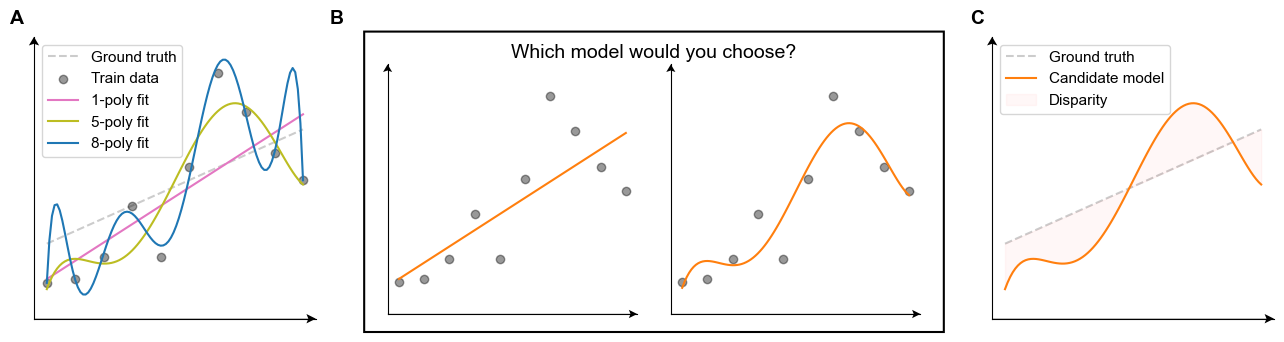

In [7]:
# Figure 1

# 0) Load dataset
df_stimuli = pd.read_csv(os.path.join("..","experiment","img_Ntrain1050_largenoise", "stimuli.csv"))
dpt_columns = ["x_train","y_train"]
for col in dpt_columns: # Convert string arrays into Numpy arrays
    df_stimuli = convert_strarray_column_to_numpy(df_stimuli, col)
x_train = df_stimuli["x_train"].iloc[0]
y_train = df_stimuli["y_train"].iloc[0]
ymin = df_stimuli["ymin"].iloc[0]
ymax = df_stimuli["ymax"].iloc[0]
true_params = df_stimuli[["param"+str(i) for i in range(1,7)]].iloc[0]
true_family = df_stimuli["ground_truth"].iloc[0]

training_range = [-1000,1000]
test_range = training_range
x_curve = np.linspace(training_range[0], test_range[1], 100)
y_grid_true = generate_data(x_curve, true_params, true_family)
y_grid_true = (y_grid_true - ymin)/(ymax-ymin)
# 1) Fit models
# Fit linear model
lin_model = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1)),
    LinearRegression()
).fit(x_train.reshape(-1,1), y_train)

# Fit 5th‐degree polynomial
fivepoly_model = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1)),
    PolynomialFeatures(degree=5, include_bias=False),
    LinearRegression()
).fit(x_train.reshape(-1,1), y_train)

# Fit 8th‐degree polynomial
eightpoly_model = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1)),
    PolynomialFeatures(degree=8, include_bias=False),
    LinearRegression()
).fit(x_train.reshape(-1,1), y_train)
fitted_model_names = ["linear", "five_poly", "eight_poly"]

# Plot
y_curve_lin  = lin_model.predict(x_curve.reshape(-1,1))
y_curve_fivepoly = fivepoly_model.predict(x_curve.reshape(-1,1))
y_curve_eightpoly = eightpoly_model.predict(x_curve.reshape(-1,1))


fig = plt.figure(figsize=(16, 4))
data_alpha = 0.4
model_alpha = 1
# ---- Outer grid: [ ax0 | (ax1, ax2) | ax3 ] ----
outer_gs = gridspec.GridSpec(
    1, 3,
    width_ratios=[1, 2, 1],
    wspace=0.15
)

ax0 = fig.add_subplot(outer_gs[0, 0])
ax3 = fig.add_subplot(outer_gs[0, 2])

# ---- Inner grid for the middle two panels ----
middle_gs = gridspec.GridSpecFromSubplotSpec(
    1, 2,
    subplot_spec=outer_gs[0, 1],
    wspace=0.01   # <-- closeness between the two middle plots
)

ax1 = fig.add_subplot(middle_gs[0, 0])
ax2 = fig.add_subplot(middle_gs[0, 1])

ax = [ax0, ax1, ax2, ax3]

# Optional: make all subplots square-ish
for a in ax:
    a.set_box_aspect(1)   # requires Matplotlib >= 3.3

# ------------------------------
# Your plotting code
# ------------------------------

ymin = y_train.min() - 2*np.abs(y_train.min())
ymax = y_train.max() + 2*np.abs(y_train.min())

# Figure 1A: generative process
ax[0].plot(x_curve, y_grid_true, "--", color="k", alpha=0.2, label="Ground truth")
ax[0].scatter(x_train, y_train, color="k", alpha=data_alpha, label="Train data")
ax[0].plot(x_curve, y_curve_lin,       color="C6",  alpha=model_alpha, label="1-poly fit")
ax[0].plot(x_curve, y_curve_fivepoly,  color="C8",  alpha=model_alpha, label="5-poly fit")
ax[0].plot(x_curve, y_curve_eightpoly, color="C10", alpha=model_alpha, label="8-poly fit")
ax[0].set_xlim(training_range[0]-100, training_range[1]+100) 
ax[0].set_ylim(ymin, ymax)
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[0].legend()
arrowed_spines(fig, ax[0], ax[0].get_xlim(), ax[0].get_ylim())

# Middle left: linear model
ax[1].scatter(x_train, y_train, color="k", alpha=data_alpha, label="Train data")
ax[1].plot(x_curve, y_curve_lin, color="C1", alpha=1, label="1-poly")
ax[1].set_xlim(training_range[0]-100, training_range[1]+100) 
ax[1].set_ylim(ymin, ymax) 
ax[1].set_xticks([]); ax[1].set_yticks([])
arrowed_spines(fig, ax[1], ax[1].get_xlim(), ax[1].get_ylim())

# Middle right: 5-poly model
ax[2].scatter(x_train, y_train, color="k", alpha=data_alpha, label="Train data")
ax[2].plot(x_curve, y_curve_fivepoly, color="C1", alpha=1, label="5-poly")
ax[2].set_xlim(training_range[0]-100, training_range[1]+100) 
ax[2].set_ylim(ymin, ymax) 
ax[2].set_xticks([]); ax[2].set_yticks([])
arrowed_spines(fig, ax[2], ax[2].get_xlim(), ax[2].get_ylim())

# Rightmost: testMSE viz
ax[3].plot(x_curve, y_grid_true, "--", color="k", alpha=0.2, label="Ground truth")
ax[3].plot(x_curve, y_curve_fivepoly, color="C1", alpha=1, label="Candidate model")
ax[3].fill_between(x_curve, y_grid_true, y_curve_fivepoly,
                   color='r', alpha=0.03, label="Disparity")
ax[3].set_xlim(training_range[0]-100, training_range[1]+100) 
ax[3].set_ylim(ymin, ymax) 
ax[3].set_xticks([]); ax[3].set_yticks([])
ax[3].legend()
arrowed_spines(fig, ax[3], ax[3].get_xlim(), ax[3].get_ylim())

# -------------------------------------------------
# NEW PART: tweak middle_gs block + text + box
# -------------------------------------------------

# Make sure layout positions are computed
fig.canvas.draw()

# 1) Get combined bounding box of the middle block (ax1 + ax2)
pos1 = ax[1].get_position()
pos2 = ax[2].get_position()

left   = pos1.x0
right  = pos2.x1
bottom = min(pos1.y0, pos2.y0)
top    = max(pos1.y1, pos2.y1)

block_height = top - bottom
usable_height = 0.89 * block_height           # bottom 95% for the plots
header_height = block_height - usable_height  # top 5% header region

usable_top = bottom + usable_height

# 1) Restrict the two middle axes to the bottom 95% of the block
for a in [ax[1], ax[2]]:
    pos = a.get_position()
    a.set_position([pos.x0, bottom+0.01, pos.width, usable_height])
    # keep them square as much as possible
    a.set_box_aspect(1)

# 2) Add text centered in the empty header region
text_x = (left + right) / 2
text_y = usable_top + header_height / 2

fig.text(
    text_x, text_y,
    "Which model would you choose?",
    ha='center', va='center',
    fontsize=14
)

# 3) Add a rounded rectangle around the whole middle block
# --- Padding amounts (tune freely) ---
pad_x = 0.005   # horizontal padding (in figure coords)
pad_y = 0.015  # vertical padding (in figure coords)
# Unpadded rectangle
rect_x = left
rect_y = bottom
rect_w = right - left
rect_h = block_height
# Add asymmetric padding
rect = FancyBboxPatch(
    (rect_x - pad_x, rect_y - pad_y - 0.02),
    rect_w + 2*pad_x,
    rect_h + 2*pad_y + 0.02,
    boxstyle="round,pad=0.0",
    transform=fig.transFigure,
    fill=False,
    linewidth=1.5,
    edgecolor="black",
)
fig.add_artist(rect)

# Avoid fig.tight_layout() here; it can fight our manual positioning.
# If you need global margins:
# plt.subplots_adjust(left=0.03, right=0.97, top=0.95, bottom=0.08)
fig.text(0.11,0.88, "A", fontsize=14, weight="bold")
fig.text(0.31,0.88, "B", fontsize=14, weight="bold")
fig.text(0.71,0.88, "C", fontsize=14, weight="bold")

plt.savefig(os.path.join(figpath,"Fig1.png"), dpi=200)
plt.savefig(os.path.join(figpath,"Fig1.pdf"), format="pdf")
plt.show()


C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3924357506.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')
C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3924357506.py:206: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  g1 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model)",
C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3924357506.py:215: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  g2 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - Efron",
C:\Users\liu_s\AppData\Loc

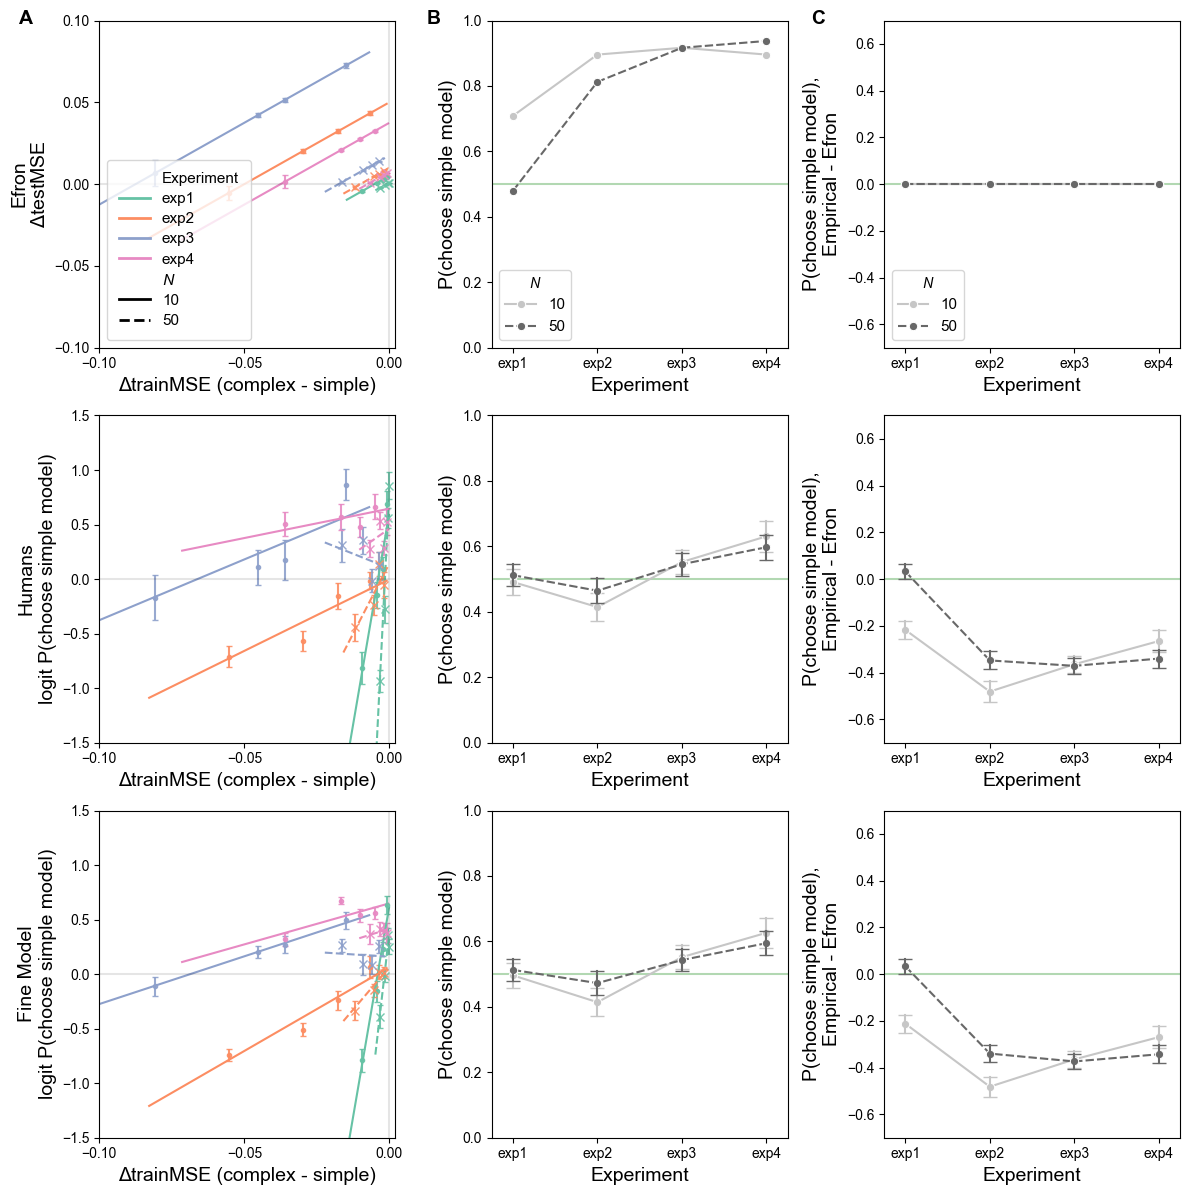

In [13]:
# Figure 2

controlled_stratification = False
rownames = ["Efron normative", "Humans", "Fine Model"]
palette_exp = sns.color_palette("Set2")
palette_gray = sns.color_palette(palette='Greys', n_colors=2)
linetypes = ["-","--"]

fig, ax = plt.subplots(len(rownames),3, figsize=(12,12)) #(16,21), (16,13)
for plot_idx, plot_name in enumerate(rownames):
    # For the same stimulus, average across subjects
    if(plot_idx<2):
        df_temp = df_alltrials.copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    else: # Plot simulated data from Fine model
        df_temp = df_allsimtrials_models[rownames[plot_idx]].copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    df_temp = df_temp.rename(columns={"experiment":"Experiment", "response_choosecomplexmodel":"P(choose complex model)", "trainMSE_modeldiff": "Δ trainMSE", "dD": "Δ D", "sample_size":"N_train", "OLSnoise_est_mean": "V_est", "noise_var": "V"})

    # Transform notation
    
    df_temp["Δ testMSE_Efron"] = df_temp["testMSE_Efron_complexmodel"] - df_temp["testMSE_Efron_simplemodel"]
    #df_temp["Δ testMSE"] = df_temp["testMSE_complexmodel"] - df_temp["testMSE_simplemodel"]
    df_temp["logit P(choose simple model)"] = np.log((1-df_temp["P(choose complex model)"])/df_temp["P(choose complex model)"])
    df_temp["Δ trainMSE"] = -df_temp["Δ trainMSE"]
    df_temp["Δ D"] = -df_temp["Δ D"]
    df_temp["1/N_train"] = 1/df_temp["N_train"]
    
    if(plot_idx==0): # What to show on y-axis
        y_temp = "Δ testMSE_Efron" # Efron normative
    else:
        y_temp = "logit P(choose simple model)" # Empirical human or Fine model simulations

    # Bin 'Δ trainMSE' into quintiles
    bins = np.percentile(df_temp["Δ trainMSE"], [0,10,20,30,40,50,60,70,80,90,100])
    #bins = [-1,-0.12,-0.09,-0.06,-0.03,0]
    labels = [str(i+1) for i in range(len(bins)-1)]
    df_temp['Δ trainMSE bins'] = pd.cut(df_temp['Δ trainMSE'], bins=bins, labels=labels, right=False)
    # Compute the mean Δ trainMSE within each bin and assign to all rows in that bin
    df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')


    showmeans=True
    meanprops={
        "marker": ".", # Marker shape (e.g., 's' for square, 'D' for diamond)
        "markerfacecolor": "k", # Fill color of the marker
        "markeredgecolor": "k", # Edge color of the marker
        "markersize": "5", # Size of the marker
    }

    N_trains = [10,50]

    # # 1) TrainMSE_diff and response
    hue_temp = "Experiment"
    x_temp = "Δ trainMSE"
    hue_vals = df_temp[hue_temp].unique()
    legend_order = np.unique(df_temp["Experiment"])
    positions = sorted(df_temp[x_temp].unique())
    if(controlled_stratification):
        df_temptemp = df_temp[(df_temp["Experiment"]=="exp1") | (df_temp["Experiment"]=="exp2")]
    else: 
        df_temptemp = df_temp.copy()

    ax_here = ax[plot_idx, 0]
    x_col = x_temp
    y_col = y_temp

    # 1) Copy and create per-stratum quintile bins on x
    df_binned = df_temp.copy()

    # Quintiles within each (Experiment, N_train) group
    df_binned["x_bin"] = (
        df_binned
        .groupby(["Experiment", "N_train"])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),  # ensures strictly increasing values
            q=4, # How many percentiles
            labels=False
        ))
    )

    # 2) Compute stats per (Experiment, N_train, x_bin)
    stats = (
        df_binned
        .groupby(["Experiment", "N_train", "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )

    # 3) Color & linestyle mapping (adapt to your variables)
    color_map = dict(zip(legend_order, palette_exp))
    linestyle_map = {
        val: style
        for val, style in zip(sorted(df_temp["N_train"].unique()), ["-", "--"])
    }

    # 4) Plot errorbars
    markertypes = [".","x"]
    for (exp, n_train), sub in stats.groupby(["Experiment", "N_train"]):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=markertypes[int(n_train==50)],
            linestyle=None,
            color=color_map[exp],
            capsize=2,
            alpha=0.9,
            label=f"{exp}, N_train={n_train}",
            
        )
   
    color_handles = []
    linestyle_handles = []
    for hue_val, color in zip(hue_vals, palette_exp):
        for N_train_idx, N_train_val in enumerate(N_trains):
            subset = df_temptemp[(df_temptemp["N_train"] == N_train_val) & (df_temptemp[hue_temp] == hue_val)]
            sns.regplot(
                data=subset,
                x=x_temp, y=y_temp,
                ax=ax[plot_idx,0],
                scatter=False,
                color=color,                # <- ensure matching color
                line_kws={'linestyle': linetypes[N_train_idx], 'lw':1.5, 'label':hue_val},
                seed=0,
                ci=None
            )
        # Create a single handle for COLOR legend (one per hue)
        color_handles.append(
            mlines.Line2D([], [], color=color, linestyle='-', lw=2, label=hue_val)
        )
    # Create handles for LINESTYLE legend (one per N_train)
    for N_train_idx, N_train_val in enumerate(N_trains):
        linestyle_handles.append(
            mlines.Line2D(
                [], [], 
                color='black',           # color irrelevant—legend only shows linestyle
                linestyle=linetypes[N_train_idx], 
                lw=2,
                label=str(N_train_val)
            )
        )
    header_color  = mlines.Line2D([], [], linestyle='none', label=hue_temp)
    header_style  = mlines.Line2D([], [], linestyle='none', label="$N$")
    all_handles = (
        [header_color] +
        color_handles +
        [header_style] +
        linestyle_handles
    )
    if(plot_idx==0):
        leg = ax[plot_idx,0].legend(
            handles=all_handles,
            loc="lower left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
    
#         blank = mlines.Line2D([], [], linestyle="none", label="")

#     # Left column: header + experiments
#     left_col = [mlines.Line2D([], [], linestyle="none", label="Experiment")] + color_handles

#     # Right column: header + N values + padding blanks to match length
#     right_col = [mlines.Line2D([], [], linestyle="none", label="N")] + linestyle_handles
#     right_col += [blank] * (len(left_col) - len(right_col))  # pad to same length

#     # IMPORTANT: concatenate column-wise (left column then right column)
#     legend_handles = left_col + right_col

#     if plot_idx == 0:
#         leg = ax[plot_idx, 0].legend(
#             handles=legend_handles,
#             ncol=2,
#             loc="lower left",
#             frameon=True,
#             handlelength=2,
#             columnspacing=2.0,
#             labelspacing=0.6,
#             borderpad=0.8,
#             handletextpad=0.8
#         )
    if(plot_idx==0):
        ax[plot_idx,0].set_ylabel("$\mathrm{ΔtestMSE}$")
            

    # 2) P(choose complex)
    if(plot_name=="Humans"):
        df_temp = df_alltrials_biases.copy()
    else:
        df_temp =  df_allsimtrials_biases_models[plot_name].copy()
    df_temp = df_temp.rename(columns={"experiment":"Experiment"})
    prob_bins = np.arange(0,1,0.1)
    error_bins = np.arange(-1,1,0.1)
    # Change notation: label 1 is choosing simple model
    df_temp["P(choose simple model)"] = 1-df_temp["%trials choose complex model"]
    df_temp["P(choose simple model),\nEmpirical - Efron"] = -df_temp["bias (testMSE_Efron)"]
    df_temp['N_train'] = df_temp['N_train'].astype(int).astype(str)
        
    ax[plot_idx,1].plot([-0.25,3.25],[0.5,0.5], "g-",alpha=0.3)
    ax[plot_idx,2].plot([-0.25,3.25],[0,0], "g-",alpha=0.3)
    if(plot_name=="Efron normative"):
        g1 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model)",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,1],
            markers='o',
            palette = palette_gray,
            err_kws={'capsize':0}
        )
        g2 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - Efron",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,2],
            markers='o',
            palette = palette_gray,
            err_kws={'capsize':0}
        )
        new_title = "$N$"
        ax[plot_idx,1].legend(loc="lower left").set_title(new_title)
        ax[plot_idx,2].legend(loc="lower left").set_title(new_title)
    else:
        g1 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model)",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,1],
            markers='o',
            palette = palette_gray,
            errorbar=("se", 1),
            err_kws={'capsize':5},
            legend = False
        )
        g2 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - Efron",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,2],
            markers='o',
            palette = palette_gray,
            errorbar=("se", 1),
            err_kws={'capsize':5},
            legend = False
        )
    ax[plot_idx,1].set_xlim([-0.25,3.25])
    ax[plot_idx,2].set_xlim([-0.25,3.25])
    ax[plot_idx,1].set_ylim([0,1])
    ax[plot_idx,2].set_ylim([-0.7,0.7])
    

    
    ax[plot_idx,0].plot([-2,2],[0,0], "k-", alpha=0.1)
    ax[plot_idx,0].plot([0,0],[-10,10], "k-", alpha=0.1)
    ax[plot_idx,0].set_xticks(np.arange(-0.15, 0.005, 0.05))
    #ax[0,0].set_title("ΔtrainMSE \nmore positive favors simple")
    ax[plot_idx,0].set_xlabel("ΔtrainMSE (complex - simple)")
    y_label = ax[plot_idx,0].get_ylabel()
    ax[plot_idx,0].set_xlim([-0.1,0.002])
    if(plot_name=="Efron normative"):
        ax[plot_idx,0].set_ylabel("Efron\n"+y_label)
        ax[plot_idx,0].set_yticks(np.arange(-0.1,0.15,0.05))
        ax[plot_idx,0].set_ylim([-0.1,0.1])
    else:
        ax[plot_idx,0].set_ylabel(rownames[plot_idx]+"\n"+y_label)
        #ax[plot_idx,0].get_legend().remove()
        ax[plot_idx,0].set_ylim([-1.5,1.5])
#     if(controlled_stratification):
#         fig.suptitle("Only visualize experiments that control for all but one variable")
#     else:
#         fig.suptitle("Visualize all experiments")

fig.text(0.02,0.98, "A", fontsize=14, weight="bold")
fig.text(0.36,0.98, "B", fontsize=14, weight="bold")
fig.text(0.68,0.98, "C", fontsize=14, weight="bold")


fig.tight_layout()
plt.savefig(os.path.join(figpath,"Fig2.png"), dpi=200)
plt.savefig(os.path.join(figpath,"Fig2.pdf"), format="pdf")
plt.show()

C:\Users\liu_s\pyro_env2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\3697600610.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\3697600610.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')
C:\Users\liu

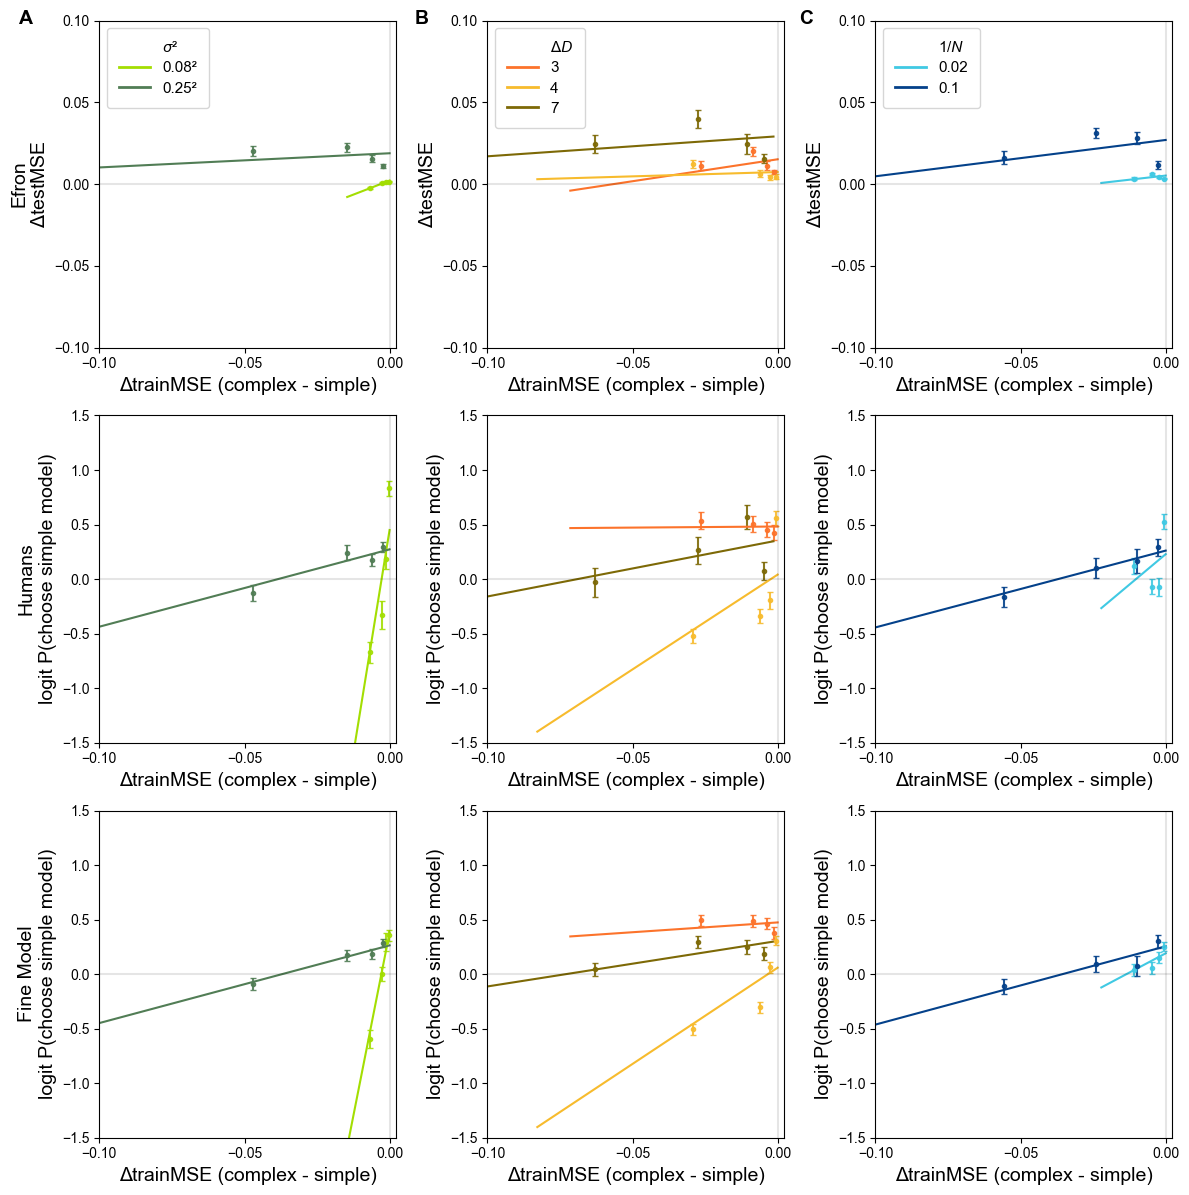

In [9]:
# Figure 3

controlled_stratification = False
rownames = ["Efron normative", "Humans", "Fine Model"]

# Use an explicit palette (recommended for consistency)
palette_exp = sns.color_palette("Set2")
palette = ['#e41a1c', '#4daf4a', '#377eb8']
# cmap_EfronTerms = [[sns.light_palette("seagreen")[2],sns.light_palette("seagreen")[-1]],
#                     [sns.light_palette("C0")[2],sns.light_palette("C0")[-1]],
#                     [sns.light_palette("xkcd:copper")[2],sns.light_palette("xkcd:copper")[-1]]]

cmap_EfronTerms =   [["#A3DE02" ,"#517D55"],
                    ["#FC732B","#F7BB2D","#7D6906"],
                    ["#40C9E3","#04418A"]]

linetypes = ["-","--"]
num_errorbar_bins = 4

fig, ax = plt.subplots(len(rownames),3, figsize=(12,12)) #(16,21), (16,13)
for plot_idx, row_name in enumerate(rownames):
    # For the same stimulus, average across subjects
    if(row_name=="Humans"):
        df_temp = df_alltrials.copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    else: # Plot simulated data from Fine model
        df_temp = df_allsimtrials_models[rownames[plot_idx]].copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    df_temp = df_temp.rename(columns={"response_choosecomplexmodel":"P(choose complex model)", "trainMSE_modeldiff": "Δ trainMSE", "dD": "Δ D", "sample_size":"N_train", "OLSnoise_est_mean": "V_est", "noise_var": "V"})

    # Transform notation
    df_temp["Δ testMSE_Efron"] = df_temp["testMSE_Efron_complexmodel"] - df_temp["testMSE_Efron_simplemodel"]
    #df_temp["Δ testMSE"] = df_temp["testMSE_complexmodel"] - df_temp["testMSE_simplemodel"]
    df_temp["logit P(choose simple model)"] = np.log((1-df_temp["P(choose complex model)"])/df_temp["P(choose complex model)"])
    df_temp["Δ trainMSE"] = -df_temp["Δ trainMSE"]
    df_temp["ΔD"] = -df_temp["Δ D"]
    df_temp["1/N_train"] = 1/df_temp["N_train"]
    
    if(plot_idx==0): # What to show on y-axis
        y_temp = "Δ testMSE_Efron" # Efron normative
    else:
        y_temp = "logit P(choose simple model)" # Empirical human or Fine model simulations

    # Bin 'Δ trainMSE' into quintiles
    bins = np.percentile(df_temp["Δ trainMSE"], [0,10,20,30,40,50,60,70,80,90,100])
    #bins = [-1,-0.12,-0.09,-0.06,-0.03,0]
    labels = [str(i+1) for i in range(len(bins)-1)]
    df_temp['Δ trainMSE bins'] = pd.cut(df_temp['Δ trainMSE'], bins=bins, labels=labels, right=False)
    # Compute the mean Δ trainMSE within each bin and assign to all rows in that bin
    df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')

    showmeans=True
    meanprops={
        "marker": ".", # Marker shape (e.g., 's' for square, 'D' for diamond)
        "markerfacecolor": "k", # Fill color of the marker
        "markeredgecolor": "k", # Edge color of the marker
        "markersize": "5", # Size of the marker
    }
    N_trains = [10,50]  # now unused

    # 2) V and response
    if(controlled_stratification):
        df_temptemp = df_temp[(df_temp["experiment"]=="exp1") | (df_temp["experiment"]=="exp2")]
    else: 
        df_temptemp = df_temp.copy()
    hue_temp = "V"
    x_temp = "Δ trainMSE"
    hue_vals = np.sort(df_temptemp[hue_temp].unique())
    positions = sorted(df_temptemp[x_temp].unique())
    
    # Binned errorbars (human data) – now grouped only by V
    col_idx = 0
    ax_here = ax[plot_idx, col_idx]
    x_col = x_temp
    y_col = y_temp
    df_binned = df_temp.copy()
    df_binned["x_bin"] = (
        df_binned
        .groupby([hue_temp])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),
            q=num_errorbar_bins,
            labels=False
        ))
    )
    stats = (
        df_binned
        .groupby([hue_temp, "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )
    color_map = dict(zip(hue_vals, cmap_EfronTerms[col_idx]))

    # Errorbars: one per V, no N_train stratification
    for v_val, sub in stats.groupby(hue_temp):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=".",
            linestyle="none",
            color=color_map[v_val],
            capsize=2,
            alpha=0.9,
        )

    # Regression lines: one solid line per V
    color_handles = []
    for hue_val in hue_vals:
        subset = df_temptemp[df_temptemp[hue_temp] == hue_val]
        sns.regplot(
            data=subset,
            x=x_temp, y=y_temp,
            ax=ax_here,
            scatter=False,
            color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
            line_kws={'linestyle': '-', 'lw':1.5},
            seed=0,
            ci=None
        )
        color_handles.append(
            mlines.Line2D(
                [], [], 
                color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
                linestyle='-', lw=2,
                label=str(np.sqrt(hue_val))+"²"
            )
        )

    # Legend: only σ²
    header_color  = mlines.Line2D([], [], linestyle='none', label="$σ²$")
    all_handles = [header_color] + color_handles
    if(plot_idx==0):
        leg = ax_here.legend(
            handles=all_handles,
            loc="upper left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    # 3) ΔD and response
    hue_temp = "ΔD"
    x_temp = "Δ trainMSE"
    if(controlled_stratification):
        df_temptemp = df_temp[df_temp["experiment"]!="exp1"]
    else: 
        df_temptemp = df_temp.copy()
    hue_vals = np.sort(df_temptemp[hue_temp].unique())
    positions = sorted(df_temptemp[x_temp].unique())

    col_idx = 1
    ax_here = ax[plot_idx, col_idx]
    x_col = x_temp
    y_col = y_temp
    df_binned = df_temp.copy()
    df_binned["x_bin"] = (
        df_binned
        .groupby([hue_temp])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),
            q=num_errorbar_bins,
            labels=False
        ))
    )
    stats = (
        df_binned
        .groupby([hue_temp, "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )
    color_map = dict(zip(hue_vals, cmap_EfronTerms[col_idx]))

    for dD_val, sub in stats.groupby(hue_temp):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=".",
            linestyle="none",
            color=color_map[dD_val],
            capsize=2,
            alpha=0.9,
        )

    color_handles = []
    for hue_val in hue_vals:
        subset = df_temptemp[df_temptemp[hue_temp] == hue_val]
        sns.regplot(
            data=subset,
            x=x_temp, y=y_temp,
            ax=ax_here,
            scatter=False,
            color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
            line_kws={'linestyle': '-', 'lw':1.5},
            seed=0,
            ci=None
        )
        color_handles.append(
            mlines.Line2D(
                [], [], 
                color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
                linestyle='-', lw=2,
                label=int(hue_val)
            )
        )

    header_color  = mlines.Line2D([], [], linestyle='none', label="$ΔD$")
    all_handles = [header_color] + color_handles
    if(plot_idx==0):
        leg = ax_here.legend(
            handles=all_handles,
            loc="upper left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    # 4) 1/N_train and response
    hue_temp = "1/N_train"
    x_temp = "Δ trainMSE"
    df_temptemp = df_temp.copy()
    hue_vals = np.sort(df_temp[hue_temp].unique())
    positions = sorted(df_temp[x_temp].unique())

    col_idx = 2
    ax_here = ax[plot_idx, col_idx]
    x_col = x_temp
    y_col = y_temp
    df_binned = df_temp.copy()
    df_binned["x_bin"] = (
        df_binned
        .groupby([hue_temp])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),
            q=num_errorbar_bins,
            labels=False
        ))
    )
    stats = (
        df_binned
        .groupby([hue_temp, "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )
    color_map = dict(zip(hue_vals, cmap_EfronTerms[col_idx]))

    for invN_val, sub in stats.groupby(hue_temp):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=".",
            linestyle="none",
            color=color_map[invN_val],
            capsize=2,
            alpha=0.9,
        )

    color_handles = []
    for hue_val in hue_vals:
        subset = df_temptemp[df_temptemp[hue_temp] == hue_val]
        sns.regplot(
            data=subset,
            x=x_temp, y=y_temp,
            ax=ax_here,
            scatter=False,
            color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
            line_kws={'linestyle': '-', 'lw':1.5},
            seed=0,
            ci=None
        )
        color_handles.append(
            mlines.Line2D(
                [], [], 
                color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
                linestyle='-', lw=2,
                label=hue_val
            )
        )

    header_color  = mlines.Line2D([], [], linestyle='none', label="1/$N$")
    all_handles = [header_color] + color_handles
    if(plot_idx==0):
        leg = ax_here.legend(
            handles=all_handles,
            loc="upper left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    for col_idx in range(3):
        if(plot_idx==0):
            ax[plot_idx,col_idx].set_ylabel("$\mathrm{ΔtestMSE}$")
        ax[plot_idx,col_idx].plot([-2,1],[0,0], "k-", alpha=0.1)
        ax[plot_idx,col_idx].plot([0,0],[-10,10], "k-", alpha=0.1)
        ax[plot_idx,col_idx].set_xticks(np.arange(-0.15, 0.005, 0.05))
        ax[plot_idx,col_idx].set_xlim([-0.1,0.002])
        if(col_idx==0):
            y_label = ax[plot_idx,0].get_ylabel()
        if(row_name != "Efron normative"): # Not plot Efron normative row.
            ax[plot_idx,0].set_ylabel(rownames[plot_idx]+"\n"+y_label)
            ax[plot_idx,col_idx].set_ylim([-1.5,1.5])
        else:
            ax[plot_idx,0].set_ylabel("Efron\n"+y_label)
            ax[plot_idx,col_idx].set_yticks(np.arange(-0.1,0.15,0.05))
            ax[plot_idx,col_idx].set_ylim([-0.1,0.1])
#     ax[0,0].set_title("ΔtrainMSE \nmore positive favors simple")
    ax[plot_idx,0].set_xlabel("ΔtrainMSE (complex - simple)")
    ax[plot_idx,1].set_xlabel("ΔtrainMSE (complex - simple)")
    ax[plot_idx,2].set_xlabel("ΔtrainMSE (complex - simple)")
#     ax[0,0].set_title("V \nmagnifies ΔD; more positive favors simple")
#     ax[0,1].set_title("ΔD \nmore positive favors simple")
#     ax[0,2].set_title("1/N_train \nmagnifies ΔD; more positive favors simple")
    

fig.text(0.02,0.98, "A", fontsize=14, weight="bold")
fig.text(0.35,0.98, "B", fontsize=14, weight="bold")
fig.text(0.67,0.98, "C", fontsize=14, weight="bold")
fig.tight_layout()
plt.savefig(os.path.join(figpath,"Fig3.png"), dpi=200)
plt.savefig(os.path.join(figpath,"Fig3.pdf"), format="pdf")
plt.show()


Coarse Model
Correction term difference, Median: -0.019

Fine Model
Correction term difference, Median: -0.012



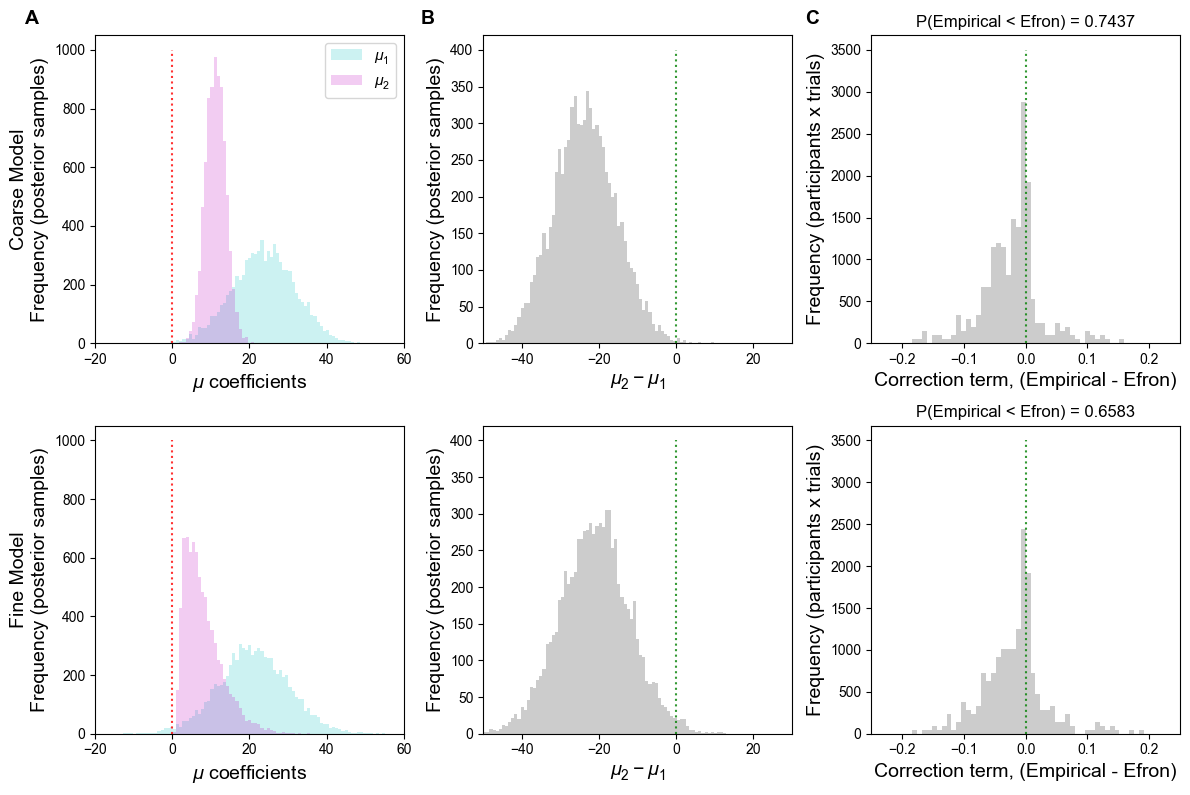

In [10]:
# Figure 4

palette = ['#e41a1c', '#4daf4a', '#377eb8']

mosaic = [['A', 'B', 'C'], ['D', 'E', 'F']] #'.' is an empty space
fig, ax = plt.subplot_mosaic(mosaic, figsize=(12,8))
plot_idx_raw = -1

for model_name in ["Coarse Model","Fine Model"]:
    posterior_samples = posterior_samples_models[model_name]
    mcmc = mcmc_models[model_name]
    
    plot_idx_raw = plot_idx_raw+1
    plot_idx = chr(plot_idx_raw + 65)
    #ax[plot_idx].hist(posterior_samples["mu0"], bins=50, color="m", alpha=0.2, label="μ_0")
    ax[plot_idx].hist(posterior_samples["mu_t"], bins=np.linspace(-20,60,100), color="c", alpha=0.2, label="$μ_1$")
    if(model_name != "Null Model"):
        ax[plot_idx].hist(posterior_samples["mu_k"], bins=np.linspace(-20,60,100), color="m", alpha=0.2, label="$μ_2$")
    ax[plot_idx].plot([0,0],[0,1000],"r:", alpha=0.8)
    ax[plot_idx].set_xlim([-20,60])
    ax[plot_idx].set_xlabel("$μ$ coefficients")
    ax[plot_idx].set_ylabel(model_name + "\nFrequency (posterior samples)")
    if(plot_idx_raw==0):
        ax[plot_idx].legend()
  
    #if(model_name != "Null Model"):
    plot_idx_raw = plot_idx_raw+1
    plot_idx = chr(plot_idx_raw + 65)
    ax[plot_idx].hist(0 - posterior_samples["mu_t"], bins=np.linspace(-50,30,100), color="k", alpha=0.2, label="μ₂ - μ₁")
    ax[plot_idx].plot([0,0],[0,400],"g:", alpha=0.8)
    ax[plot_idx].set_xlim([-50,30])
    ax[plot_idx].set_xlabel("$μ_2 - μ_1$")
    ax[plot_idx].set_ylabel("Frequency (posterior samples)")

    plot_idx_raw = plot_idx_raw+1
    plot_idx = chr(plot_idx_raw + 65)
    if(model_name=="Fine Model"):
        _,_,correction_empirical, correction_Efron, empirical_V, empirical_dD, empirical_invN = posterior_predictive_probs_fine(mcmc, data)
    elif(model_name=="Coarse Model"):
        _,_,correction_empirical, correction_Efron = posterior_predictive_probs_coarse(mcmc, data)
    elif(model_name=="Null Model"):
        _,_,correction_empirical, correction_Efron = posterior_predictive_probs_null(mcmc, data)
    else:
        print("Not a valid model name")
    data_temp = {'correction_diff_Efron': correction_Efron.flatten(), 'N_train': 1/data["invN"], 'correction_empirical': np.mean(correction_empirical,axis=0).flatten(), 
             'Subject_global': data["subj_idx"]}
    df_comparecorrection = pd.DataFrame(data_temp)
    
    ax[plot_idx].hist(df_comparecorrection["correction_empirical"] - df_comparecorrection["correction_diff_Efron"], bins=np.arange(-0.2,0.2,0.008), color="k", alpha=0.2)
    ax[plot_idx].plot([0,0],[0,3500],"g:", alpha=0.8)
    ax[plot_idx].set_xlim([-0.25,0.25])
    ax[plot_idx].set_xlabel("Correction term, (Empirical - Efron)")
    ax[plot_idx].set_ylabel("Frequency (participants x trials)")
    ax[plot_idx].set_title("P(Empirical < Efron) = {0:.4f}".format(np.mean(df_comparecorrection["correction_empirical"] - df_comparecorrection["correction_diff_Efron"]<0)))
    print(model_name)
    print("Correction term difference, Median: {0:.3f}".format(np.median(df_comparecorrection["correction_empirical"] - df_comparecorrection["correction_diff_Efron"])))
    print()
    
fig.text(0.025,0.97, "A", fontsize=14, weight="bold")
fig.text(0.355,0.97, "B", fontsize=14, weight="bold")
fig.text(0.675,0.97, "C", fontsize=14, weight="bold")

fig.tight_layout()
plt.savefig(os.path.join(figpath,"Fig4.png"), dpi=200)
plt.savefig(os.path.join(figpath,"Fig4.pdf"), format="pdf")
plt.show()

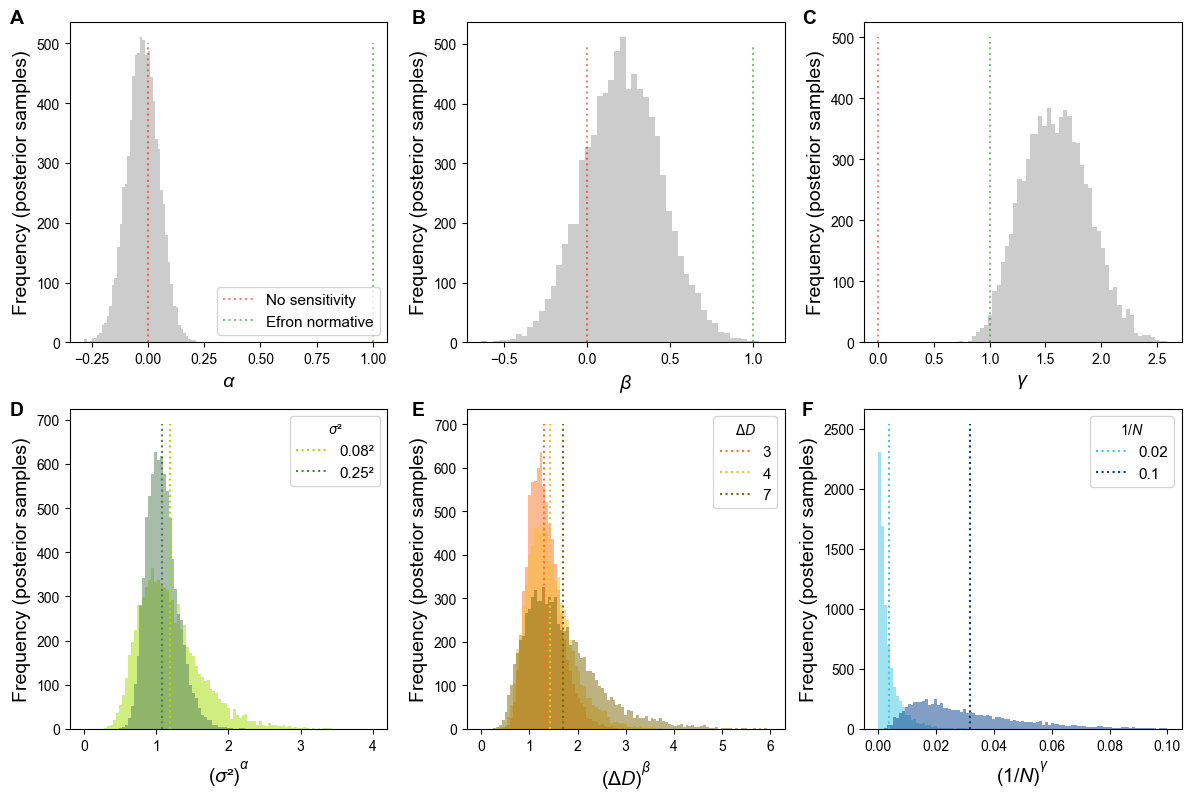

In [11]:
# Figure 5

fig,ax = plt.subplots(2,3,figsize=(12,8))
posterior_samples = posterior_samples_models["Fine Model"]
mcmc = mcmc_models["Fine Model"]

ax[0,0].hist(posterior_samples["alpha"], bins=50, color="k", alpha=0.2)
ax[0,0].set_xlabel("$α$")
#ax[0,0].set_title("Optimal vs. empirical α")

ax[0,1].hist(posterior_samples["beta"], bins=50, color="k", alpha=0.2)
ax[0,1].set_xlabel("$β$")
#ax[0,1].set_title("Optimal vs. empirical β")

ax[0,2].hist(posterior_samples["gamma"], bins=50, color="k", alpha=0.2)
ax[0,2].set_xlabel("$γ$")
#ax[0,2].set_title("Optimal vs. empirical γ")

for col in range(3):
    ax[0,col].set_ylabel("Frequency (posterior samples)")
    ax[0,col].plot([0,0],[0,500],"r:", alpha=0.5, label="No sensitivity")
    ax[0,col].plot([1,1],[0,500],"g:", alpha=0.5, label="Efron normative")
ax[0,0].legend()
    

# Final row: Fine model parameters for V, D, N_train.
row_idx = 1
posterior_samples = posterior_samples_models["Fine Model"]
mcmc = mcmc_models["Fine Model"]
#_,_,correction_empirical, correction_Efron, empirical_V, empirical_dD, empirical_invN = posterior_predictive_probs_fine(mcmc, data)

V_unique = np.unique(data["V"])
max_height = 0
for plot_idx, V_val in enumerate(V_unique):
    n, bins, patches = ax[row_idx,0].hist(V_val ** posterior_samples["alpha"].flatten(), bins=np.linspace(0,4,100), color=cmap_EfronTerms[0][np.where(V_unique==V_val)[0][0]], alpha=0.5)
    max_height = max(max_height,np.max(n)*1.1)
for plot_idx, V_val in enumerate(V_unique):
    x_val = np.mean(V_val ** posterior_samples["alpha"].flatten())
    ax[row_idx,0].plot([x_val, x_val],[0,max_height],":", color=cmap_EfronTerms[0][np.where(V_unique==V_val)[0][0]], alpha=1, label=str(np.sqrt(V_val))+"²")
ax[row_idx,0].set_xlabel("$(σ²)^α$")
ax[row_idx,0].set_ylabel("Frequency (posterior samples)")
ax[row_idx,0].legend(title="$σ²$", loc="upper right")

dD_unique = np.unique(data["dD_raw"])
max_height = 0
for plot_idx, dD_val in enumerate(dD_unique):
    n, bins, patches = ax[row_idx,1].hist(dD_val ** posterior_samples["beta"].flatten(), bins=np.linspace(0,6,100), color=cmap_EfronTerms[1][np.where(dD_unique==dD_val)[0][0]], alpha=0.5)
    max_height = max(max_height,np.max(n)*1.1)
for plot_idx, dD_val in enumerate(dD_unique):
    x_val = np.mean(dD_val ** posterior_samples["beta"].flatten())
    ax[row_idx,1].plot([x_val, x_val],[0,max_height],":", color=cmap_EfronTerms[1][np.where(dD_unique==dD_val)[0][0]],alpha=1, label=str(int(dD_val)))
ax[row_idx,1].set_xlabel("$(ΔD)^β$")
ax[row_idx,1].set_ylabel("Frequency (posterior samples)")
ax[row_idx,1].legend(title="$ΔD$", loc="upper right")

invN_unique = np.unique(data["invN"])
max_height = 0
for plot_idx, invN_val in enumerate(invN_unique):
    n, bins, patches = ax[row_idx,2].hist(invN_val ** posterior_samples["gamma"].flatten(), bins=np.linspace(0,0.1,100), color=cmap_EfronTerms[2][np.where(invN_unique==invN_val)[0][0]], alpha=0.5)
    max_height = max(max_height,np.max(n)*1.1)
for plot_idx, invN_val in enumerate(invN_unique):
    x_val = np.mean(invN_val ** posterior_samples["gamma"].flatten())
    ax[row_idx,2].plot([x_val, x_val],[0,max_height],":", color=cmap_EfronTerms[2][np.where(invN_unique==invN_val)[0][0]], alpha=1, label=str(invN_val))
ax[row_idx,2].set_xlabel("$(1/N)^γ$")
ax[row_idx,2].set_ylabel("Frequency (posterior samples)")
ax[row_idx,2].legend(title="$1/N$", loc="upper right")

fig.text(0.01,0.98, "A", fontsize=14, weight="bold")
fig.text(0.345,0.98, "B", fontsize=14, weight="bold")
fig.text(0.67,0.98, "C", fontsize=14, weight="bold")
fig.text(0.01,0.49, "D", fontsize=14, weight="bold")
fig.text(0.345,0.49, "E", fontsize=14, weight="bold")
fig.text(0.67,0.49, "F", fontsize=14, weight="bold")
fig.tight_layout()
plt.savefig(os.path.join(figpath,"Fig5.png"), dpi=200)
plt.savefig(os.path.join(figpath,"Fig5.pdf"), format="pdf")
plt.show()

C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\2963334060.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(beta0 + beta1 * x)))


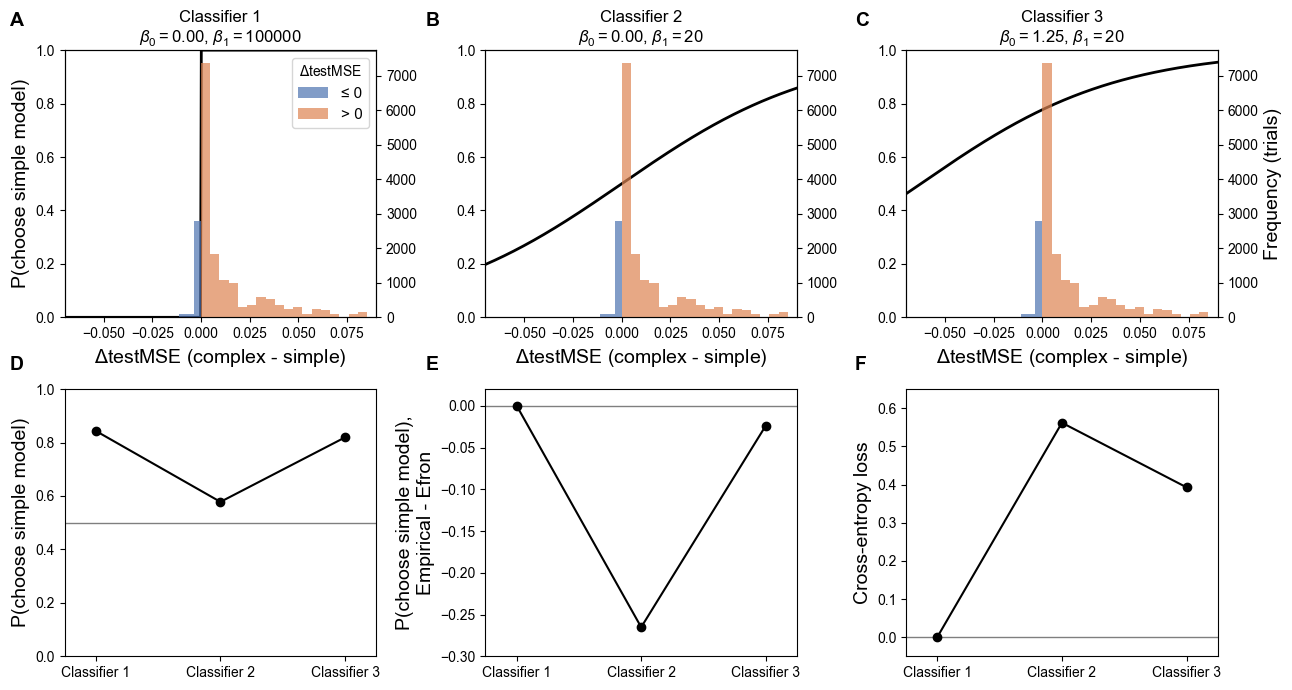

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x_col = "testMSE_modeldiff"

# Sign indicator (if needed later)
df_temp = df_alltrials.copy()
df_temp[x_col] = -df_temp[x_col] 
df_temp["sign"] = np.where(df_temp[x_col] > 0, "> 0", "<= 0")

df_left  = df_temp[df_temp[x_col] <= 0]
df_right = df_temp[df_temp[x_col] > 0]

x_min = -0.07
x_max = 0.09

# Bins with 0 as boundary (no overlap at 0)
bins_left  = np.linspace(x_min, 0, 20)
bins_right = np.linspace(0, x_max, 20)

# x grid for logistic curves
x_grid = np.linspace(x_min, x_max, 400)

def logistic(x, beta0, beta1):
    return 1 / (1 + np.exp(-(beta0 + beta1 * x)))

# Logistic params for the 3 top panels
beta_params = [
    (0.0,  1e5),
    (0.0,  20),
    (1.25,  20),
]

# ----------------- MOSAIC LAYOUT (NO sharex) -----------------
layout = [
    ["A", "B", "C"],
    ["D", "E", "F"],   # 3 cells in row 2 now
]

fig, ax_dict = plt.subplot_mosaic(layout, figsize=(13, 7))

axes_row1     = [ax_dict["A"], ax_dict["B"], ax_dict["C"]]
ax_row2_col1  = ax_dict["D"]
ax_row2_col2  = ax_dict["E"]
ax_row2_col3  = ax_dict["F"]

# ----------------- ROW 1: 3 panels -----------------
for i, ax in enumerate(axes_row1):
    beta0, beta1 = beta_params[i]
    y_logit_grid = logistic(x_grid, beta0, beta1)

    # LEFT axis: logistic curve
    ax.plot(
        x_grid,
        y_logit_grid,
        color="black",
        linewidth=2,
        zorder=10,
        label="Logistic curve"
    )
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)

    if i == 0:
        ax.set_ylabel("P(choose simple model)")

    ax.set_title(f"Classifier {i+1}\n$β_0={beta0:.2f}$, $β_1={beta1:.0f}$")

    # RIGHT axis: histograms
    ax_hist = ax.twinx()
    ax_hist.hist(
        df_left[x_col],
        bins=bins_left,
        color="#4C72B0",
        alpha=0.7,
        label="≤ 0",
    )
    ax_hist.hist(
        df_right[x_col],
        bins=bins_right,
        color="#DD8452",
        alpha=0.7,
        label="> 0",
    )

    if i == 2:
        ax_hist.set_ylabel("Frequency (trials)")

    if i == 0:
        ax_hist.legend(title="$\mathrm{ΔtestMSE}$", loc="upper right")

    ax.set_xlabel("$\mathrm{ΔtestMSE}$ (complex - simple)")

# ----------------- COMMON STUFF FOR ROW 2 -----------------
x_vals = df_temp[x_col].values

# True labels: 1 if x>0, else 0
y_true = (x_vals > 0).astype(int)

# True P(x>0)
true_p = y_true.mean()

# For each curve: expected P(choose label 1) under empirical x
expected_probs = []
cross_entropies = []

eps = 1e-12  # for numerical stability in log

for (beta0, beta1) in beta_params:
    p_x = logistic(x_vals, beta0, beta1)   # model P(label 1 | x)
    expected_probs.append(p_x.mean())

    # Cross-entropy: -E[y log p + (1-y) log (1-p)]
    p_clipped = np.clip(p_x, eps, 1 - eps)
    ce = -np.mean(y_true * np.log(p_clipped) +
                  (1 - y_true) * np.log(1 - p_clipped))
    cross_entropies.append(ce)

curve_labels = [f"Classifier {i+1}" for i in range(len(beta_params))]
x_positions = np.arange(len(beta_params))

# ----------------- ROW 2 COL 1: Expected P over empirical x -----------------
ax = ax_row2_col1
ax.plot(
    x_positions, expected_probs, color="k",
    marker="o", linestyle="-"
)
ax.axhline(0.5, color="black", linewidth=1, alpha=0.5)
ax.set_xticks(x_positions)
ax.set_xticklabels(curve_labels)
ax.set_xlim([-0.25,2.25])
ax.set_ylim([0, 1])
ax.set_ylabel("P(choose simple model)")

# ----------------- ROW 2 COL 2: Bias vs true P(x>0) -----------------
bias_vals = np.array(expected_probs) - true_p

ax = ax_row2_col2
ax.plot(
    x_positions, bias_vals, color="k",
    marker="o", linestyle="-"
)
ax.axhline(0, color="black", linewidth=1, alpha=0.5)
ax.set_xlim([-0.25,2.25])
ax.set_ylim([-0.3,0.02])
ax.set_xticks(x_positions)
ax.set_xticklabels(curve_labels)
ax.set_ylabel("P(choose simple model),\nEmpirical - Efron")

# ----------------- ROW 2 COL 3: Cross-entropy loss -----------------
ax = ax_row2_col3
ax.plot(
    x_positions, cross_entropies, color="k",
    marker="o", linestyle="-"
)
ax.axhline(0, color="black", linewidth=1, alpha=0.5)
ax.set_xlim([-0.25,2.25])
ax.set_ylim([-0.05, 0.65])
ax.set_xticks(x_positions)
ax.set_xticklabels(curve_labels)
ax.set_ylabel("Cross-entropy loss")

fig.text(0.01,0.955, "A", fontsize=14, weight="bold")
fig.text(0.33,0.955, "B", fontsize=14, weight="bold")
fig.text(0.66,0.955, "C", fontsize=14, weight="bold")
fig.text(0.01,0.465, "D", fontsize=14, weight="bold")
fig.text(0.33,0.465, "E", fontsize=14, weight="bold")
fig.text(0.66,0.465, "F", fontsize=14, weight="bold")

plt.tight_layout()
plt.savefig(os.path.join(figpath,"Fig6.png"), dpi=200)
plt.savefig(os.path.join(figpath,"Fig6.pdf"), format="pdf")
plt.show()


## GLME models comparison

In [13]:
# Evaluate LOO loss for each of the three Bayesian hierarchical models.
filenames = ["glme_numpyro_2000_2000_fine_seed0.pickle",
            "glme_numpyro_2000_2000_coarse_seed0.pickle",
            "glme_numpyro_2000_2000_null_seed0.pickle"]
model_names = [model_name + str(" Model") for model_name in ["Fine","Coarse","Null"]]
var_names = [["mu0","mu_t","mu_k","alpha","beta","gamma"],["mu0","mu_t","mu_k"],["mu0","mu_t"]]
loo_models = {}

for model_idx, filename in enumerate(filenames):
    model_name = model_names[model_idx]
    var_name = var_names[model_idx]
    print("\n---------------\n"+model_name)
    
    
    # 1) Load HMC file
    with open(os.path.join(fitspath,filename), 'rb') as file:
        loaded_object = pickle.load(file)
    mcmc = loaded_object["mcmc"]
    idata = az.from_numpyro(mcmc)
    print(az.summary(idata, var_names=var_name))

#     # Compute LOO
#     loo_value = az.loo(idata)
#     loo_models[model_name] = loo_value
#     print(loo_value)


# # Model comparison
# comp = az.compare(
#     {"Null": loo_models["Null Model"], "Coarse": loo_models["Coarse Model"], "Fine": loo_models["Fine Model"]},
#     method="stacking"   # or "stacking", method only affects weights, not Δelpd
# )

# loo_models["comp"] = comp

# with open(os.path.join(fitspath,"loo_models.pickle"), 'wb') as file_handle:
#     pickle.dump(loo_models, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
# print("Data files saved.")
# print(comp)


---------------
Fine Model
         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu0     0.327  0.107     0.113      0.532      0.003    0.002    1162.0   
mu_t   21.080  9.112     2.790     38.713      0.370    0.221     609.0   
mu_k    8.057  4.878     1.415     17.857      0.083    0.069    3107.0   
alpha  -0.022  0.071    -0.162      0.113      0.001    0.001    3817.0   
beta    0.217  0.232    -0.224      0.681      0.004    0.002    4362.0   
gamma   1.594  0.295     1.028      2.148      0.006    0.003    2164.0   

       ess_tail  r_hat  
mu0      2284.0   1.01  
mu_t      903.0   1.01  
mu_k     4819.0   1.00  
alpha    5369.0   1.00  
beta     5686.0   1.00  
gamma    2935.0   1.00  

---------------
Coarse Model
        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu0    0.313  0.111     0.090      0.524      0.004    0.002     938.0   
mu_t  23.655  8.015     7.533     38.893      0.319    0.151     634.0   
mu_k  11.259  2.599

In [14]:
# Model comparison: Bayesian hiearchical and bayesian GLME model fits

with open(os.path.join("modelfits","loo_models.pickle"), 'rb') as file_handle:
    a = pickle.load(file_handle)
# Model comparison
comp = a["comp"]
print(comp)

        rank     elpd_loo       p_loo   elpd_diff        weight         se  \
Fine       0 -9474.121722  489.995895    0.000000  1.000000e+00  66.382086   
Coarse     1 -9572.438812  453.932721   98.317090  0.000000e+00  65.745970   
Null       2 -9720.724223  362.505461  246.602501  2.386666e-09  64.721616   

              dse  warning scale  
Fine     0.000000     True   log  
Coarse  11.597600     True   log  
Null    21.202302     True   log  


# Appendix plots


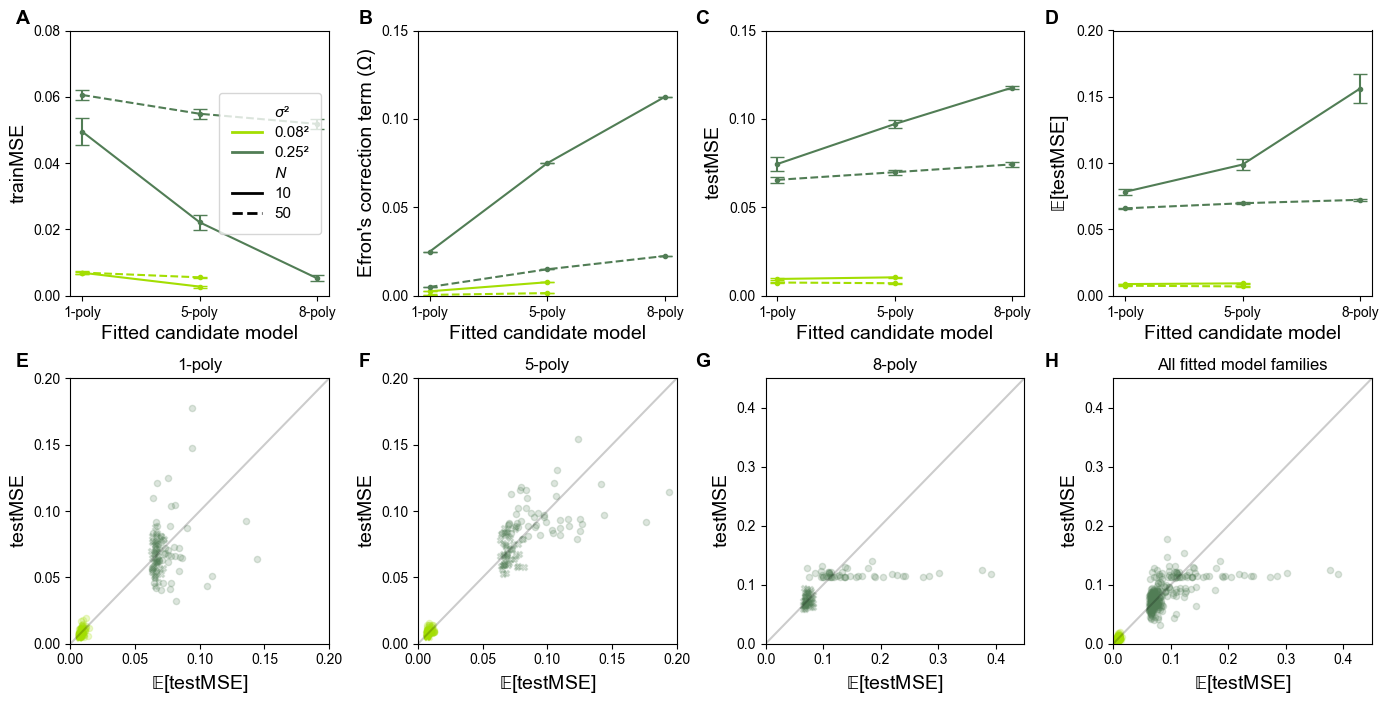

In [14]:
# Check summary stats for each experiment and N_train condition.
model_names = ["linear","five_poly","eight_poly"]
trainMSE_cols = ["linear_MSE_train", "five_poly_MSE_train", "eight_poly_MSE_train"]
Efron_correction_cols = ['linear_correction_Efron', 'five_poly_correction_Efron', 'eight_poly_correction_Efron']
Efron_testMSE_cols = ['linear_MSE_Efron', 'five_poly_MSE_Efron', 'eight_poly_MSE_Efron']
testMSE_cols = ['linear_MSE', 'five_poly_MSE', 'eight_poly_MSE']
allcols = trainMSE_cols + Efron_correction_cols + Efron_testMSE_cols + testMSE_cols

df_summarystats = df_allexps.groupby(["experiment","sample_size"], as_index=False)[allcols].mean()
df_summarystats_sem = df_allexps.groupby(["experiment","sample_size"], as_index=False)[allcols].std()
df_summarystats_ntrials = df_allexps.groupby(["experiment","sample_size"], as_index=False)[allcols].size()
numeric_cols = df_summarystats_sem.select_dtypes(include='number').columns
numeric_cols = numeric_cols[numeric_cols != "sample_size"]
ntrials_percond = 48
df_summarystats_sem[numeric_cols] = df_summarystats_sem[numeric_cols]/np.sqrt(ntrials_percond)

# Use an explicit palette (recommended for consistency)
palette_exp = sns.color_palette("Set2")
cmap_EfronTerms =   [["#A3DE02" ,"#517D55"],
                    ["#FC732B","#F7BB2D","#7D6906"],
                    ["#40C9E3","#04418A"]]
dataset_names = ["0.08²", "0.25²"]
markertypes = ["o","X"]
linetypes = ["-","--"]
family_dict = {"linear":"1-poly","five_poly": "5-poly","eight_poly": "8-poly"}
color_handles = []
linestyle_handles = []
    
fig,ax = plt.subplots(2,4,figsize=(14,7))
for exp_idx in range(len(experiment_name_temps)):
    experiment_group_temp = experiment_group_temps[exp_idx]
    if(experiment_group_temp in ["exp3","exp4"]):
        continue;
    # Create a single handle for COLOR legend (one per hue)
    col = cmap_EfronTerms[0][exp_idx]
    color_handles.append(
        mlines.Line2D([], [], color=col, linestyle='-', lw=2, label=dataset_names[exp_idx])
    )
    for N_train_idx, N_train in enumerate(N_trains):
        df_exp = df_allexps[df_allexps["experiment"]==experiment_group_temp]
        df_expcond = df_exp[df_exp["sample_size"]==N_train]
        
        df_temp = df_summarystats[df_summarystats["experiment"]==experiment_group_temp]
        df_temp = df_temp[df_temp["sample_size"]==N_train]
        df_temp_sem = df_summarystats_sem[df_summarystats_sem["experiment"]==experiment_group_temp]
        df_temp_sem = df_temp_sem[df_temp_sem["sample_size"]==N_train]
        ax[0,0].errorbar(range(3), df_temp[trainMSE_cols].to_numpy().flatten(), yerr=df_temp_sem[trainMSE_cols].to_numpy().flatten(), 
                     color=col, fmt="."+linetypes[N_train_idx], capsize=5, label=dataset_names[exp_idx]+", N="+str(N_train))
        ax[0,1].errorbar(range(3), df_temp[Efron_correction_cols].to_numpy().flatten(), yerr=df_temp_sem[Efron_correction_cols].to_numpy().flatten(), 
                     color=col, fmt="."+linetypes[N_train_idx], capsize=5, label=dataset_names[exp_idx]+", N="+str(N_train))
        ax[0,2].errorbar(range(3), df_temp[Efron_testMSE_cols].to_numpy().flatten(), yerr=df_temp_sem[Efron_testMSE_cols].to_numpy().flatten(), 
             color=col, fmt="."+linetypes[N_train_idx], capsize=5, label=dataset_names[exp_idx]+", N="+str(N_train))
        ax[0,3].errorbar(range(3), df_temp[testMSE_cols].to_numpy().flatten(), yerr=df_temp_sem[testMSE_cols].to_numpy().flatten(), 
             color=col, fmt="."+linetypes[N_train_idx], capsize=5, label=dataset_names[exp_idx]+", N="+str(N_train))
        for model_idx in range(len(testMSE_cols)):
            if(model_idx==(len(testMSE_cols)-1) and exp_idx==0): # Experiment 1 no 8-poly
                continue;
            ax[1,model_idx].scatter(df_expcond[testMSE_cols[model_idx]], df_expcond[Efron_testMSE_cols[model_idx]], marker=markertypes[N_train_idx], s=20, color=col, alpha=0.2, label="N_train="+str(N_train))
            xmin = df_allexps[testMSE_cols[model_idx]].min()
            xmax = df_allexps[testMSE_cols[model_idx]].max()
            ax[1,model_idx].set_xlabel("$\mathrm{𝔼[testMSE]}$")
            ax[1,model_idx].set_ylabel("$\mathrm{testMSE}$")
            ax[1,model_idx].set_title(family_dict[model_names[model_idx]])
            ax[1,3].scatter(df_expcond[testMSE_cols[model_idx]], df_expcond[Efron_testMSE_cols[model_idx]], s=20, color=col, alpha=0.2)

for subplot_idx in range(4):        
    #ax[0,subplot_idx].set_xticks([0,1,2], model_names)
    ax[0,subplot_idx].set_xlabel("Fitted candidate model")
    ax[0,subplot_idx].set_xticks([0,1,2], [family_dict[fam] for fam in model_names])

    
# Create handles for LINESTYLE legend (one per N_train)
for N_train_idx, N_train_val in enumerate(N_trains):
    linestyle_handles.append(
        mlines.Line2D(
            [], [], 
            color='black',           # color irrelevant—legend only shows linestyle
            linestyle=linetypes[N_train_idx], 
            lw=2,
            label=str(N_train_val)
        )
    )
header_color  = mlines.Line2D([], [], linestyle='none', label="$σ²$")
header_style  = mlines.Line2D([], [], linestyle='none', label="$N$")
all_handles = (
    [header_color] +
    color_handles +
    [header_style] +
    linestyle_handles
)
leg = ax[0,0].legend(
    handles=all_handles,
    loc="center right",
    frameon=True,
    handlelength=2,
    borderpad=0.8,
    labelspacing=0.4
)
        
                     
            
ax[0,0].set_ylabel("trainMSE")
ax[0,1].set_ylabel("Efron's correction term (Ω)")
ax[0,2].set_ylabel("$\mathrm{testMSE}$")
ax[0,3].set_ylabel("$\mathrm{\mathbb{E}[testMSE]}$")

ax[0,0].set_ylim([0,0.08])
ax[0,1].set_ylim([0,0.15])
ax[0,2].set_ylim([0,0.15])
ax[0,3].set_ylim([0,0.2])
ax[1,0].set_ylim([0,0.2])
ax[1,1].set_ylim([0,0.2])
ax[1,2].set_ylim([0,0.45])
ax[1,3].set_ylim([0,0.45])
ax[1,0].set_xlim([0,0.15])
ax[1,1].set_xlim([0,0.2])
ax[1,2].set_xlim([0,0.45])
ax[1,3].set_xlim([0,0.45])

ax[0,0].set_yticks(np.arange(0,0.1,0.02))
ax[0,1].set_yticks(np.arange(0,0.2,0.05))
ax[0,2].set_yticks(np.arange(0,0.2,0.05))
ax[0,3].set_yticks(np.arange(0,0.25,0.05))
ax[1,0].set_yticks(np.arange(0,0.25,0.05))
ax[1,1].set_yticks(np.arange(0,0.25,0.05))
ax[1,2].set_yticks(np.arange(0,0.5,0.1))
ax[1,3].set_yticks(np.arange(0,0.5,0.1))
ax[1,0].set_xticks(np.arange(0,0.25,0.05))

ax[1,0].plot([0,0.2],[0,0.2],"k-", alpha=0.2)
ax[1,1].plot([0,0.2],[0,0.2],"k-", alpha=0.2)
ax[1,2].plot([0,0.45],[0,0.45],"k-", alpha=0.2)
ax[1,3].plot([0,0.45],[0,0.45],"k-", alpha=0.2)
ax[1,3].set_xlabel("$\mathrm{\mathbb{E}[testMSE]}$")
ax[1,3].set_ylabel("$\mathrm{testMSE}$")
ax[1,3].set_title("All fitted model families")
#fig.suptitle("Summary statistics for the two datasets")

fig.text(0.015,0.98, "A", fontsize=14, weight="bold")
fig.text(0.26,0.98, "B", fontsize=14, weight="bold")
fig.text(0.50,0.98, "C", fontsize=14, weight="bold")
fig.text(0.75,0.98, "D", fontsize=14, weight="bold")

fig.text(0.015,0.49, "E", fontsize=14, weight="bold")
fig.text(0.26,0.49, "F", fontsize=14, weight="bold")
fig.text(0.50,0.49, "G", fontsize=14, weight="bold")
fig.text(0.75,0.49, "H", fontsize=14, weight="bold")

fig.tight_layout()
plt.savefig(os.path.join(figpath,"FigS1.png"), dpi=200)
plt.savefig(os.path.join(figpath,"FigS1.pdf"), format="pdf")
plt.show()

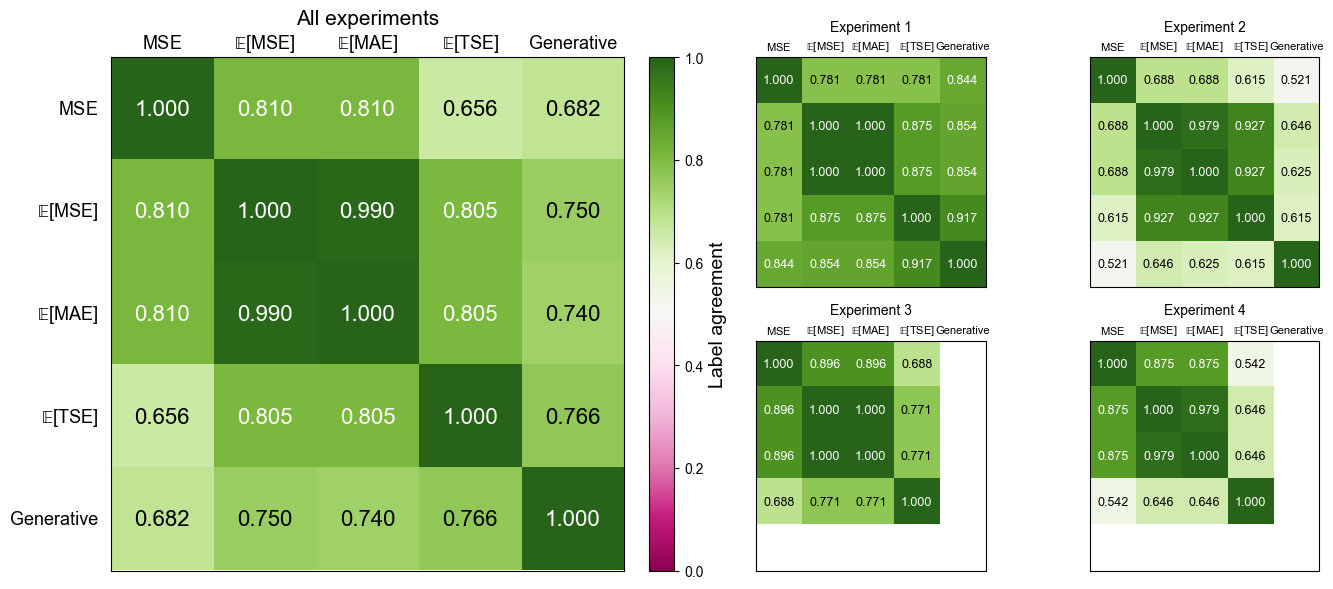

In [16]:
label_columns = ['MSE_bestmodel_labels_Efron','MSE_bestmodel_labels','MAE_bestmodel_labels', 'TSE_bestmodel_labels','ground_truth_labels']
label_names = ["$\mathrm{MSE}$","$\mathrm{\mathbb{E}[MSE]}$","$\mathrm{\mathbb{E}[MAE]}$","$\mathrm{\mathbb{E}[TSE]}$","Generative"]
mosaic = [['A', 'A', 'B', 'C'], ['A', 'A', 'D', 'E']] #'.' is an empty space
fig, ax = plt.subplot_mosaic(mosaic, figsize=(14,6))
plot_idx_raw = -1
num_label_types = len(label_columns)
labeltype_crossmatches = np.zeros((5, num_label_types, num_label_types))
match_norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
match_cmap = plt.get_cmap("PiYG")


for plot_idx_raw in range(5):
    if(plot_idx_raw==0):
        df_temp =  df_allexps[["experiment"]+label_columns]
    else: # By experiment
        df_temp = df_allexps[(df_allexps["experiment"]=="exp"+str(plot_idx_raw))][["experiment"]+label_columns]
    plot_idx = chr(plot_idx_raw + 65)
    for label_idx, label in enumerate(label_columns):
        for label_idx2, label2 in enumerate(label_columns): 
            if(label_idx==(num_label_types-1) or label_idx2==(num_label_types-1)): # Generative labels: only use Experiment 1 and 2.
                if(plot_idx_raw==0): # When aggregating across experiments, only aggregate Experiments 1 and 2
                    df_temptemp = df_temp[(df_temp["experiment"]=="exp1") | (df_temp["experiment"]=="exp2")]
                    labeltype_crossmatches[plot_idx_raw, label_idx, label_idx2] = np.mean(df_temptemp[label]==df_temptemp[label2])
                elif(plot_idx_raw<=2):
                    labeltype_crossmatches[plot_idx_raw, label_idx, label_idx2] = np.mean(df_temp[label]==df_temp[label2])
                else: # Experiment 3 and 4; 8-poly is not ground truth labels
                    labeltype_crossmatches[plot_idx_raw, label_idx, label_idx2] = np.nan
            else:
                labeltype_crossmatches[plot_idx_raw, label_idx, label_idx2] = np.mean(df_temp[label]==df_temp[label2])
    

    cax0 = ax[plot_idx].matshow(labeltype_crossmatches[plot_idx_raw,:,:], cmap=match_cmap, norm=match_norm)
    
    # Overlay text for each square with values rounded to the third decimal
    for i in range(num_label_types):
        for j in range(num_label_types):
            if(labeltype_crossmatches[plot_idx_raw,i,j]<0.8):
                loss_color = "black"
            else: 
                loss_color="white"
            if(i!=j):
                ax[plot_idx].text(j, i, f"{labeltype_crossmatches[plot_idx_raw,i,j]:.3f}", 
                   ha="center", va="center", color=loss_color, fontsize=9 + (plot_idx_raw==0)*7)
            else: # Label with respect to itself
                ax[plot_idx].text(j, i, f"{labeltype_crossmatches[plot_idx_raw,i,j]:.3f}", 
               ha="center", va="center", color=loss_color, fontsize=9 + (plot_idx_raw==0)*7)
    if(plot_idx_raw==0):
        title = "All experiments"
    else:
        title = "Experiment "+str(plot_idx_raw)
    ax[plot_idx].set_title(title, fontsize=10+ (plot_idx_raw==0)*5)
    ax[plot_idx].set_xticks(range(num_label_types))
    ax[plot_idx].set_yticks(range(num_label_types))
    ax[plot_idx].tick_params('x', pad=7+ (plot_idx_raw==0)*2, length=1, width=0, which='major')
    ax[plot_idx].set_xticklabels(label_names, rotation=0, ha="center", va="center", fontsize=8+ (plot_idx_raw==0)*5)
    if((plot_idx_raw==0)):
        ax[plot_idx].tick_params('y', pad=4+ (plot_idx_raw==0)*4, length=1, width=0, which='major')
        ax[plot_idx].set_yticklabels(label_names, rotation=0, ha="center", va="center", fontsize=8+ (plot_idx_raw==0)*5)
    else:
        ax[plot_idx].tick_params('y', pad=0, length=1, width=0, which='major')
        ax[plot_idx].set_yticks([])
    # Set the horizontal alignment of the major tick labels to 'right'
    for label in ax[plot_idx].yaxis.get_ticklabels():
        label.set_ha('right')
    if(plot_idx_raw==0):
        cbar1 = fig.colorbar(cax0, ax=ax["A"], fraction=0.046, pad=0.04)
        cbar1.set_label('Label agreement')

fig.tight_layout()
plt.savefig(os.path.join(figpath,"FigS2.png"), dpi=200)
plt.savefig(os.path.join(figpath,"FigS2.pdf"), format="pdf")
plt.show()

C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\3787314902.py:25: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - "+baselinename_simple+" labels",
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\3787314902.py:25: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - "+baselinename_simple+" labels",
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\3787314902.py:25: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - "+baselinename_simple+" labels",
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\3787314902.

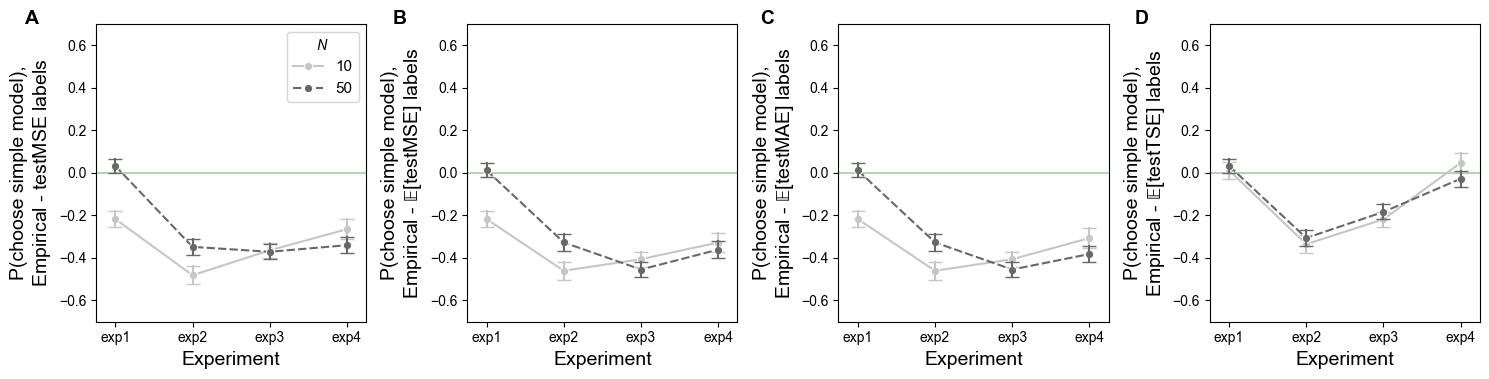

In [17]:
controlled_stratification = False
rownames = ["Humans"]
baselines = ['bias (testMSE_Efron)','bias (testMSE)', 'bias (testMAE)', 'bias (testTSE)']
baseline_names_display = ["$\mathrm{testMSE}$","$\mathrm{\mathbb{E}[testMSE]}$","$\mathrm{\mathbb{E}[testMAE]}$","$\mathrm{\mathbb{E}[testTSE]}$","Generative"]

palette_exp = sns.color_palette("Set2")
palette_gray = sns.color_palette(palette='Greys', n_colors=2)
linetypes = ["-","--"]

fig, ax = plt.subplots(1,4, figsize=(15,15/4)) #(16,21), (16,13)
for plot_idx, baseline_name in enumerate(baselines):
    N_trains = [10,50]

    df_temp = df_alltrials_biases.copy()
    df_temp = df_temp.rename(columns={"experiment":"Experiment"})
    df_temp['N_train'] = df_temp['N_train'].astype(int).astype(str)
    prob_bins = np.arange(0,1,0.1)
    error_bins = np.arange(-1,1,0.1)
    # Change notation: label 1 is choosing simple model
    baselinename_simple = baseline_names_display[plot_idx]
    df_temp["P(choose simple model)"] = 1-df_temp["%trials choose complex model"]
    df_temp["P(choose simple model),\nEmpirical - "+baselinename_simple+" labels"] = -df_temp[baseline_name]
    
    ax[plot_idx].plot([-0.25,3.25],[0,0], "g-",alpha=0.3)
    sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - "+baselinename_simple+" labels",
        hue = "N_train",
        style="N_train",   # Maps different linetypes/markers to the 'event' groups
        err_style="bars", # Displays error bars instead of the default error bands
        ax=ax[plot_idx],
        markers='o',
        palette = palette_gray,
        errorbar=("se", 1),
        err_kws={'capsize':5},
        legend=bool(plot_idx==0)
    )
    if(baselinename_simple=="testMSE_Efron"):
        ax[plot_idx].set_ylabel("P(choose simple model),\nEmpirical - $\mathrm{testMSE}$ labels")
    ax[plot_idx].set_xlim([-0.25,3.25])
    ax[plot_idx].set_ylim([-0.7,0.7])
    if(plot_idx==0):
        ax[plot_idx].legend(title="$N$")
    

    
#     y_label = ax[plot_idx].get_ylabel()
#     ax[plot_idx].set_ylabel(baselines[plot_idx]+"\n"+y_label)
#     if(controlled_stratification):
#         fig.suptitle("Only visualize experiments that control for all but one variable")
#     else:
#         fig.suptitle("Visualize all experiments")

fig.text(0.02,0.96, "A", fontsize=14, weight="bold")
fig.text(0.265,0.96, "B", fontsize=14, weight="bold")
fig.text(0.51,0.96, "C", fontsize=14, weight="bold")
fig.text(0.76,0.96, "D", fontsize=14, weight="bold")
fig.tight_layout()
plt.savefig(os.path.join(figpath,"FigS3.png"), dpi=200)
plt.savefig(os.path.join(figpath,"FigS3.pdf"), format="pdf")
plt.show()

C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3181244964.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')
C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3181244964.py:183: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  g1 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model)",
C:\Users\liu_s\AppData\Local\Temp\ipykernel_55244\3181244964.py:192: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  g2 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - Efron",
C:\Users\liu_s\AppData\Loc

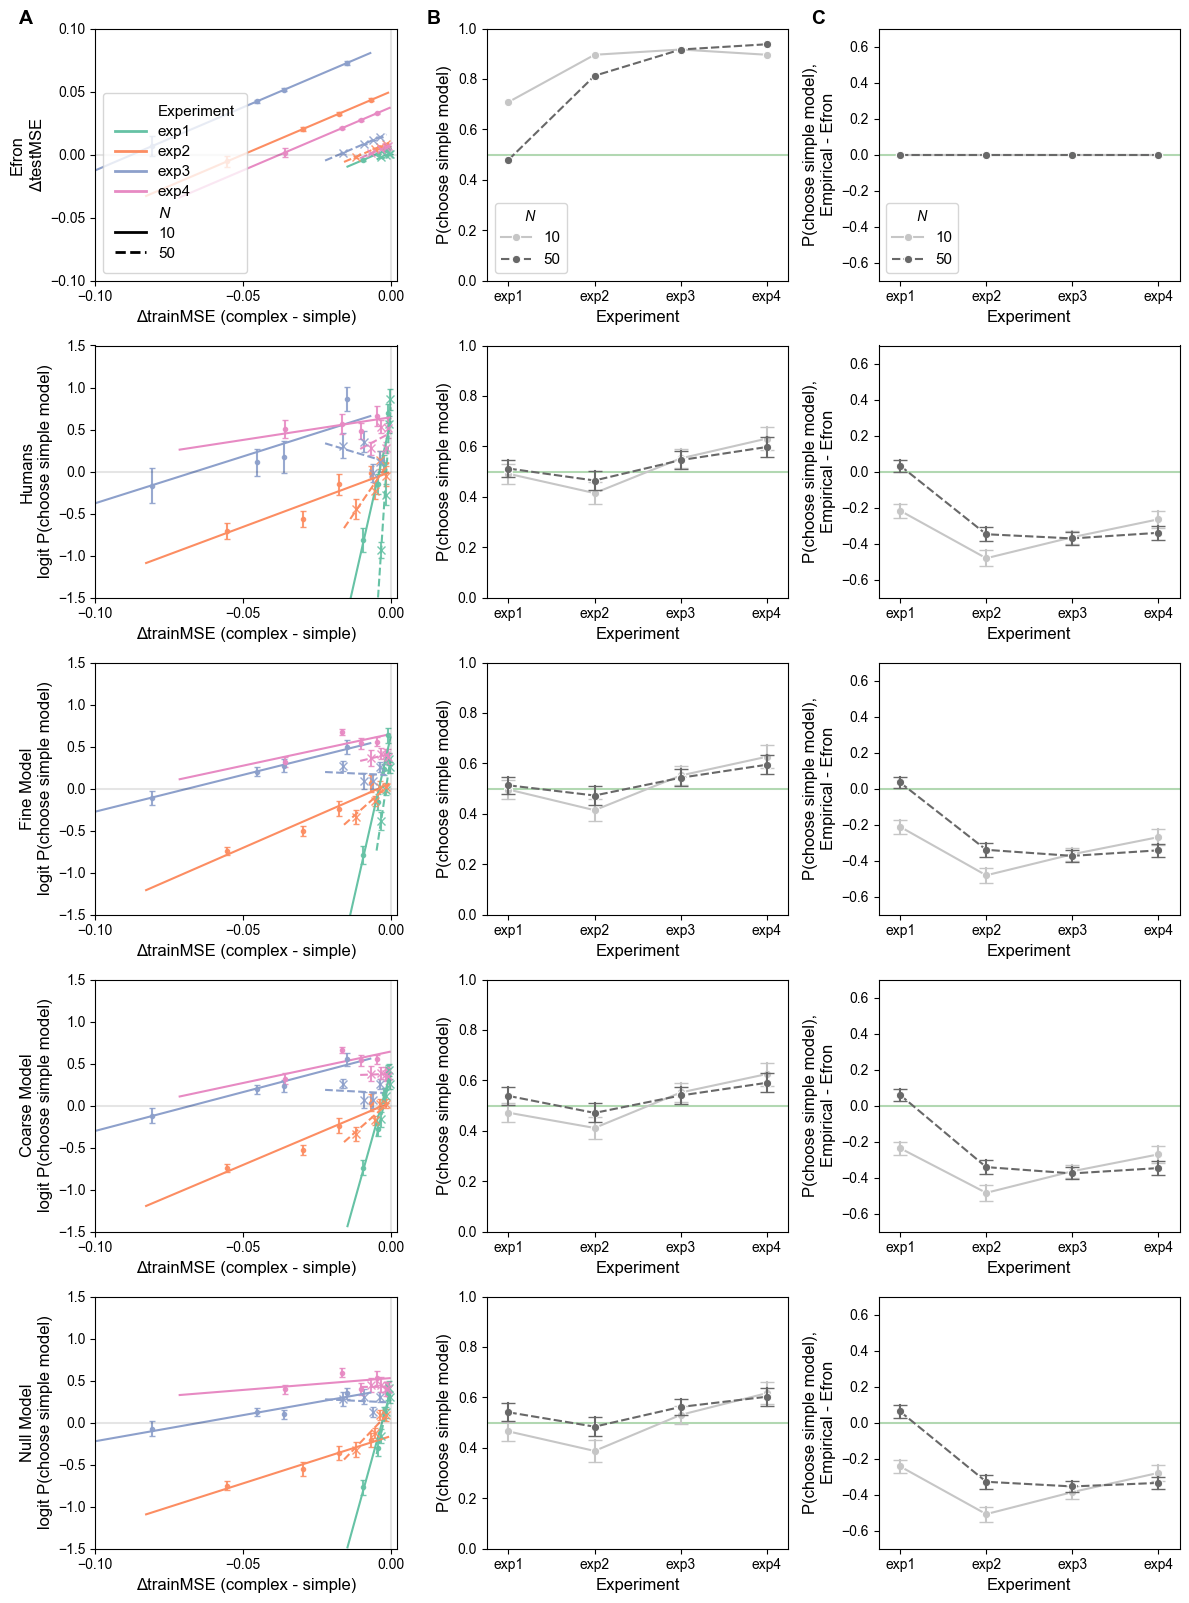

In [15]:
# Joint plot
plt.rcParams['axes.labelsize'] = 12 # Set a global default label size
model_names = ["Fine Model","Coarse Model","Null Model"]
controlled_stratification = False
rownames = ["Efron normative", "Humans"] + model_names
palette_exp = sns.color_palette("Set2")
palette_gray = sns.color_palette(palette='Greys', n_colors=2)
linetypes = ["-","--"]

fig, ax = plt.subplots(len(rownames),3, figsize=(12,16)) #(16,21), (16,13)
for plot_idx, plot_name in enumerate(rownames):
    # For the same stimulus, average across subjects
    if(plot_idx<2):
        df_temp = df_alltrials.copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    else: # Plot simulated data from Fine model
        df_temp = df_allsimtrials_models[rownames[plot_idx]].copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    df_temp = df_temp.rename(columns={"experiment":"Experiment", "response_choosecomplexmodel":"P(choose complex model)", "trainMSE_modeldiff": "Δ trainMSE", "dD": "Δ D", "sample_size":"N_train", "OLSnoise_est_mean": "V_est", "noise_var": "V"})

    # Transform notation
    
    df_temp["Δ testMSE_Efron"] = df_temp["testMSE_Efron_complexmodel"] - df_temp["testMSE_Efron_simplemodel"]
    #df_temp["Δ testMSE"] = df_temp["testMSE_complexmodel"] - df_temp["testMSE_simplemodel"]
    df_temp["logit P(choose simple model)"] = np.log((1-df_temp["P(choose complex model)"])/df_temp["P(choose complex model)"])
    df_temp["Δ trainMSE"] = -df_temp["Δ trainMSE"]
    df_temp["Δ D"] = -df_temp["Δ D"]
    df_temp["1/N_train"] = 1/df_temp["N_train"]
    
    if(plot_idx==0): # What to show on y-axis
        y_temp = "Δ testMSE_Efron" # Efron normative
    else:
        y_temp = "logit P(choose simple model)" # Empirical human or Fine model simulations

    # Bin 'Δ trainMSE' into quintiles
    bins = np.percentile(df_temp["Δ trainMSE"], [0,10,20,30,40,50,60,70,80,90,100])
    #bins = [-1,-0.12,-0.09,-0.06,-0.03,0]
    labels = [str(i+1) for i in range(len(bins)-1)]
    df_temp['Δ trainMSE bins'] = pd.cut(df_temp['Δ trainMSE'], bins=bins, labels=labels, right=False)
    # Compute the mean Δ trainMSE within each bin and assign to all rows in that bin
    df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')


    showmeans=True
    meanprops={
        "marker": ".", # Marker shape (e.g., 's' for square, 'D' for diamond)
        "markerfacecolor": "k", # Fill color of the marker
        "markeredgecolor": "k", # Edge color of the marker
        "markersize": "5", # Size of the marker
    }

    N_trains = [10,50]

    # # 1) TrainMSE_diff and response
    hue_temp = "Experiment"
    x_temp = "Δ trainMSE"
    hue_vals = df_temp[hue_temp].unique()
    legend_order = np.unique(df_temp["Experiment"])
    positions = sorted(df_temp[x_temp].unique())
    if(controlled_stratification):
        df_temptemp = df_temp[(df_temp["Experiment"]=="exp1") | (df_temp["Experiment"]=="exp2")]
    else: 
        df_temptemp = df_temp.copy()

    ax_here = ax[plot_idx, 0]
    x_col = x_temp
    y_col = y_temp

    # 1) Copy and create per-stratum quintile bins on x
    df_binned = df_temp.copy()

    # Quintiles within each (Experiment, N_train) group
    df_binned["x_bin"] = (
        df_binned
        .groupby(["Experiment", "N_train"])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),  # ensures strictly increasing values
            q=4, # How many percentiles
            labels=False
        ))
    )

    # 2) Compute stats per (Experiment, N_train, x_bin)
    stats = (
        df_binned
        .groupby(["Experiment", "N_train", "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )

    # 3) Color & linestyle mapping (adapt to your variables)
    color_map = dict(zip(legend_order, palette_exp))
    linestyle_map = {
        val: style
        for val, style in zip(sorted(df_temp["N_train"].unique()), ["-", "--"])
    }

    # 4) Plot errorbars
    markertypes = [".","x"]
    for (exp, n_train), sub in stats.groupby(["Experiment", "N_train"]):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=markertypes[int(n_train==50)],
            linestyle=None,
            color=color_map[exp],
            capsize=2,
            alpha=0.9,
            label=f"{exp}, N_train={n_train}",
            
        )
   
    color_handles = []
    linestyle_handles = []
    for hue_val, color in zip(hue_vals, palette_exp):
        for N_train_idx, N_train_val in enumerate(N_trains):
            subset = df_temptemp[(df_temptemp["N_train"] == N_train_val) & (df_temptemp[hue_temp] == hue_val)]
            sns.regplot(
                data=subset,
                x=x_temp, y=y_temp,
                ax=ax[plot_idx,0],
                scatter=False,
                color=color,                # <- ensure matching color
                line_kws={'linestyle': linetypes[N_train_idx], 'lw':1.5, 'label':hue_val},
                seed=0,
                ci=None
            )
        # Create a single handle for COLOR legend (one per hue)
        color_handles.append(
            mlines.Line2D([], [], color=color, linestyle='-', lw=2, label=hue_val)
        )
    # Create handles for LINESTYLE legend (one per N_train)
    for N_train_idx, N_train_val in enumerate(N_trains):
        linestyle_handles.append(
            mlines.Line2D(
                [], [], 
                color='black',           # color irrelevant—legend only shows linestyle
                linestyle=linetypes[N_train_idx], 
                lw=2,
                label=str(N_train_val)
            )
        )
    header_color  = mlines.Line2D([], [], linestyle='none', label=hue_temp)
    header_style  = mlines.Line2D([], [], linestyle='none', label="$N$")
    all_handles = (
        [header_color] +
        color_handles +
        [header_style] +
        linestyle_handles
    )
    if(plot_idx==0):
        leg = ax[plot_idx,0].legend(
            handles=all_handles,
            loc="lower left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    if(plot_idx==0):
        ax[plot_idx,0].set_ylabel("$\mathrm{ΔtestMSE}$")
            

    # 2) P(choose complex)
    if(plot_name=="Humans"):
        df_temp = df_alltrials_biases.copy()
    else:
        df_temp =  df_allsimtrials_biases_models[plot_name].copy()
    df_temp = df_temp.rename(columns={"experiment":"Experiment"})
    prob_bins = np.arange(0,1,0.1)
    error_bins = np.arange(-1,1,0.1)
    # Change notation: label 1 is choosing simple model
    df_temp["P(choose simple model)"] = 1-df_temp["%trials choose complex model"]
    df_temp["P(choose simple model),\nEmpirical - Efron"] = -df_temp["bias (testMSE_Efron)"]
    df_temp['N_train'] = df_temp['N_train'].astype(int).astype(str)
    
    ax[plot_idx,1].plot([-0.25,3.25],[0.5,0.5], "g-",alpha=0.3)
    ax[plot_idx,2].plot([-0.25,3.25],[0,0], "g-",alpha=0.3)
    if(plot_name=="Efron normative"):
        g1 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model)",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,1],
            markers='o',
            palette = palette_gray,
            err_kws={'capsize':0}
        )
        g2 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - Efron",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,2],
            markers='o',
            palette = palette_gray,
            err_kws={'capsize':0}
        )
        new_title = "$N$"
        ax[plot_idx,1].legend(loc="lower left").set_title(new_title)
        ax[plot_idx,2].legend(loc="lower left").set_title(new_title)
    else:
        g1 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model)",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,1],
            markers='o',
            palette = palette_gray,
            errorbar=("se", 1),
            err_kws={'capsize':5},
            legend = False
        )
        g2 = sns.lineplot(data=df_temp, x="Experiment", y="P(choose simple model),\nEmpirical - Efron",
            hue = "N_train",
            style="N_train",   # Maps different linetypes/markers to the 'event' groups
            err_style="bars", # Displays error bars instead of the default error bands
            ax=ax[plot_idx,2],
            markers='o',
            palette = palette_gray,
            errorbar=("se", 1),
            err_kws={'capsize':5},
            legend = False
        )
    ax[plot_idx,1].set_xlim([-0.25,3.25])
    ax[plot_idx,2].set_xlim([-0.25,3.25])
    ax[plot_idx,1].set_ylim([0,1])
    ax[plot_idx,2].set_ylim([-0.7,0.7])
    

    
    ax[plot_idx,0].plot([-2,2],[0,0], "k-", alpha=0.1)
    ax[plot_idx,0].plot([0,0],[-10,10], "k-", alpha=0.1)
    ax[plot_idx,0].set_xticks(np.arange(-0.15, 0.005, 0.05))
    #ax[0,0].set_title("ΔtrainMSE \nmore positive favors simple")
    ax[plot_idx,0].set_xlabel("ΔtrainMSE (complex - simple)")
    y_label = ax[plot_idx,0].get_ylabel()
    ax[plot_idx,0].set_xlim([-0.1,0.002])
    if(plot_name=="Efron normative"):
        ax[plot_idx,0].set_ylabel("Efron\n"+y_label)
        ax[plot_idx,0].set_yticks(np.arange(-0.1,0.15,0.05))
        ax[plot_idx,0].set_ylim([-0.1,0.1])
    else:
        ax[plot_idx,0].set_ylabel(rownames[plot_idx]+"\n"+y_label)
        #ax[plot_idx,0].get_legend().remove()
        ax[plot_idx,0].set_ylim([-1.5,1.5])
#     if(controlled_stratification):
#         fig.suptitle("Only visualize experiments that control for all but one variable")
#     else:
#         fig.suptitle("Visualize all experiments")


fig.text(0.02,0.99, "A", fontsize=14, weight="bold")
fig.text(0.36,0.99, "B", fontsize=14, weight="bold")
fig.text(0.68,0.99, "C", fontsize=14, weight="bold")
fig.tight_layout()
plt.savefig(os.path.join(figpath,"FigS4.png"), dpi=200)
plt.savefig(os.path.join(figpath,"FigS4.pdf"), format="pdf")
plt.show()

plt.rcParams['axes.labelsize'] = 14 # Set a global default label size

C:\Users\liu_s\pyro_env2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\2158040497.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')
C:\Users\liu_s\AppData\Local\Temp\ipykernel_20632\2158040497.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')
C:\Users\liu

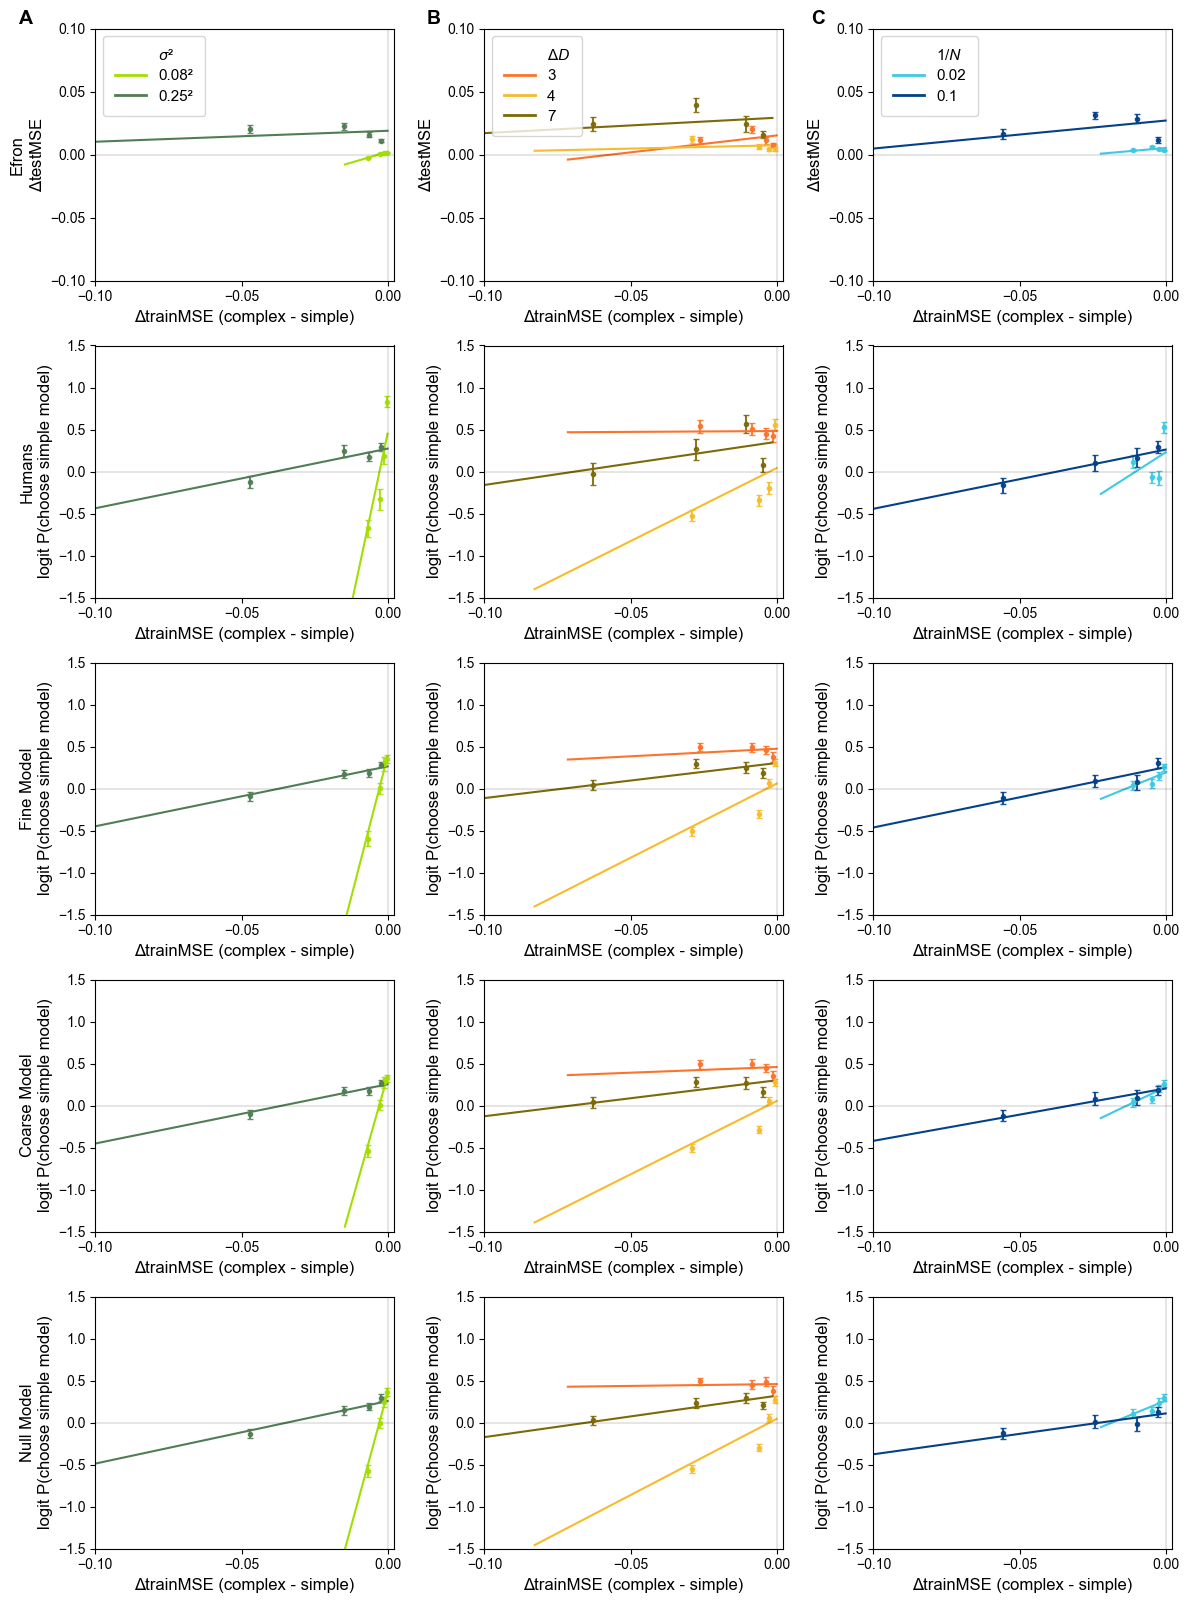

In [19]:
controlled_stratification = False
model_names = ["Fine Model","Coarse Model","Null Model"]
rownames = ["Efron normative","Humans"] + model_names

plt.rcParams['axes.labelsize'] = 12 # Set a global default label size

# Use an explicit palette (recommended for consistency)
palette_exp = sns.color_palette("Set2")
palette = ['#e41a1c', '#4daf4a', '#377eb8']
# cmap_EfronTerms = [[sns.light_palette("seagreen")[2],sns.light_palette("seagreen")[-1]],
#                     [sns.light_palette("C0")[2],sns.light_palette("C0")[-1]],
#                     [sns.light_palette("xkcd:copper")[2],sns.light_palette("xkcd:copper")[-1]]]

cmap_EfronTerms =   [["#A3DE02" ,"#517D55"],
                    ["#FC732B","#F7BB2D","#7D6906"],
                    ["#40C9E3","#04418A"]]

linetypes = ["-","--"]
num_errorbar_bins = 4

fig, ax = plt.subplots(len(rownames),3, figsize=(12,16)) #(16,21), (16,13)

for plot_idx, row_name in enumerate(rownames):
    # For the same stimulus, average across subjects
    if(row_name=="Humans"):
        df_temp = df_alltrials.copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    else: # Plot simulated data from Fine model
        df_temp = df_allsimtrials_models[rownames[plot_idx]].copy().groupby(["experiment","sample_size","stimulus_number"],as_index=False)[["trainMSE_modeldiff", "OLSnoise_est_mean","noise_var", "dD","response_choosecomplexmodel","testMSE_Efron_complexmodel","testMSE_Efron_simplemodel","testMSE_complexmodel","testMSE_simplemodel"]].mean()
    df_temp = df_temp.rename(columns={"response_choosecomplexmodel":"P(choose complex model)", "trainMSE_modeldiff": "Δ trainMSE", "dD": "Δ D", "sample_size":"N_train", "OLSnoise_est_mean": "V_est", "noise_var": "V"})

    # Transform notation
    df_temp["Δ testMSE_Efron"] = df_temp["testMSE_Efron_complexmodel"] - df_temp["testMSE_Efron_simplemodel"]
    #df_temp["Δ testMSE"] = df_temp["testMSE_complexmodel"] - df_temp["testMSE_simplemodel"]
    df_temp["logit P(choose simple model)"] = np.log((1-df_temp["P(choose complex model)"])/df_temp["P(choose complex model)"])
    df_temp["Δ trainMSE"] = -df_temp["Δ trainMSE"]
    df_temp["ΔD"] = -df_temp["Δ D"]
    df_temp["1/N_train"] = 1/df_temp["N_train"]
    
    if(plot_idx==0): # What to show on y-axis
        y_temp = "Δ testMSE_Efron" # Efron normative
    else:
        y_temp = "logit P(choose simple model)" # Empirical human or Fine model simulations

    # Bin 'Δ trainMSE' into quintiles
    bins = np.percentile(df_temp["Δ trainMSE"], [0,10,20,30,40,50,60,70,80,90,100])
    #bins = [-1,-0.12,-0.09,-0.06,-0.03,0]
    labels = [str(i+1) for i in range(len(bins)-1)]
    df_temp['Δ trainMSE bins'] = pd.cut(df_temp['Δ trainMSE'], bins=bins, labels=labels, right=False)
    # Compute the mean Δ trainMSE within each bin and assign to all rows in that bin
    df_temp['Δ trainMSE bin mean'] = df_temp.groupby('Δ trainMSE bins')['Δ trainMSE'].transform('mean')

    showmeans=True
    meanprops={
        "marker": ".", # Marker shape (e.g., 's' for square, 'D' for diamond)
        "markerfacecolor": "k", # Fill color of the marker
        "markeredgecolor": "k", # Edge color of the marker
        "markersize": "5", # Size of the marker
    }
    N_trains = [10,50]  # now unused

    # 2) V and response
    if(controlled_stratification):
        df_temptemp = df_temp[(df_temp["experiment"]=="exp1") | (df_temp["experiment"]=="exp2")]
    else: 
        df_temptemp = df_temp.copy()
    hue_temp = "V"
    x_temp = "Δ trainMSE"
    hue_vals = np.sort(df_temptemp[hue_temp].unique())
    positions = sorted(df_temptemp[x_temp].unique())
    
    # Binned errorbars (human data) – now grouped only by V
    col_idx = 0
    ax_here = ax[plot_idx, col_idx]
    x_col = x_temp
    y_col = y_temp
    df_binned = df_temp.copy()
    df_binned["x_bin"] = (
        df_binned
        .groupby([hue_temp])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),
            q=num_errorbar_bins,
            labels=False
        ))
    )
    stats = (
        df_binned
        .groupby([hue_temp, "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )
    color_map = dict(zip(hue_vals, cmap_EfronTerms[col_idx]))

    # Errorbars: one per V, no N_train stratification
    for v_val, sub in stats.groupby(hue_temp):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=".",
            linestyle="none",
            color=color_map[v_val],
            capsize=2,
            alpha=0.9,
        )

    # Regression lines: one solid line per V
    color_handles = []
    for hue_val in hue_vals:
        subset = df_temptemp[df_temptemp[hue_temp] == hue_val]
        sns.regplot(
            data=subset,
            x=x_temp, y=y_temp,
            ax=ax_here,
            scatter=False,
            color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
            line_kws={'linestyle': '-', 'lw':1.5},
            seed=0,
            ci=None
        )
        color_handles.append(
            mlines.Line2D(
                [], [], 
                color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
                linestyle='-', lw=2,
                label=str(np.sqrt(hue_val))+"²"
            )
        )

    # Legend: only σ²
    header_color  = mlines.Line2D([], [], linestyle='none', label="$σ²$")
    all_handles = [header_color] + color_handles
    if(plot_idx==0):
        leg = ax_here.legend(
            handles=all_handles,
            loc="upper left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    # 3) ΔD and response
    hue_temp = "ΔD"
    x_temp = "Δ trainMSE"
    if(controlled_stratification):
        df_temptemp = df_temp[df_temp["experiment"]!="exp1"]
    else: 
        df_temptemp = df_temp.copy()
    hue_vals = np.sort(df_temptemp[hue_temp].unique())
    positions = sorted(df_temptemp[x_temp].unique())

    col_idx = 1
    ax_here = ax[plot_idx, col_idx]
    x_col = x_temp
    y_col = y_temp
    df_binned = df_temp.copy()
    df_binned["x_bin"] = (
        df_binned
        .groupby([hue_temp])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),
            q=num_errorbar_bins,
            labels=False
        ))
    )
    stats = (
        df_binned
        .groupby([hue_temp, "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )
    color_map = dict(zip(hue_vals, cmap_EfronTerms[col_idx]))

    for dD_val, sub in stats.groupby(hue_temp):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=".",
            linestyle="none",
            color=color_map[dD_val],
            capsize=2,
            alpha=0.9,
        )

    color_handles = []
    for hue_val in hue_vals:
        subset = df_temptemp[df_temptemp[hue_temp] == hue_val]
        sns.regplot(
            data=subset,
            x=x_temp, y=y_temp,
            ax=ax_here,
            scatter=False,
            color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
            line_kws={'linestyle': '-', 'lw':1.5},
            seed=0,
            ci=None
        )
        color_handles.append(
            mlines.Line2D(
                [], [], 
                color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
                linestyle='-', lw=2,
                label=int(hue_val)
            )
        )

    header_color  = mlines.Line2D([], [], linestyle='none', label="$ΔD$")
    all_handles = [header_color] + color_handles
    if(plot_idx==0):
        leg = ax_here.legend(
            handles=all_handles,
            loc="upper left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    # 4) 1/N_train and response
    hue_temp = "1/N_train"
    x_temp = "Δ trainMSE"
    df_temptemp = df_temp.copy()
    hue_vals = np.sort(df_temp[hue_temp].unique())
    positions = sorted(df_temp[x_temp].unique())

    col_idx = 2
    ax_here = ax[plot_idx, col_idx]
    x_col = x_temp
    y_col = y_temp
    df_binned = df_temp.copy()
    df_binned["x_bin"] = (
        df_binned
        .groupby([hue_temp])[x_col]
        .transform(lambda s: pd.qcut(
            s.rank(method="first"),
            q=num_errorbar_bins,
            labels=False
        ))
    )
    stats = (
        df_binned
        .groupby([hue_temp, "x_bin"], as_index=False)
        .agg(
            x_mean=(x_col, "mean"),
            y_mean=(y_col, "mean"),
            y_se=(y_col, lambda s: s.std(ddof=1) / np.sqrt(len(s)))
        )
    )
    color_map = dict(zip(hue_vals, cmap_EfronTerms[col_idx]))

    for invN_val, sub in stats.groupby(hue_temp):
        ax_here.errorbar(
            sub["x_mean"],
            sub["y_mean"],
            yerr=sub["y_se"],
            fmt=".",
            linestyle="none",
            color=color_map[invN_val],
            capsize=2,
            alpha=0.9,
        )

    color_handles = []
    for hue_val in hue_vals:
        subset = df_temptemp[df_temptemp[hue_temp] == hue_val]
        sns.regplot(
            data=subset,
            x=x_temp, y=y_temp,
            ax=ax_here,
            scatter=False,
            color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
            line_kws={'linestyle': '-', 'lw':1.5},
            seed=0,
            ci=None
        )
        color_handles.append(
            mlines.Line2D(
                [], [], 
                color=cmap_EfronTerms[col_idx][np.where(hue_vals==hue_val)[0][0]],
                linestyle='-', lw=2,
                label=hue_val
            )
        )

    header_color  = mlines.Line2D([], [], linestyle='none', label="1/$N$")
    all_handles = [header_color] + color_handles
    if(plot_idx==0):
        leg = ax_here.legend(
            handles=all_handles,
            loc="upper left",
            frameon=True,
            handlelength=2,
            borderpad=0.8,
            labelspacing=0.4
        )
        
    for col_idx in range(3):
        if(plot_idx==0):
            ax[plot_idx,col_idx].set_ylabel("$\mathrm{ΔtestMSE}$")
        ax[plot_idx,col_idx].plot([-2,1],[0,0], "k-", alpha=0.1)
        ax[plot_idx,col_idx].plot([0,0],[-10,10], "k-", alpha=0.1)
        ax[plot_idx,col_idx].set_xticks(np.arange(-0.15, 0.005, 0.05))
        ax[plot_idx,col_idx].set_xlim([-0.1,0.002])
        if(col_idx==0):
            y_label = ax[plot_idx,0].get_ylabel()
        if(row_name != "Efron normative"): # Not plot Efron normative row.
            ax[plot_idx,0].set_ylabel(rownames[plot_idx]+"\n"+y_label)
            ax[plot_idx,col_idx].set_ylim([-1.5,1.5])
        else:
            ax[plot_idx,0].set_ylabel("Efron\n"+y_label)
            ax[plot_idx,col_idx].set_yticks(np.arange(-0.1,0.15,0.05))
            ax[plot_idx,col_idx].set_ylim([-0.1,0.1])
#     ax[0,0].set_title("ΔtrainMSE \nmore positive favors simple")
    ax[plot_idx,0].set_xlabel("ΔtrainMSE (complex - simple)")
    ax[plot_idx,1].set_xlabel("ΔtrainMSE (complex - simple)")
    ax[plot_idx,2].set_xlabel("ΔtrainMSE (complex - simple)")
#     ax[0,0].set_title("V \nmagnifies ΔD; more positive favors simple")
#     ax[0,1].set_title("ΔD \nmore positive favors simple")
#     ax[0,2].set_title("1/N_train \nmagnifies ΔD; more positive favors simple")


fig.text(0.02,0.99, "A", fontsize=14, weight="bold")
fig.text(0.36,0.99, "B", fontsize=14, weight="bold")
fig.text(0.68,0.99, "C", fontsize=14, weight="bold")
fig.tight_layout()
plt.savefig(os.path.join(figpath,"FigS5.png"), dpi=200)
plt.savefig(os.path.join(figpath,"FigS5.pdf"), format="pdf")
plt.show()

plt.rcParams['axes.labelsize'] = 14 # Set a global default label size

img_Ntrain1050 10
Figure_stimuli_d0_n10


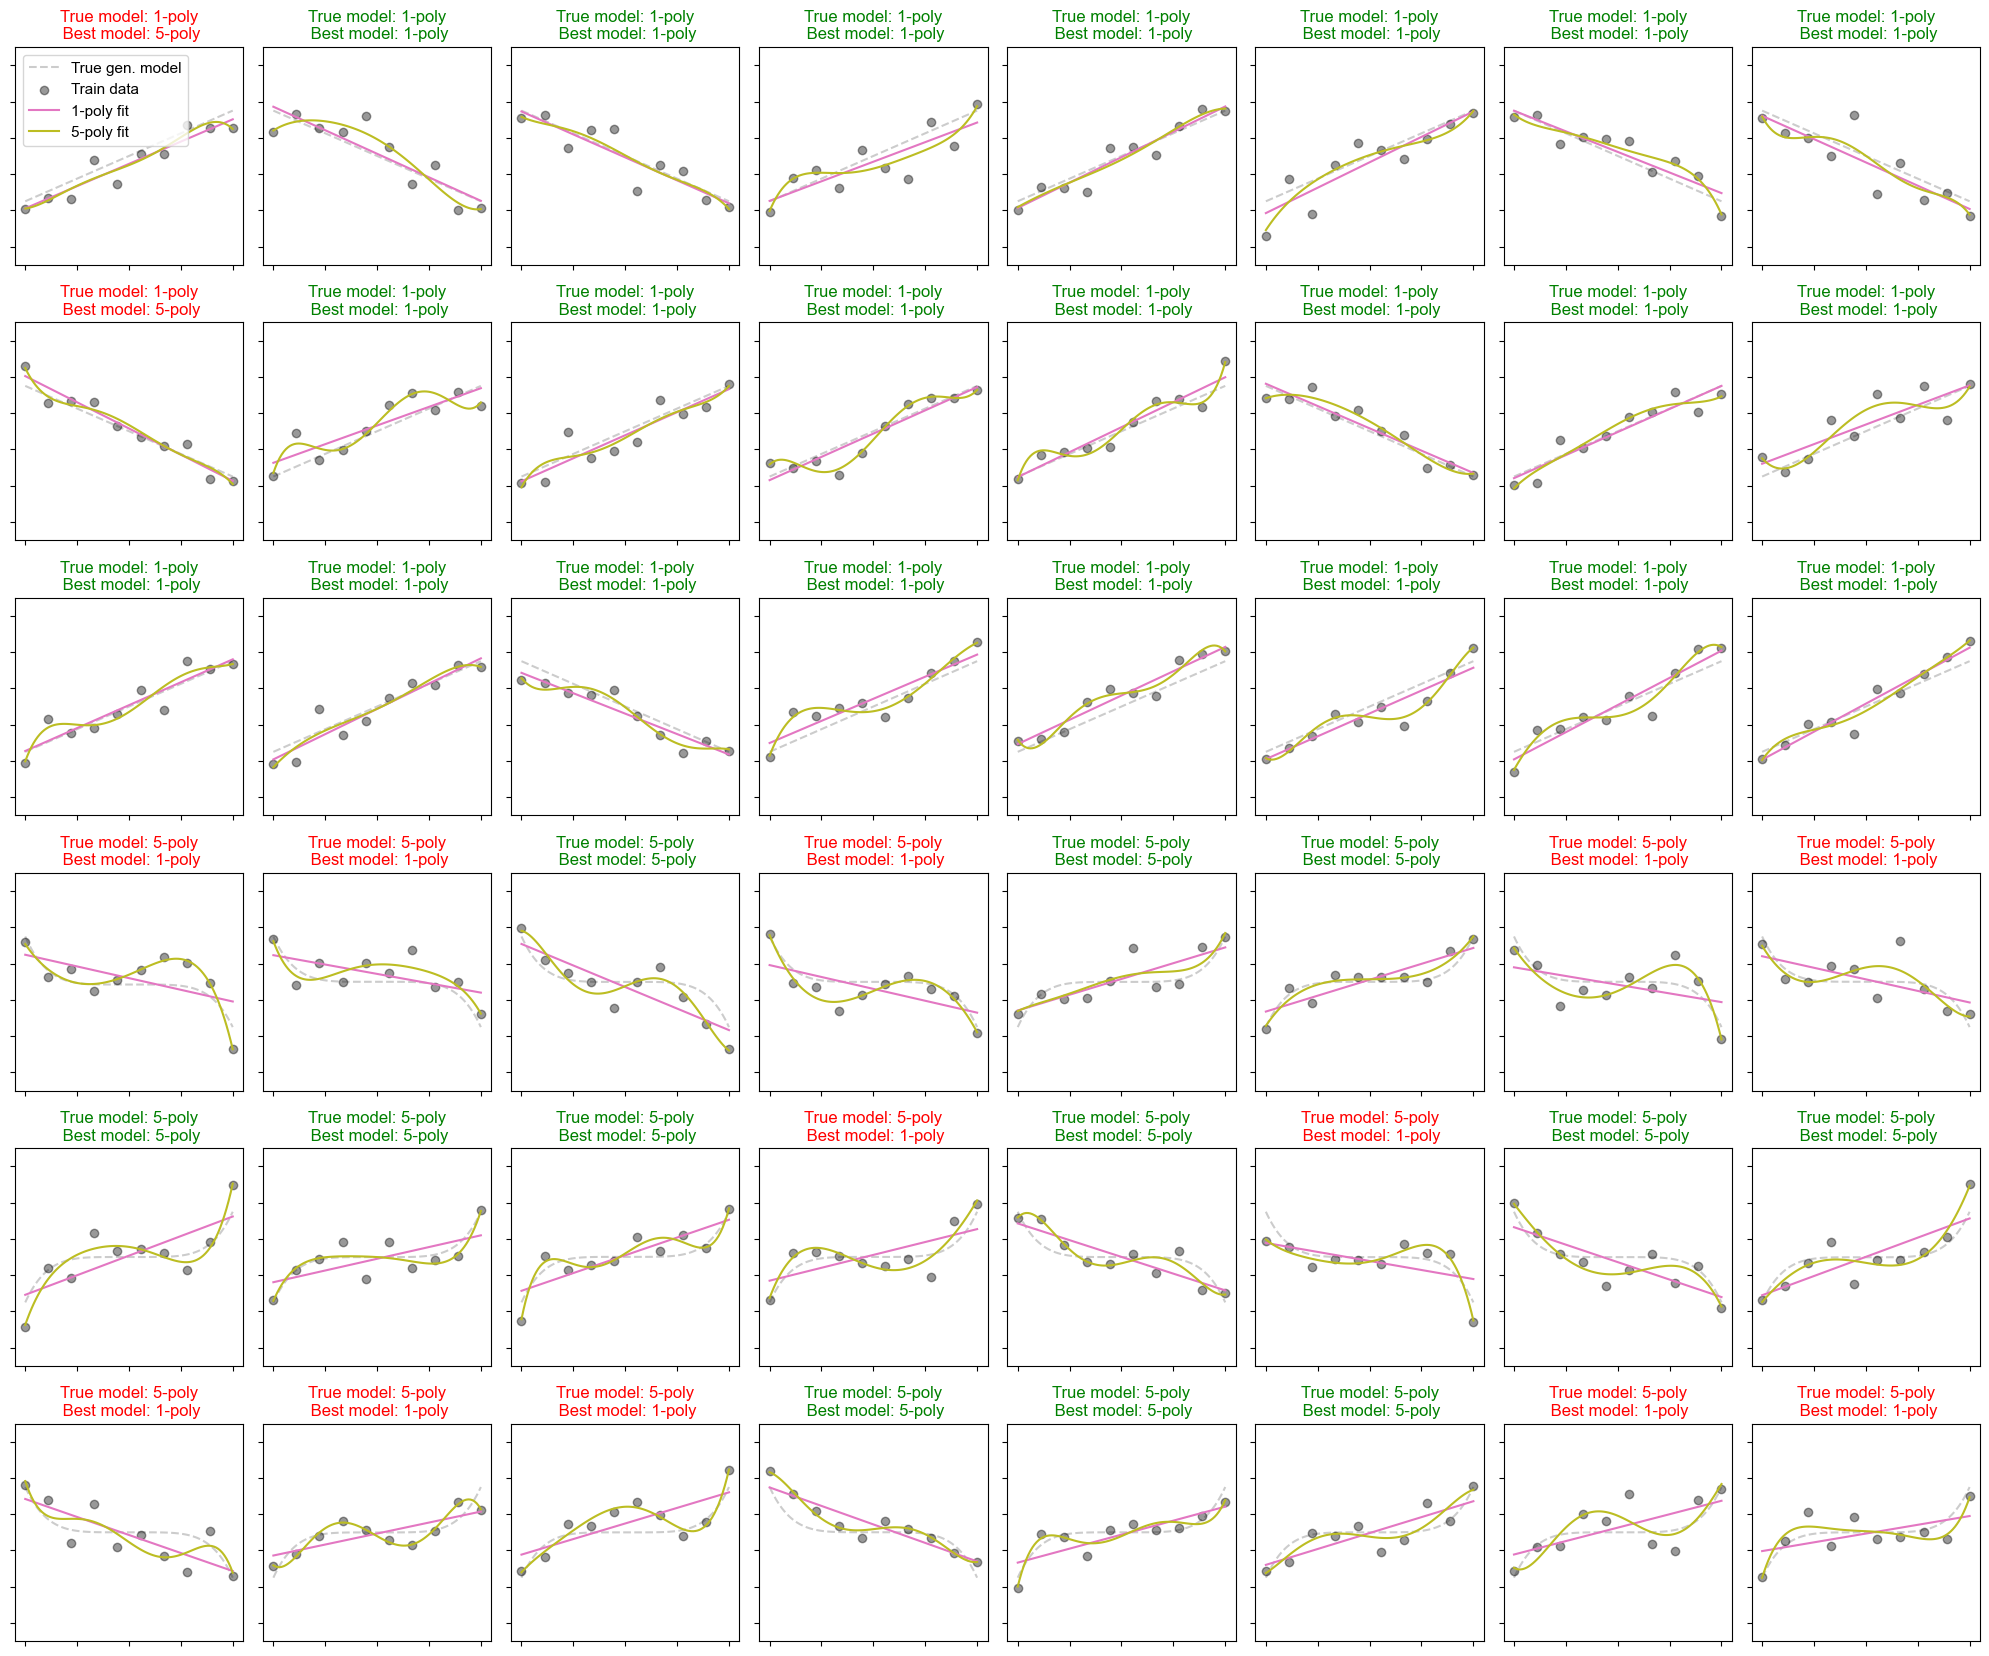

img_Ntrain1050 50
Figure_stimuli_d0_n50


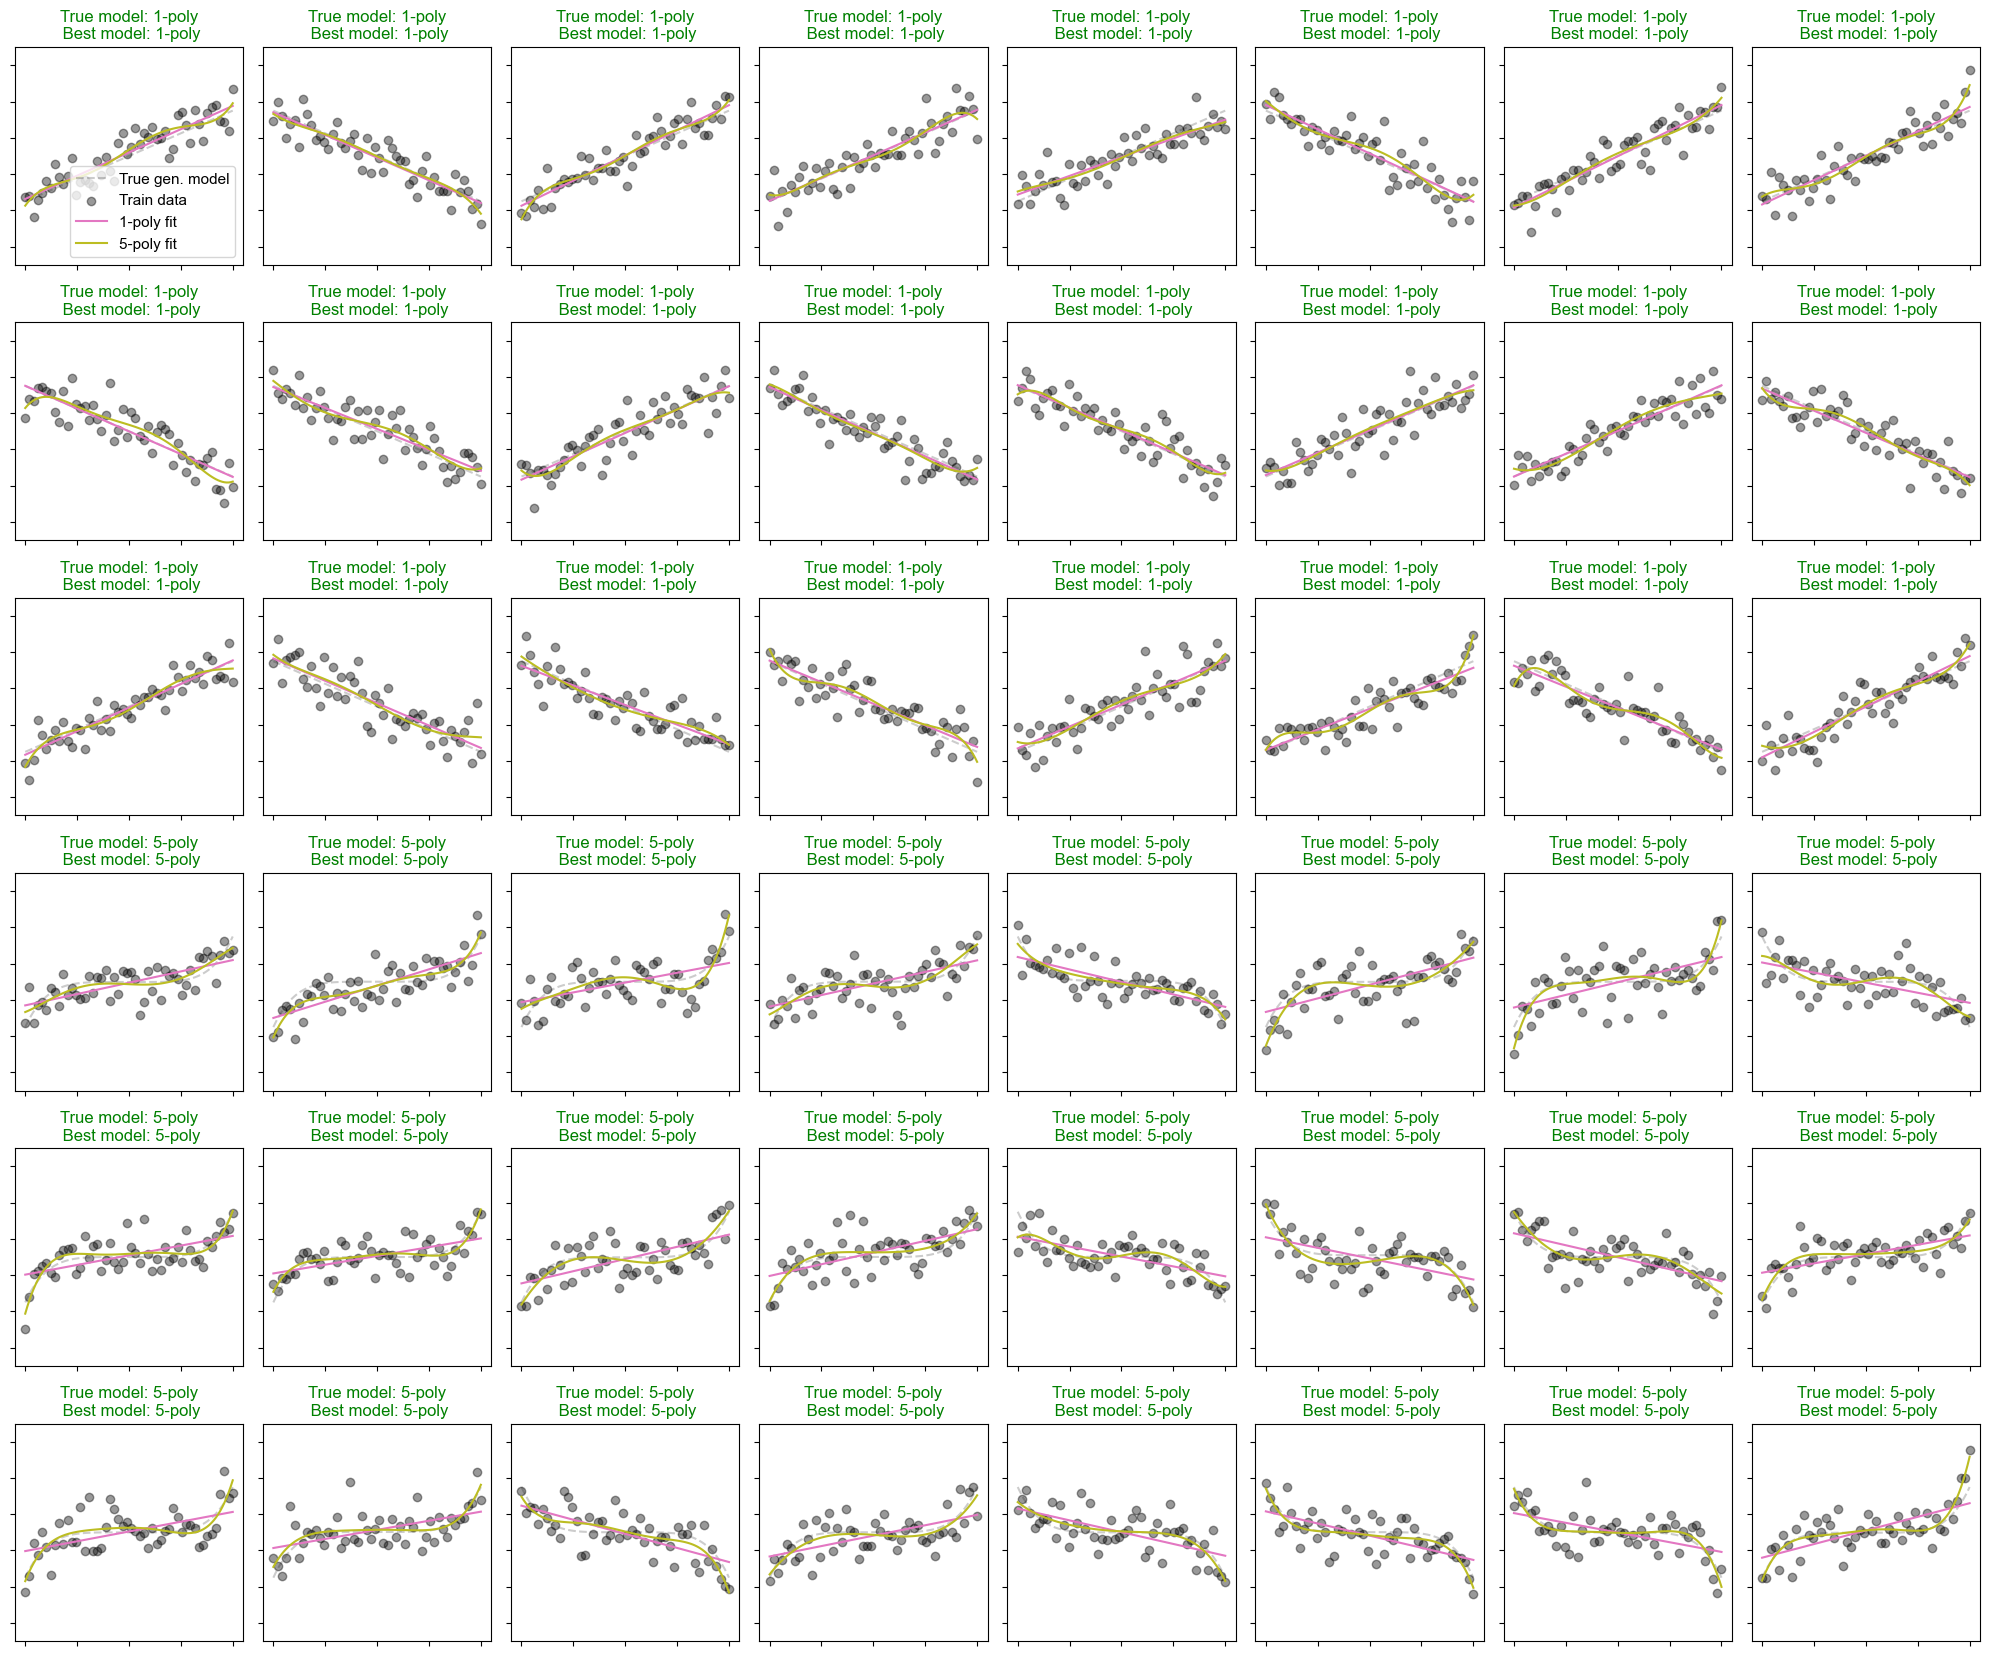

img_Ntrain1050_largenoise 10
Figure_stimuli_d1_n10


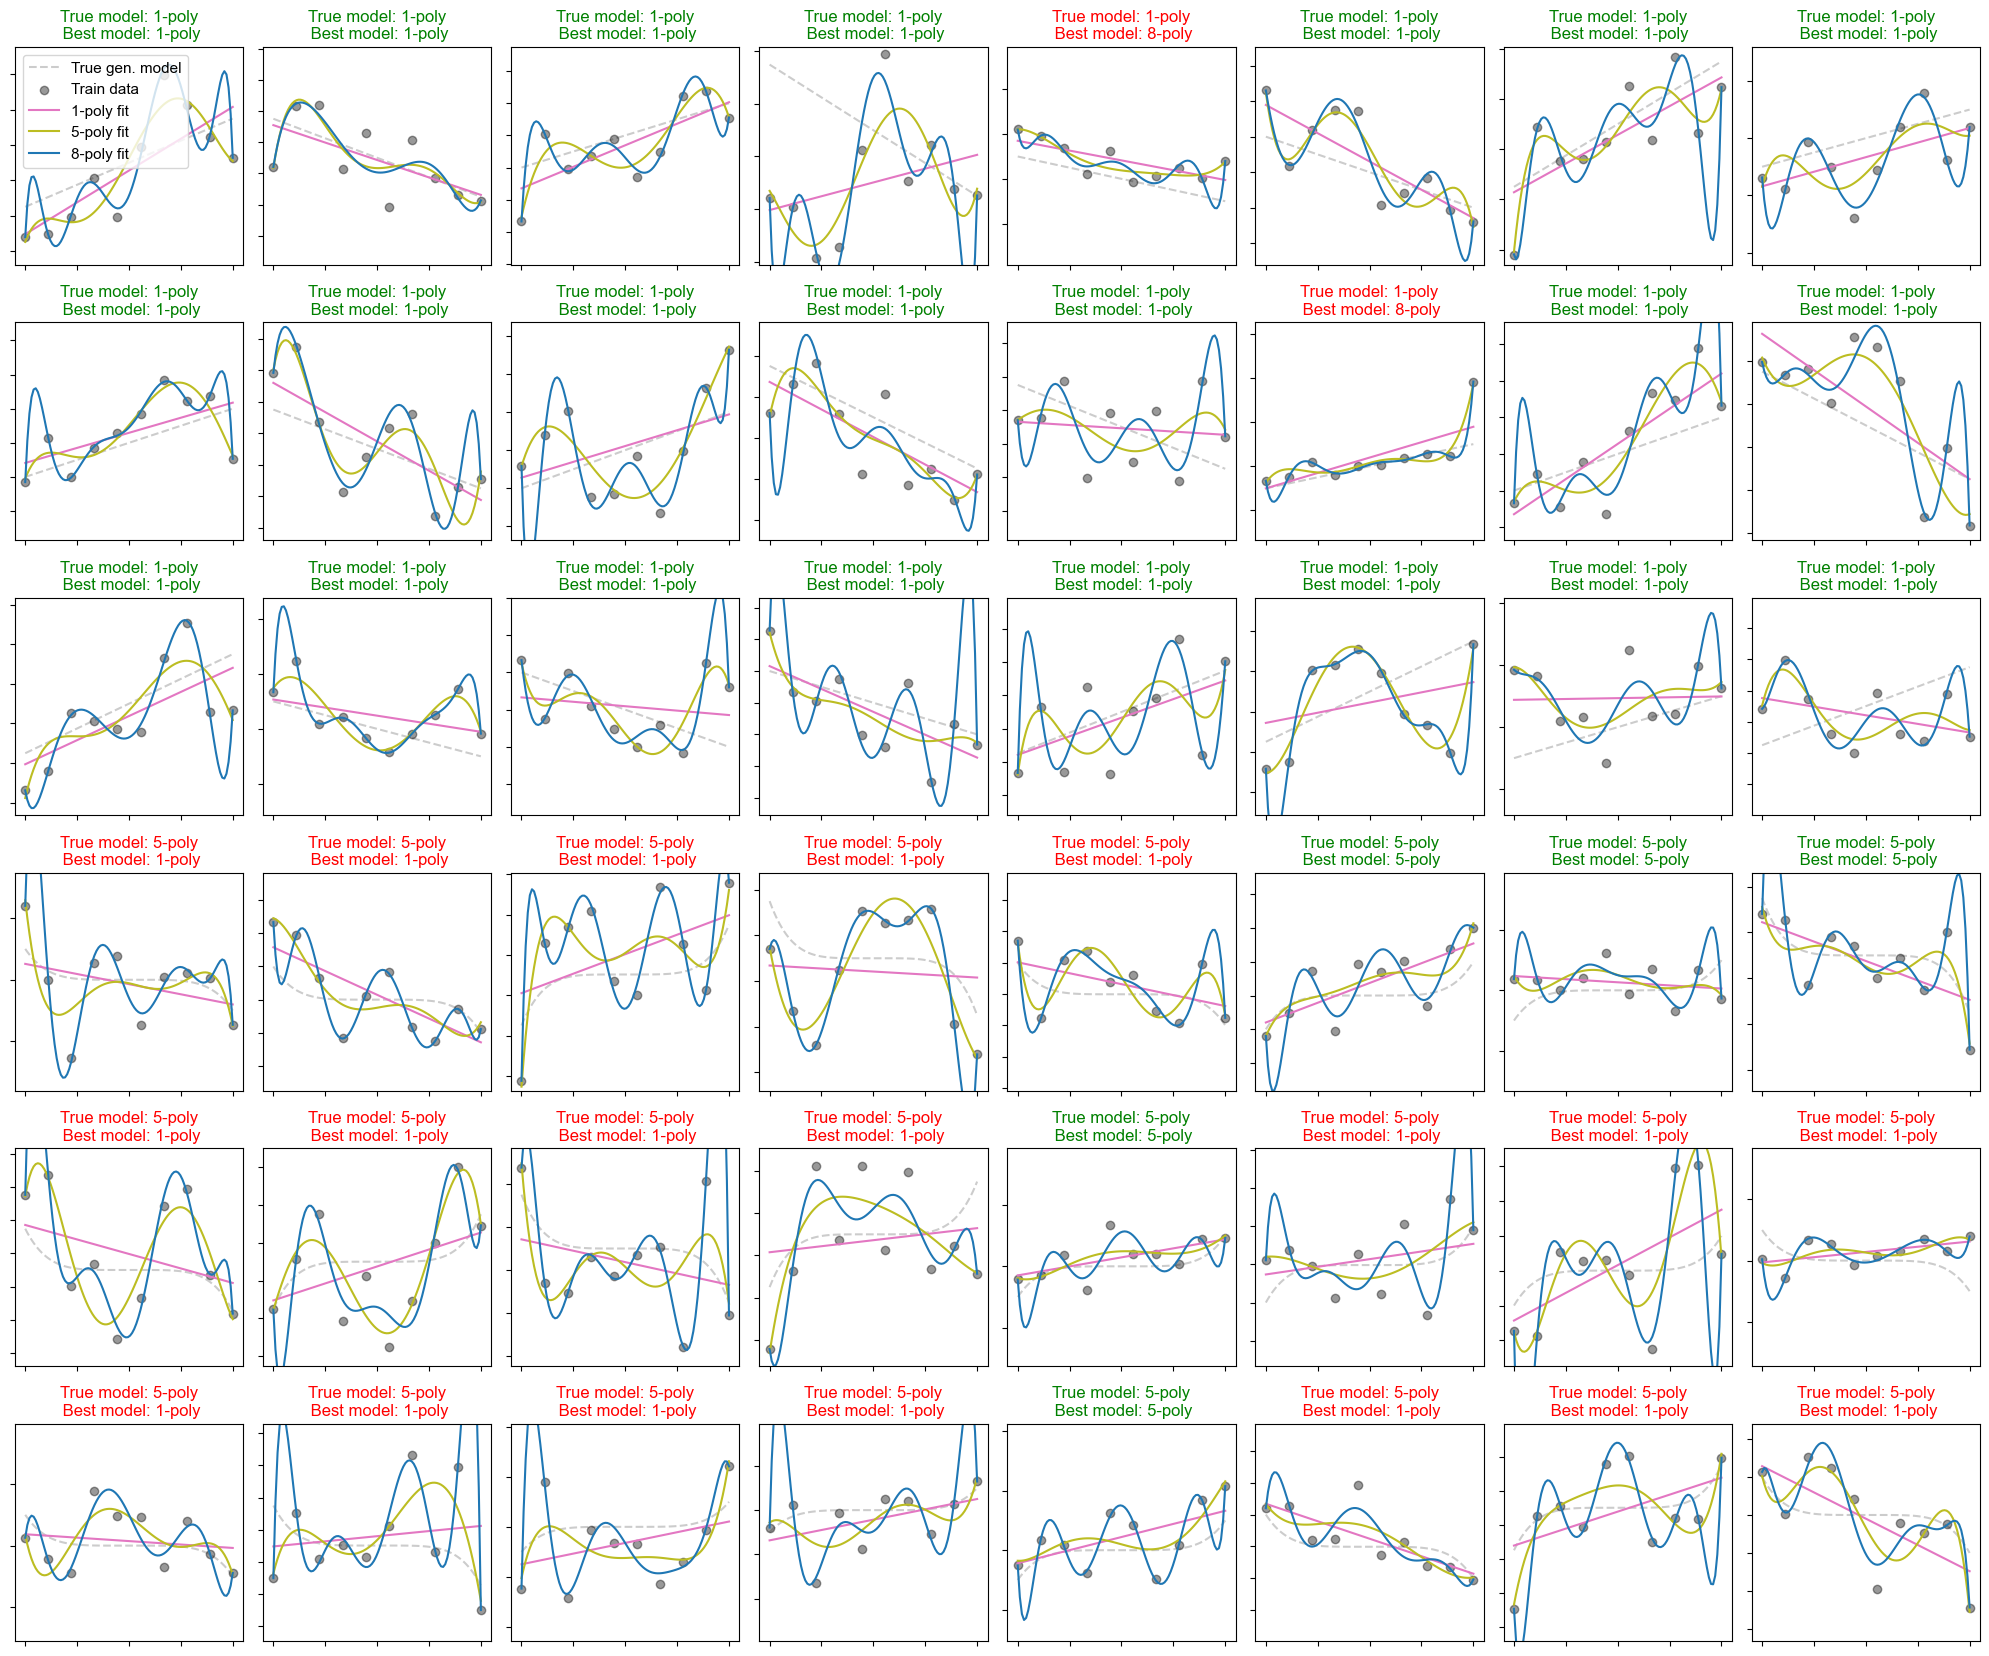

img_Ntrain1050_largenoise 50
Figure_stimuli_d1_n50


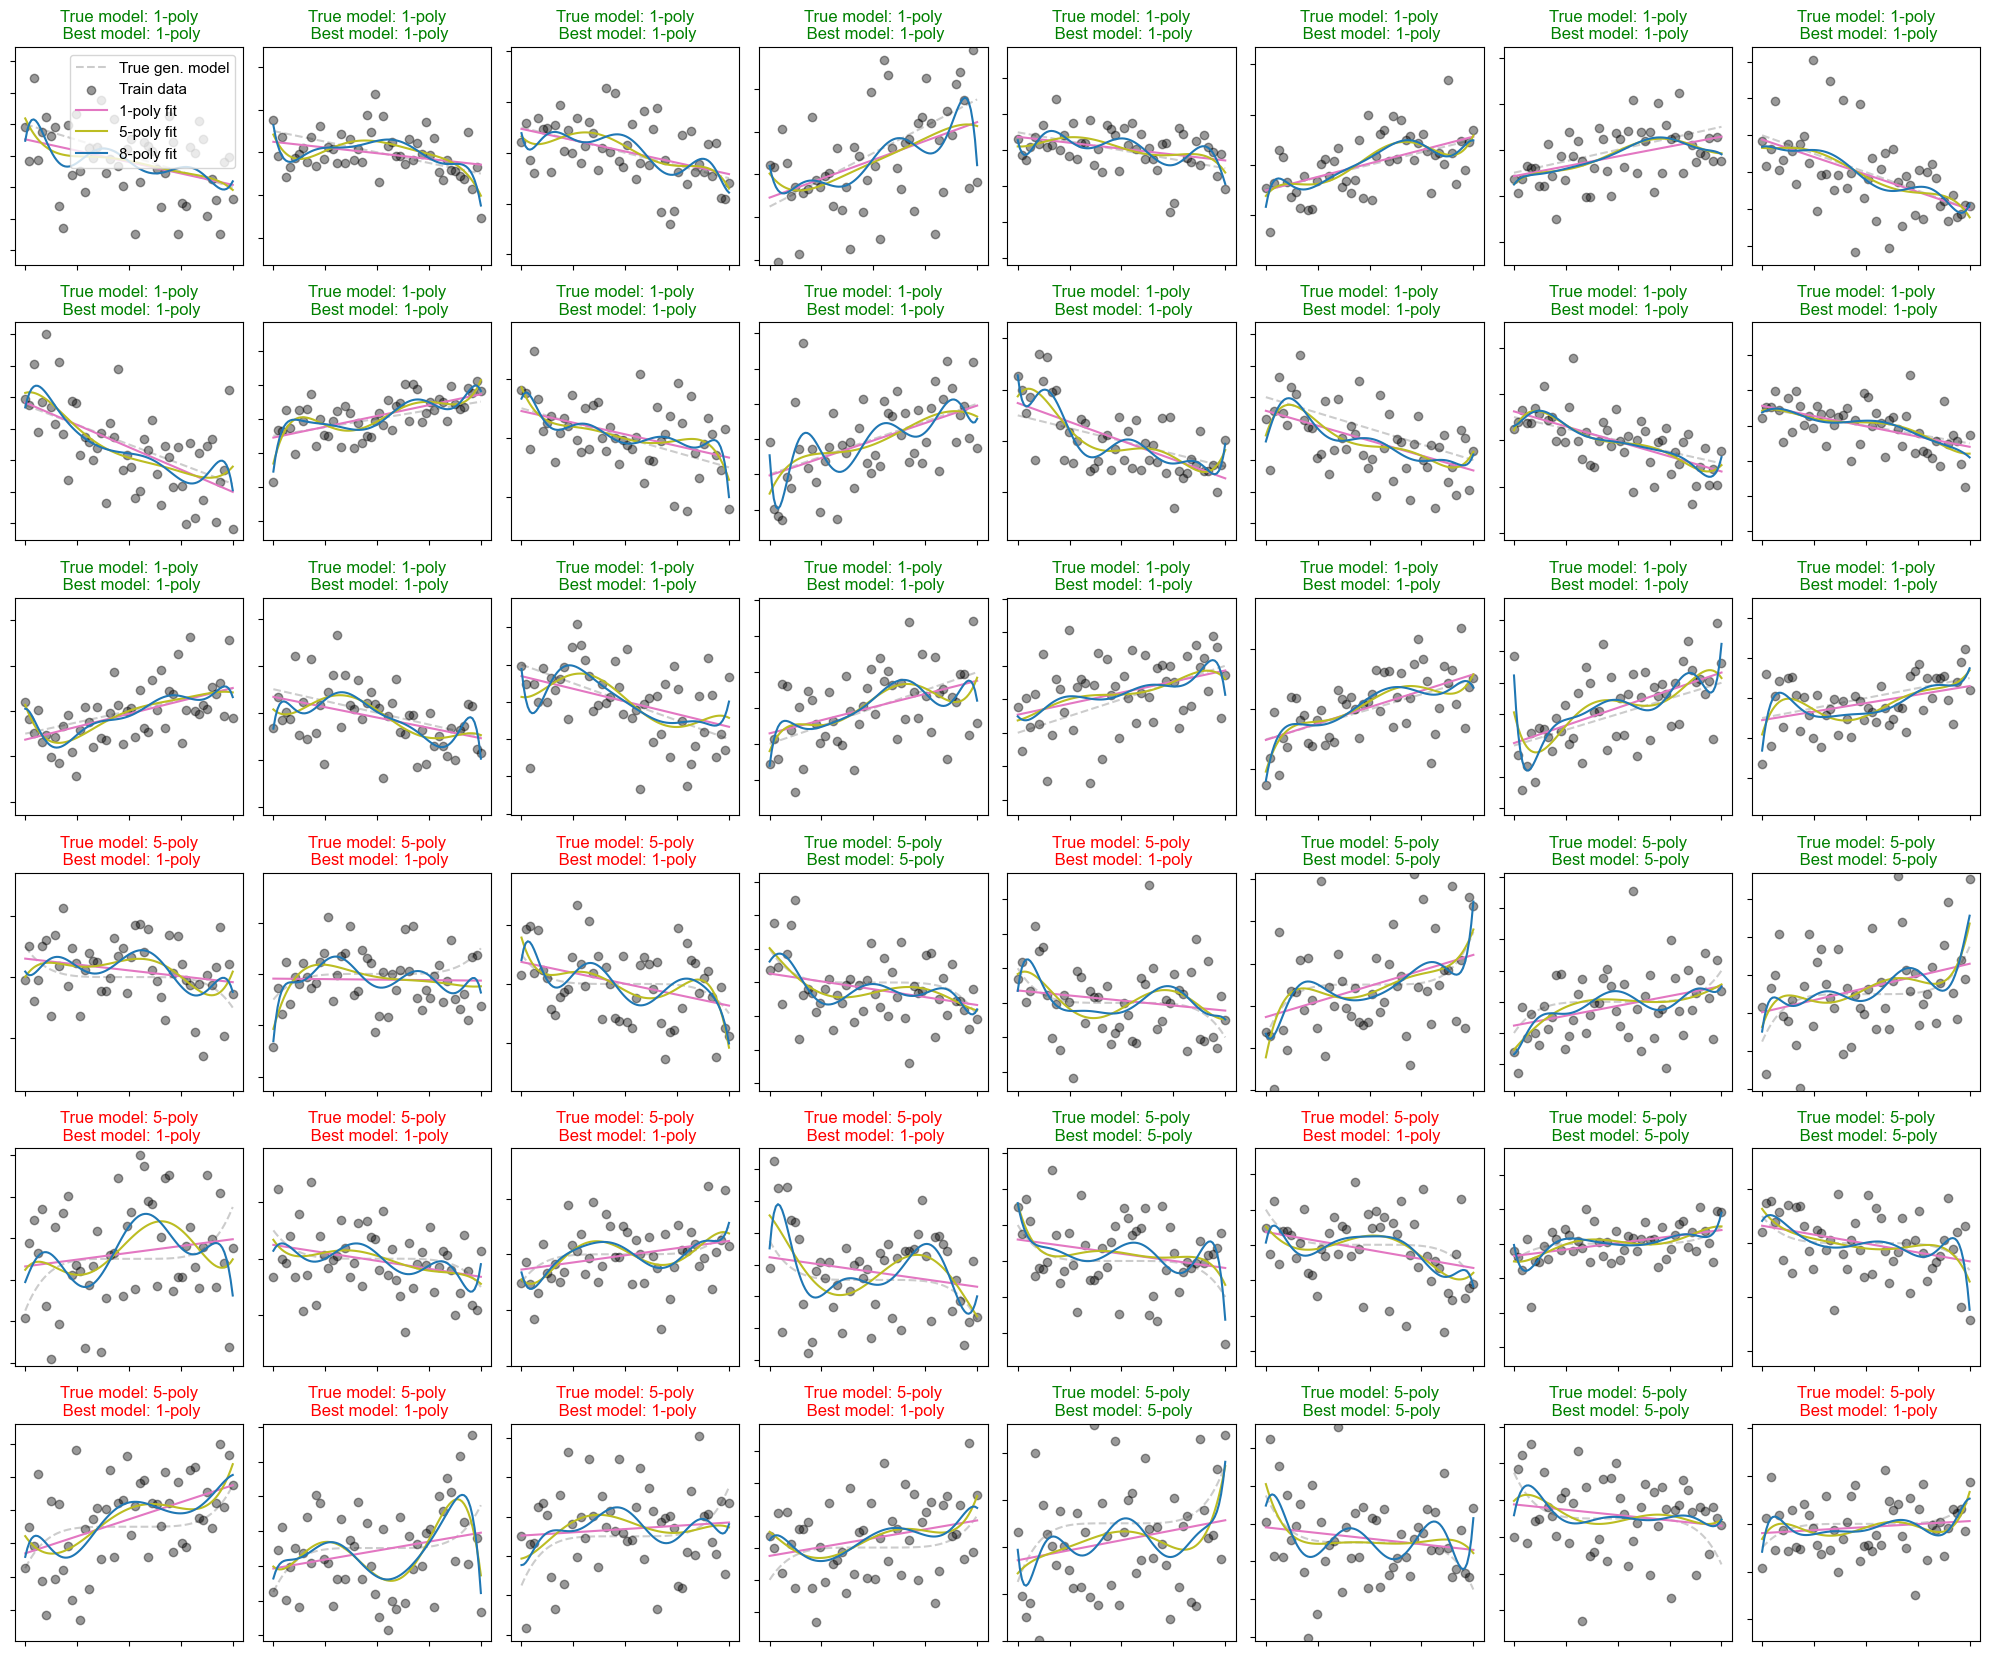

In [20]:
plt.rcParams['axes.labelsize'] = 12 # Set a global default label size

# Parameter generator
def generate_parameters(family):
    if family == "linear":
        return np.random.uniform(-10, 10, size=2)   # a, b
    elif family == "five_poly":
        return np.random.uniform(-10, 10, size=6)   # a, b, c, d, e, f

# Data‐generation
def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

# Collect results
sample_sizes = [10,50]
results = []
training_range = [-1000,1000]
test_range = training_range
x_curve = np.linspace(training_range[0], test_range[1], 100)
dpt_columns = ["x_train","y_train"]

n_rows=6
n_cols=8
n_trials = 96

# 0) Load dataset
datasets = ["img_Ntrain1050", "img_Ntrain1050_largenoise"]
for dataset_idx, dataset in enumerate(datasets):
    df_stimuli = pd.read_csv(os.path.join("..","experiment",dataset, "stimuli.csv"))
    for col in dpt_columns: # Convert string arrays into Numpy arrays
        df_stimuli = convert_strarray_column_to_numpy(df_stimuli, col)
    x_trains = df_stimuli["x_train"]
    y_trains = df_stimuli["y_train"]
    ymins = df_stimuli["ymin"]
    ymaxs = df_stimuli["ymax"]
    true_paramss = df_stimuli[["param"+str(i) for i in range(1,7)]]
    true_families = df_stimuli["ground_truth"]
    MSE_bestmodels = df_stimuli["best_model_MSE"]

    subplot_count = 0
    n_train_idx = 0
    for trial in range(n_trials):
        if(subplot_count==0):
            print(dataset, sample_sizes[n_train_idx])
            fig, ax = plt.subplots(n_rows, n_cols,figsize=(20,20/3*2.5))
        x_train = x_trains.iloc[trial]
        y_train = y_trains.iloc[trial]
        ymin = ymins.iloc[trial]
        ymax = ymaxs.iloc[trial]
        true_params = true_paramss.iloc[trial,:].to_numpy()
        true_family = true_families.iloc[trial]
        MSE_bestmodel = MSE_bestmodels.iloc[trial]
        y_grid_true = generate_data(x_curve, true_params, true_family)
        y_grid_true = (y_grid_true - ymin)/(ymax-ymin)


        # Fit linear model
        lin_model = make_pipeline(
            MinMaxScaler(feature_range=(-1, 1)),
            LinearRegression()
        ).fit(x_train.reshape(-1,1), y_train)

        # Fit 5th‐degree polynomial
        fivepoly_model = make_pipeline(
            MinMaxScaler(feature_range=(-1, 1)),
            PolynomialFeatures(degree=5, include_bias=False),
            LinearRegression()
        ).fit(x_train.reshape(-1,1), y_train)

        # Fit 8th‐degree polynomial
        if(dataset_idx==1):
            eightpoly_model = make_pipeline(
                MinMaxScaler(feature_range=(-1, 1)),
                PolynomialFeatures(degree=8, include_bias=False),
                LinearRegression()
            ).fit(x_train.reshape(-1,1), y_train)


        # Plot
        x_curve = np.linspace(training_range[0], test_range[1], 100)
        y_curve_lin  = lin_model.predict(x_curve.reshape(-1,1))
        y_curve_fivepoly = fivepoly_model.predict(x_curve.reshape(-1,1))
        y_curve_eightpoly = eightpoly_model.predict(x_curve.reshape(-1,1))

        ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_grid_true, "k--", alpha=0.2, label="True gen. model")
        ax[subplot_count//n_cols, subplot_count%n_cols].scatter(x_train, y_train, color="k", alpha=0.4, label="Train data")
        ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_lin, color="C6", alpha=1, label="1-poly fit")
        ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_fivepoly, color="C8", alpha=1, label="5-poly fit")
        if(dataset_idx==1):
            ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_eightpoly, color="C10", alpha=1, label="8-poly fit")
        if(true_family==MSE_bestmodel):
            title_color = "g"
        else:
            title_color = "r"
        family_dict = {"linear":"1-poly","five_poly": "5-poly","eight_poly": "8-poly"}
        ax[subplot_count//n_cols, subplot_count%n_cols].set_title(f"True model: {family_dict[true_family]}\n Best model: {family_dict[MSE_bestmodel]}", color=title_color)
        ax[subplot_count//n_cols, subplot_count%n_cols].set_xlim(-1100,1100)
        if(dataset_idx==0):
            ymin_disp = -0.1
            ymax_disp = 1.1
        elif(dataset_idx==1):
            ymin_disp = y_train.min() - 2*np.abs(y_train.min())
            ymax_disp = y_train.max() + 2*np.abs(y_train.min())
        ax[subplot_count//n_cols, subplot_count%n_cols].set_ylim(ymin_disp, ymax_disp)
        ax[0,0].legend()
        ax[subplot_count//n_cols, subplot_count%n_cols].set_xticklabels([])
        ax[subplot_count//n_cols, subplot_count%n_cols].set_yticklabels([])
        subplot_count = subplot_count+1
        #fig.suptitle("N_train = {0}, N_test = {1}, interpolation".format(training_n, test_n))
        fig.tight_layout()


        if(trial==(n_rows*n_cols-1) or trial==(2*n_rows*n_cols-1)):
            print("Figure_stimuli_d"+str(dataset_idx)+"_n"+str(sample_sizes[n_train_idx]))
            #plt.savefig(os.path.join(figpath, "Figure_stimuli_d"+str(dataset_idx)+"_n"+str(sample_sizes[n_train_idx])+".png"), dpi=300)
            plt.savefig(os.path.join(figpath, "Figure_stimuli_d"+str(dataset_idx)+"_n"+str(sample_sizes[n_train_idx])+".pdf"), format="pdf")
            plt.show()
            subplot_count = 0
            n_train_idx = n_train_idx + 1
plt.rcParams['axes.labelsize'] = 14 # Set a global default label size

# Violin plots

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from scipy import stats


def annotate_violin_significance(
    ax,
    df,
    x, y,
    hue=None,
    test="t",             # "t" for one-sample t-test, "wilcoxon" for signed-rank
    mu=0,
    show="stars",         # "stars" or "p"
    fmt="%.4g",           # format for p-values if show="p"
    y_offset=0.02,        # vertical offset (in data units) above each violin
    min_height_pad=0.1,  # extra padding if the violin's top is close to max data
    zero_method="wilcox", # for Wilcoxon: "wilcox" (default) or "pratt"
    alternative="two-sided",
    width=0.8,            # fallback assumed total category width for dodge calc
    debug=False
):
    """
    Robustly annotate a seaborn violinplot (with or without hue) with significance vs. mu.

    The function finds the actual violin centers from PolyCollections, groups them
    by the nearest x-tick (category center), sorts left→right within each category,
    and aligns that order to the hue order used in the legend (or data) so labels
    sit on the correct violin.

    Parameters are the same as before; `width` is used only as a fallback when the
    center-detection doesn't return exactly one center per hue within a category.
    """

    def infer_levels(series):
        if isinstance(series.dtype, pd.CategoricalDtype):
            return list(series.cat.categories)
        vals = series.dropna().unique().tolist()
        try:
            return sorted(vals)
        except Exception:
            return vals

    def p_to_stars(p):
        if p < 1e-4: return "****"
        if p < 1e-3: return "***"
        if p < 1e-2: return "**"
        if p < 5e-2: return "*"
        return "n.s."

    # 1) Establish plotting order for x (from ticks) and hue (from legend if available)
    # X order from tick labels (most reliable wrt seaborn’s category order)
    xticks = np.array(ax.get_xticks())
    xticklabels = [t.get_text() for t in ax.get_xticklabels()]
    if any(lbl != "" for lbl in xticklabels) and len(xticklabels) == len(xticks):
        x_levels = xticklabels
        to_str = lambda v: str(v)
        # Map original df[x] values to their string form for matching
        # Build a resolver that maps string label -> original level if possible
        unique_x_vals = list(dict.fromkeys(df[x].dropna().tolist()))
        x_resolver = {str(v): v for v in unique_x_vals}
        x_levels_resolved = [x_resolver.get(lbl, lbl) for lbl in x_levels]
        x_levels = x_levels_resolved
    else:
        x_levels = infer_levels(df[x])
        # Assume categories laid out at 0..n-1 if ticks are missing
        xticks = np.arange(len(x_levels))

    # Hue order: try legend labels first (they reflect plotting order)
    if hue is None:
        hue_levels = [None]
    else:
        hue_levels = infer_levels(df[hue])
        try:
            _, leglabels = ax.get_legend_handles_labels()
            # Keep only labels that appear in the actual data (string match)
            data_hue_str = {str(v) for v in df[hue].dropna().unique().tolist()}
            leglabels = [lab for lab in leglabels if lab in data_hue_str]
            if len(leglabels) == len(hue_levels):
                # Map legend strings back to original dtype values when possible
                hue_map = {str(v): v for v in df[hue].dropna().unique().tolist()}
                hue_levels = [hue_map.get(lab, lab) for lab in leglabels]
        except Exception:
            pass

    n_x = len(x_levels)
    n_h = len(hue_levels)

    # 2) Detect violin centers & tops from PolyCollections and group by nearest x-tick
    polys = [c for c in ax.findobj(PolyCollection)]
    # Build structure: for each x-index, dict {center_x (rounded): top_y}
    centers_by_x = [dict() for _ in range(n_x)]

    for poly in polys:
        paths = getattr(poly, "get_paths", lambda: [])()
        if not paths:
            continue
        # Many violins are a single path; take the first
        verts = paths[0].vertices
        if verts.size == 0:
            continue
        cx = float(np.mean(verts[:, 0]))
        ty = float(np.max(verts[:, 1]))
        # Assign to nearest category tick
        x_idx = int(np.argmin(np.abs(xticks - cx)))
        # De-duplicate centers (two halves of a violin share same center)
        key = round(cx, 6)
        centers_by_x[x_idx][key] = max(ty, centers_by_x[x_idx].get(key, -np.inf))

    # 3) Build a mapping {(x_level, hue_level) -> (center_x, top_y)}
    center_map = {}
    top_map = {}
    for xi, xv in enumerate(x_levels):
        # Sorted center positions left→right actually present near this x
        present_centers = sorted(centers_by_x[xi].items(), key=lambda kv: kv[0])
        if len(present_centers) == n_h:
            # Perfect: map left→right to hue_levels order
            for hj, hv in enumerate(hue_levels):
                cx, ty = present_centers[hj]
                center_map[(xv, hv)] = cx
                top_map[(xv, hv)] = ty
        else:
            # Fallback: approximate dodge positions around the tick center
            if debug:
                print(f"[annotate_violin_significance] Fallback at x={xv}: "
                      f"found {len(present_centers)} centers, expected {n_h}.")
            tick_center = xticks[xi]
            # equally spaced within total width
            offsets = np.linspace(-width/2 + width/(2*n_h),
                                   width/2 - width/(2*n_h),
                                   n_h) if n_h > 1 else np.array([0.0])
            # Use global top from data (safer than violin height when falling back)
            ty_guess = df.loc[df[x] == xv, y].max()
            for hj, hv in enumerate(hue_levels):
                center_map[(xv, hv)] = tick_center + offsets[hj]
                top_map[(xv, hv)] = float(ty_guess)

    # 4) Run one-sample tests per (x,hue) and annotate exactly at that center
    global_y_max = float(np.nanmax(df[y].values))

    annotations = []
    for xv in x_levels:
        for hv in hue_levels:
            if hue is None:
                mask = (df[x] == xv)
            else:
                mask = (df[x] == xv) & (df[hue] == hv)
            group = df.loc[mask, y].dropna().values

            if group.size == 0:
                pval = np.nan
            else:
                if test.lower() in ["t", "ttest", "t-test", "onesample", "one-sample"]:
                    res = stats.ttest_1samp(group, popmean=mu, alternative=alternative)
                    pval = res.pvalue
                    bf10 = pingouin.bayesfactor_ttest(t=res.statistic, nx=len(group), paired=False)
                    print("paired t-test p={0:.10f}, BF10={1}".format(pval, bf10))
                elif test.lower() in ["wilcoxon", "signed-rank", "wilcox"]:
                    diffs = group - mu
                    if np.allclose(diffs, 0):
                        pval = 1.0
                    else:
                        res = stats.wilcoxon(diffs, zero_method=zero_method,
                                             alternative=alternative, method="auto")
                        pval = res.pvalue
                else:
                    raise ValueError("test must be 't' or 'wilcoxon'")

            annotations.append((xv, hv, pval))

    for xv, hv, pval in annotations:
        cx = center_map[(xv, hv)]
        ty = top_map[(xv, hv)]
        y_text = max(ty + y_offset, global_y_max + min_height_pad)

        if np.isnan(pval):
            label = "n/a"
        else:
            label = p_to_stars(pval) if show == "stars" else f"p={fmt % pval}"

        ax.text(cx, y_text, label,
                ha="center", va="bottom", fontsize=10, clip_on=False)

    # Ensure room for labels
    ax.set_ylim(bottom=ax.get_ylim()[0],
                top=max(ax.get_ylim()[1], global_y_max + 0.08))

    return ax



import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from scipy import stats

def annotate_paired_violin_significance(
    ax,
    df,
    x, y,
    hue,
    id_col,                 # required: subject/ID column used to make pairs
    test="t",               # "t" (paired t) or "wilcoxon" (signed-rank)
    show="stars",           # "stars" or "p"
    fmt="%.2g",             # p-value format when show="p"
    y_offset=0.1,          # vertical offset above the taller violin (data units)
    min_height_pad=0.1,    # min padding over global max if needed
    zero_method="wilcox",   # Wilcoxon zero handling: "wilcox" (default) or "pratt"
    alternative="two-sided",
    compare_hues=None,      # tuple/list like ("6","10") to force comparison order
    bracket_width_pad=0.03, # small horizontal pad so bracket ends extend slightly past centers
    bracket_thickness=1.5,  # line width for the bracket
    cap_height=0.05,        # small vertical caps at ends of bracket
    font_size=10,           # label text size
):
    """
    For each x level, compare the two hue groups with a paired test and draw a bracket.

    Assumes exactly two hue levels per x (or specify `compare_hues`).
    Pairs are formed by matching rows with the same `id_col` within each (x, hue).

    Example:
      sns.violinplot(data=df, x="experiment", y="metric", hue="N_train", ax=ax, fill=False)
      annotate_paired_violin_significance(ax, df, x="experiment", y="metric",
                                          hue="N_train", id_col="Subject", test="wilcoxon")
    """

    # --- helpers ---
    def infer_levels(series):
        if isinstance(series.dtype, pd.CategoricalDtype):
            return list(series.cat.categories)
        vals = series.dropna().unique().tolist()
        try:
            return sorted(vals)
        except Exception:
            return vals

    def p_to_stars(p):
        if p < 1e-4: return "****"
        if p < 1e-3: return "***"
        if p < 1e-2: return "**"
        if p < 5e-2: return "*"
        return "n.s."

    # Resolve plotting order to match seaborn's drawing order (x outer, hue inner)
    x_levels = infer_levels(df[x])
    hue_levels = infer_levels(df[hue])

    if compare_hues is None:
        if len(hue_levels) != 2:
            raise ValueError("Need exactly two hue levels or specify `compare_hues=(h1, h2)`.")
        compare_hues = (hue_levels[0], hue_levels[1])
    else:
        if len(compare_hues) != 2:
            raise ValueError("`compare_hues` must be a pair, e.g., ('A','B').")

    # Grab the violin bodies in the axes, in seaborn's draw order
    poly_bodies = [c for c in ax.collections if isinstance(c, PolyCollection)]
    n_expected = len(x_levels) * len(hue_levels)
    if len(poly_bodies) < n_expected:
        # Sometimes there are split artists; be defensive
        poly_bodies = poly_bodies[:n_expected]

    # Build a table of (center_x, top_y) for each (x_i, hue_j) in draw order
    centers = {}
    tops = {}
    k = 0
    for xi, xv in enumerate(x_levels):
        for hj, hv in enumerate(hue_levels):
            if k >= len(poly_bodies):
                continue
            poly = poly_bodies[k]
            k += 1
            # Each violin usually has a single path; take its center and top
            try:
                verts = poly.get_paths()[0].vertices
            except Exception:
                continue
            cx = np.mean(verts[:, 0])
            ty = np.max(verts[:, 1])
            centers[(xv, hv)] = cx
            tops[(xv, hv)] = ty

    # Global y range (for padding if violins touch the top)
    global_y_max = np.nanmax(df[y].values)

    # Compute paired tests per x level and annotate
    for xv in x_levels:
        # Form pairs by ID for the two hue levels at this x
        a_level, b_level = compare_hues

        gA = df.loc[(df[x] == xv) & (df[hue] == a_level), [id_col, y]].dropna()
        gB = df.loc[(df[x] == xv) & (df[hue] == b_level), [id_col, y]].dropna()

        if gA.empty or gB.empty:
            pval = np.nan
        else:
            # Align by subject ID (inner join)
            merged = pd.merge(gA, gB, on=id_col, suffixes=("__A", "__B"))
            A = merged[f"{y}__A"].values
            B = merged[f"{y}__B"].values

            # Need at least 1 pair; for Wilcoxon need at least one non-zero diff
            if len(A) == 0:
                pval = np.nan
            else:
                if test.lower() in ["t", "ttest", "paired_t", "paired-t", "ttest_rel"]:
                    res = stats.ttest_rel(A, B, alternative=alternative)
                    pval = res.pvalue
                elif test.lower() in ["wilcoxon", "signed-rank", "wilcox"]:
                    # scipy wilcoxon handles pairing directly
                    if np.allclose(A - B, 0):
                        pval = 1.0
                    else:
                        res = stats.wilcoxon(A, B,
                                             zero_method=zero_method,
                                             alternative=alternative,
                                             method="auto")
                        pval = res.pvalue
                else:
                    raise ValueError("test must be 't' (paired t) or 'wilcoxon' (signed-rank)")

        # Compute bracket position using the plotted violin centers/tops
        if (xv, a_level) not in centers or (xv, b_level) not in centers:
            # Skip if we can't find both violins (e.g., missing group)
            continue

        x1 = centers[(xv, a_level)]
        x2 = centers[(xv, b_level)]
        topA = tops[(xv, a_level)]
        topB = tops[(xv, b_level)]
        y_bracket = max(topA, topB) + y_offset
        y_bracket = max(y_bracket, global_y_max + min_height_pad)

        # Draw bracket ( ┌───┐ style with small caps )
        x_left  = min(x1, x2) - bracket_width_pad
        x_right = max(x1, x2) + bracket_width_pad

        # horizontal bar
        ax.plot([x_left, x_right], [y_bracket, y_bracket],
                lw=bracket_thickness, color="black", clip_on=False)
        # small vertical caps
        ax.plot([x_left, x_left],   [y_bracket, y_bracket - cap_height],
                lw=bracket_thickness, color="black", clip_on=False)
        ax.plot([x_right, x_right], [y_bracket, y_bracket - cap_height],
                lw=bracket_thickness, color="black", clip_on=False)

        # Label
        if np.isnan(pval):
            label = "n/a"
        else:
            label = p_to_stars(pval) if show == "stars" else f"p={fmt % pval}"

        ax.text((x_left + x_right) / 2.0,
                y_bracket + 0.005,
                label,
                ha="center", va="bottom",
                fontsize=font_size)

    # Make sure labels aren’t clipped
    ax.set_ylim(bottom=ax.get_ylim()[0],
                top=max(ax.get_ylim()[1], global_y_max + 0.08))

    return ax


Efron normative
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan
paired t-test p=0.0000000000, BF10=nan



C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:24: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", fill=False, ax=ax[plot_idx,0], legend=False, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:25: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,0], legend=False, dodge=True, jitter=0.2, palette=palette_exp)
C:\Users\liu_s\pyro_env2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\liu_s\pyro_env2\Lib\s

paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
paired t-test p=nan, BF10=nan
----------

Humans
paired t-test p=0.8223751895, BF10=0.15763276127178583
paired t-test p=0.0547713263, BF10=0.9079481660016512
paired t-test p=0.1553678479, BF10=0.4098432928471047
paired t-test p=0.0071067005, BF10=5.045953549426441
paired t-test p=0.7181972979, BF10=0.16379903877299362
paired t-test p=0.3645993596, BF10=0.22843062843084827
paired t-test p=0.2066983272, BF10=0.3341905840082935
paired t-test p=0.0143362912, BF10=2.761111061541227

paired t-test p=0.0000009631, BF10=16962.935871082205
paired t-test p=0.0000000000, BF10=1175942302079.748
paired t-test p=0.0000000000, BF10=37447183577.232735
paired t-test p=0.0000006982, BF10=22927.885097364226
paired t-test p=0.3276440673, BF10=0.24389366315916197
paired t-test p=0.0000000000, BF10=14

C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:33: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", fill=False, ax=ax[plot_idx,1], legend=False, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:34: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,1], legend=False, dodge=True, jitter=0.2, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:24: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", fill=False, ax=ax[plot_idx,0], legend=False, palette=palette_exp)
C:\Users\liu_s

paired t-test p=0.9242363066, BF10=0.1545305435321646
paired t-test p=0.0514293353, BF10=0.955149495889113
paired t-test p=0.1604009295, BF10=0.4004324622364754
paired t-test p=0.0083694731, BF10=4.380213370550963
paired t-test p=0.6951717472, BF10=0.16564526591379586
paired t-test p=0.4706843874, BF10=0.1975909639877516
paired t-test p=0.2012229953, BF10=0.3405287336147002
paired t-test p=0.0149270511, BF10=2.6678984515276833



C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:34: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,1], legend=False, dodge=True, jitter=0.2, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:24: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", fill=False, ax=ax[plot_idx,0], legend=False, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:25: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,0], legend=False, dodge=True, jitter=0.2, 

paired t-test p=0.0000018958, BF10=9003.62316966916
paired t-test p=0.0000000000, BF10=1689915223819.6248
paired t-test p=0.0000000000, BF10=34024778684.310333
paired t-test p=0.0000003739, BF10=41202.73457154355
paired t-test p=0.3081107680, BF10=0.2535299868109496
paired t-test p=0.0000000000, BF10=1460922128.2669683
paired t-test p=0.0000000000, BF10=1595842838668.508
paired t-test p=0.0000000000, BF10=2465661674.339225
----------

Coarse Model
paired t-test p=0.4465454741, BF10=0.20328004531323518
paired t-test p=0.0458513990, BF10=1.0481279723739099
paired t-test p=0.1618831340, BF10=0.3977652906427308
paired t-test p=0.0083278778, BF10=4.399097995345324
paired t-test p=0.2825796125, BF10=0.26806242198198965
paired t-test p=0.4445160132, BF10=0.203788125338091
paired t-test p=0.2388869664, BF10=0.30249490674499957
paired t-test p=0.0198832830, BF10=2.093275131818087



C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:33: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", fill=False, ax=ax[plot_idx,1], legend=False, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:34: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,1], legend=False, dodge=True, jitter=0.2, palette=palette_exp)


paired t-test p=0.0000000545, BF10=252832.68464128987
paired t-test p=0.0000000000, BF10=1600284351318.0835
paired t-test p=0.0000000000, BF10=30363606899.449444
paired t-test p=0.0000002716, BF10=55637.74314094841
paired t-test p=0.0999177094, BF10=0.5657658235076455
paired t-test p=0.0000000000, BF10=1673065683.191136
paired t-test p=0.0000000000, BF10=1428452826416.0427
paired t-test p=0.0000000000, BF10=3345985697.128269
----------

Null Model
paired t-test p=0.3456167366, BF10=0.23596703630611465
paired t-test p=0.0104486799, BF10=3.618443706093235
paired t-test p=0.3970520204, BF10=0.21921615240215667
paired t-test p=0.0110073742, BF10=3.460283340267115
paired t-test p=0.2521819880, BF10=0.28902556937877644
paired t-test p=0.6718030284, BF10=0.16772502119308755
paired t-test p=0.0605182047, BF10=0.845273112030137
paired t-test p=0.0058235687, BF10=5.9987811044897335



C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:24: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", fill=False, ax=ax[plot_idx,0], legend=False, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:25: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,0], legend=False, dodge=True, jitter=0.2, palette=palette_exp)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_3720\2496933177.py:33: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g=sns.violinplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", fill=False, ax=ax[plot_idx,1], legend=False, palette=palette_exp)
C:\User

paired t-test p=0.0000000257, BF10=515012.8641194412
paired t-test p=0.0000000000, BF10=20467964833904.355
paired t-test p=0.0000000000, BF10=348826418336.7458
paired t-test p=0.0000000740, BF10=189458.5965114991
paired t-test p=0.0863923884, BF10=0.6330820043050733
paired t-test p=0.0000000000, BF10=436367927.5728007
paired t-test p=0.0000000000, BF10=649998161611.467
paired t-test p=0.0000000000, BF10=6096825339.686255
----------



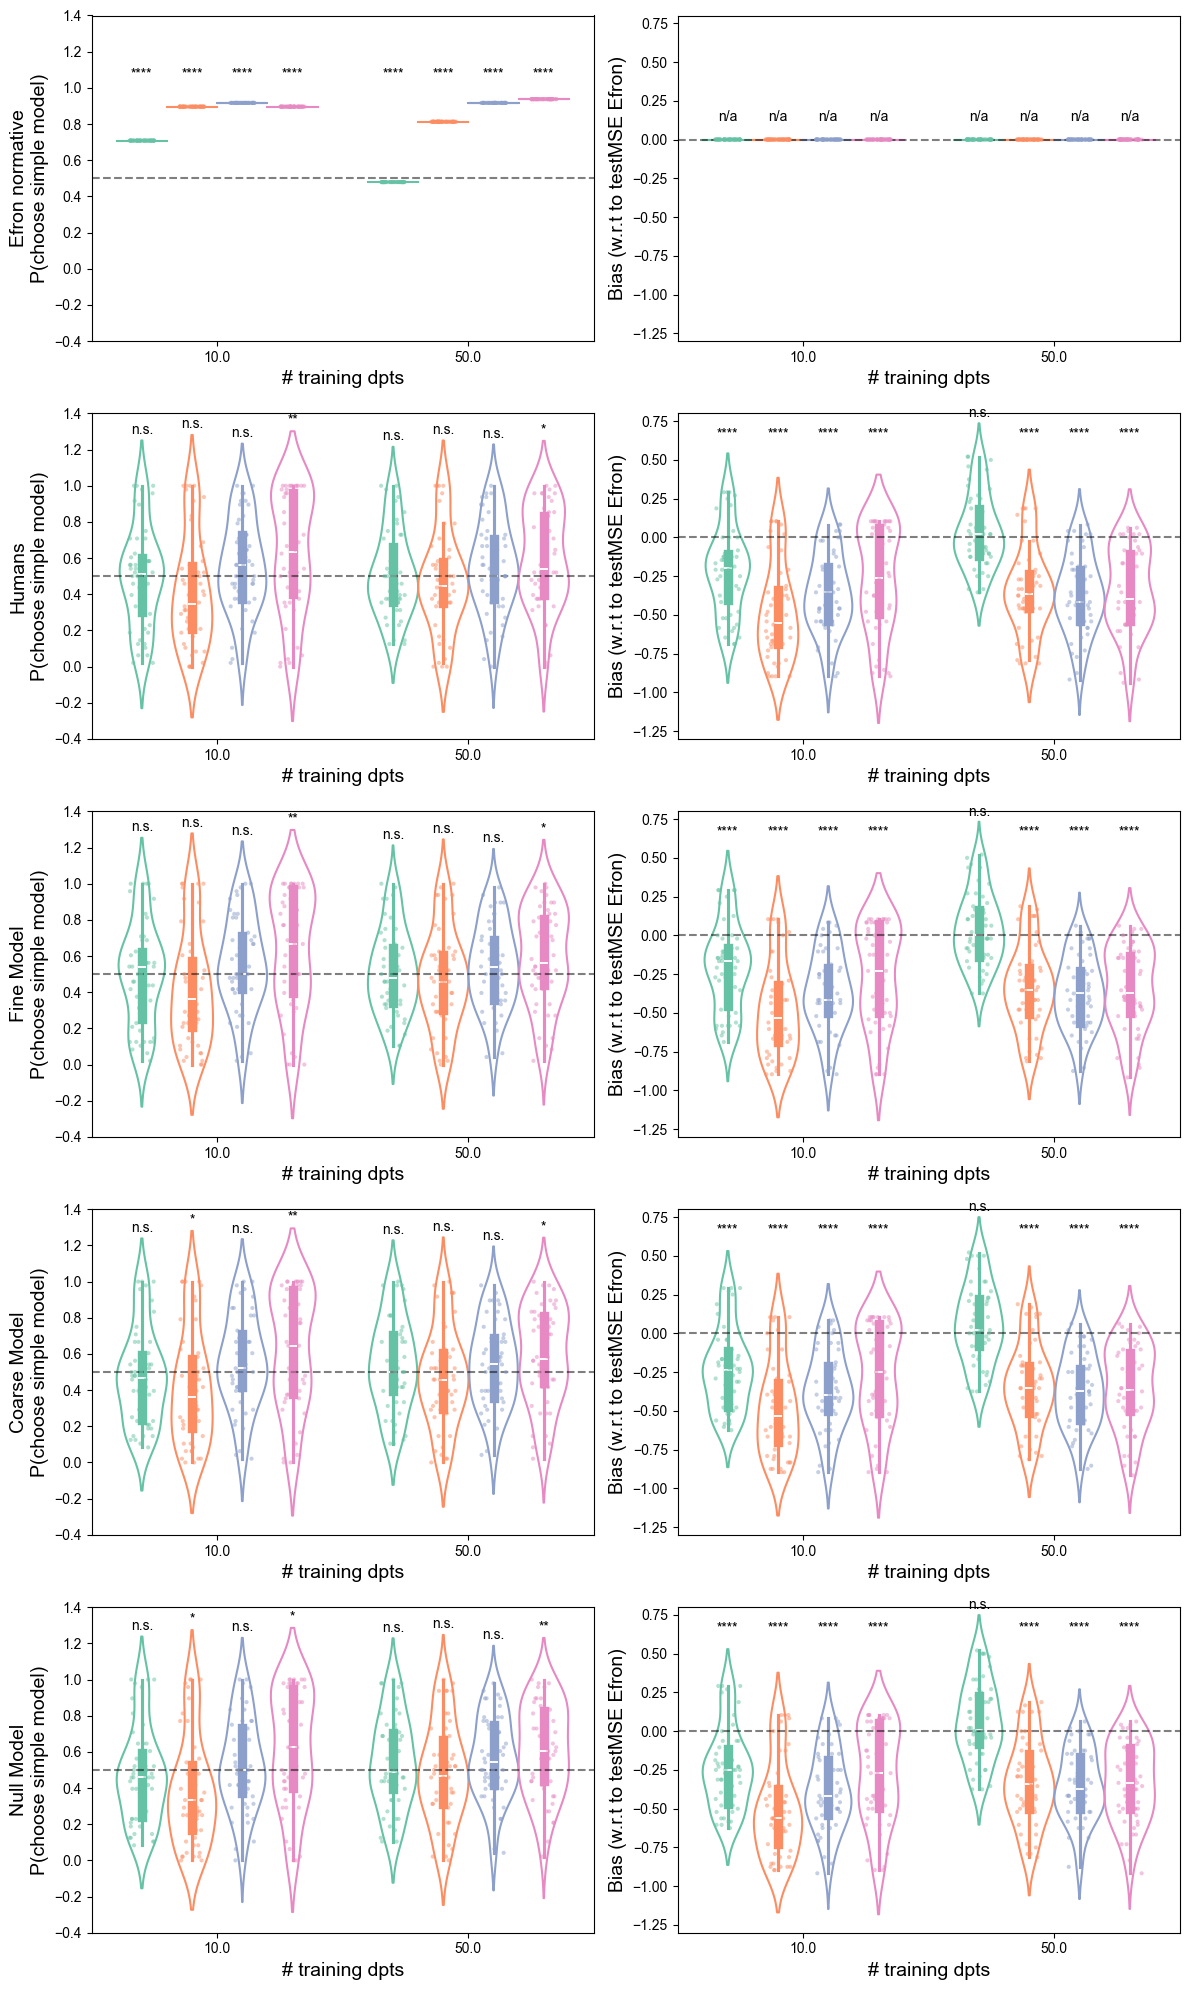

In [30]:
# Count over participants
experiment_groups = ["exp1","exp2","exp3","exp4"]
num_experiments = len(experiment_groups)
rownames = ["Efron normative", "Humans"] + model_names 
fig, ax = plt.subplots(len(rownames),2,figsize=(12,20))
save_fig = True
num_conditions = 2

# 1) Stratify by experiment
palette_exp = sns.color_palette("Set2")
for plot_idx, plot_name in enumerate(rownames):
    if(plot_name=="Humans"):
        df_temp = df_alltrials_biases
    else:
        df_temp =  df_allsimtrials_biases_models[plot_name]
    prob_bins = np.arange(0,1,0.1)
    error_bins = np.arange(-1,1,0.1)
    print(plot_name)
    
    # Change notation: label 1 is choosing simple model
    df_temp["%trials choose simple model"] = 1-df_temp["%trials choose complex model"]
    df_temp["bias (testMSE_Efron)"] = -df_temp["bias (testMSE_Efron)"]
    
    g=sns.violinplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", fill=False, ax=ax[plot_idx,0], legend=False, palette=palette_exp)
    sns.stripplot(data=df_temp, x="N_train", y="%trials choose simple model", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,0], legend=False, dodge=True, jitter=0.2, palette=palette_exp)
    ax[plot_idx,0].plot([-0.5,num_conditions-0.5],[0.5,0.5],"k--", alpha=0.5)
    x_order = sorted(df_temp["N_train"].unique())
    annotate_violin_significance(ax[plot_idx,0], df_temp,x="N_train",y="%trials choose simple model",hue="experiment", mu=0.5)
    print()
    ax[plot_idx,0].set_xlabel("# training dpts")
    ax[plot_idx,0].set_ylabel(plot_name+"\nP(choose simple model)")

    g=sns.violinplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", fill=False, ax=ax[plot_idx,1], legend=False, palette=palette_exp)
    sns.stripplot(data=df_temp, x="N_train", y="bias (testMSE_Efron)", hue="experiment", alpha=0.5, size=3, ax=ax[plot_idx,1], legend=False, dodge=True, jitter=0.2, palette=palette_exp)
    ax[plot_idx,1].plot([-0.5,num_conditions-0.5],[0,0],"k--", alpha=0.5)
    x_order = sorted(df_temp["N_train"].unique())
    annotate_violin_significance(ax[plot_idx,1], df_temp,x="N_train",y="bias (testMSE_Efron)",hue="experiment")
    print("----------\n")
    ax[plot_idx,1].set_xlabel("# training dpts")
    ax[plot_idx,1].set_ylabel("Bias (w.r.t to testMSE Efron)")
    
    for row in range(len(rownames)):
        ax[plot_idx,0].set_xlim([-0.5,num_conditions-0.5])
        ax[plot_idx,1].set_xlim([-0.5,num_conditions-0.5])
        ax[plot_idx,0].set_ylim([-0.4,1.4])
#         ax[plot_idx,1].set_ylim([-0.8,1.3])
        ax[plot_idx,1].set_ylim([-1.3,0.8])
fig.tight_layout()
if(save_fig):
    plt.savefig(os.path.join(figpath,"allexps_violinplots_simple.png"), dpi=200)
plt.show()